In [1]:
%run "sepkoskiMakerV6.ipynb"

In [2]:
# Define the clade you would like to analyze (any resolution above genus)
clade_of_interest = "Metazoa"

# Define the size of the subclades within that clade (any resolution above species)
subclade_resolution = "genus"

# Subset by paleoenvironment ("terr", "marine", "carbonate", "silicic", or None)
env_type = "marine"

subcladeDictFull = getSubcladeOccurences(clade_of_interest, resolution=subclade_resolution, 
                                         environment_only=env_type)[subclade_resolution]

Local save of requested search found.

40150 unique subclades (['genus']) found
29253 subclades with multiple occurences
23346 subclades with multiple unique occurences
19292 subclades with at least 5 occurences


In [3]:
# When to start plotting from (Ma)
t_0 = 550

# Number of time bins
bins = 100

# Number of bins to regress upon (affects magnitude of age-selectivity)
tail_length = 10#int(0.2 * bins)

# Number of bootstrap replicates to perform when inferring age-selectivity
# Keep in mind that this step takes a long time
num_bootstraps = 0

# Max age interval of any subclade (Ma)
max_duration = 275#275#int(0.5 * t_0)

# Do the subclades need to be from a valid taxonomic order?
validOrder = True

# Minimum number of occurrences of a subclade for it to be included in the dataset
min_occurrences = 1

# If min_occurrences is >1, do those occurences need to be temporally unique?
unique_occurrences = False

#min_per_bin = 1
#max_p = 0.99
#min_p = 0.01

In [5]:
bin_size = t_0 / bins
bins_to_time = [(t_0 - (bin_size * x)) - bin_size for x in range(bins)]

# Removes taxa not in a valid order
if validOrder:
    if env_type is None:
        subset_name = clade_of_interest
    else:
        subset_name = clade_of_interest + "_" + env_type
    taxDictOrder = getTaxonomyDict(subclade_resolution, "order", subset=subset_name)
    subcladeDictMetazoaValidOrder = {subclade:subcladeDictFull[subclade] for subclade in subcladeDictFull if subclade in taxDictOrder}
    print("Of", len(subcladeDictFull), "taxa,", len(subcladeDictMetazoaValidOrder), "could be mapped to a valid taxonomic order.")
    subcladeDict = subcladeDictMetazoaValidOrder
else:
    subcladeDict = subcladeDictFull

# Generates a duration matrix (n_taxa by n_bins)
# and a survival matrix (tail_length by n_bins)
durationMatrixMetazoa, labels = getDurationMatrix(subcladeDict, n_bins=bins, t_0=t_0, 
                                                  max_duration=max_duration, min_occurrences=min_occurrences,
                                                  min_unique=unique_occurrences, return_labels=True)
                                                  #occurrence_processor=occurrence_bootstrapper)
survivalMatrixMetazoa = getSurvivalMatrix(durationMatrixMetazoa, max_tail=tail_length, min_per_bin=1)
survivalCountsMetazoa, ageByBinMetazoa = getSurvivalMatrix(durationMatrixMetazoa, max_tail=tail_length, min_per_bin=1, proportions=False)
num_taxa = durationMatrixMetazoa.shape[0]

# Generates a 50x resolution history of extinction rates
durationMatrixHighRes = getDurationMatrix(subcladeDict, n_bins=bins*50, t_0=t_0, 
                                          max_duration=max_duration, min_occurrences=min_occurrences)
extinctionRatesHighRes = get_extinction_rate(durationMatrixHighRes)



# Calculates extinction rate, speciation rate, 
# and total richness (in subclade units) at each bin boundary
extinctionRates = get_extinction_rate(durationMatrixMetazoa)
extinctionNums = get_extinction_rate(durationMatrixMetazoa, proportions=False)
speciationNums = get_speciation_rate(durationMatrixMetazoa)
richnessNums = get_richness(durationMatrixMetazoa)

print("N taxa:", durationMatrixMetazoa.shape[0])
print("Duration matrix has dims", durationMatrixMetazoa.shape, "(n_taxa, n_bins)")
print("Survival matrix has dims", survivalMatrixMetazoa.shape, "(tail_length, n_bins)")
print(len(extinctionRates), "(n_bins) extinction rates")

Of 40150 taxa, 36251 could be mapped to a valid taxonomic order.
N taxa: 36117
Duration matrix has dims (36117, 100) (n_taxa, n_bins)
Survival matrix has dims (10, 100) (tail_length, n_bins)
100 (n_bins) extinction rates


In [6]:
# Calculates age-selectivity of extinction across each bin boundary
logOdds, models, bs = getLogOdds(survivalMatrixMetazoa, num_taxa, count_by_bin = ageByBinMetazoa,
                                 num_bootstraps=0, ignore_youngest=False, verbose=True)

Time bin: 99 / 100


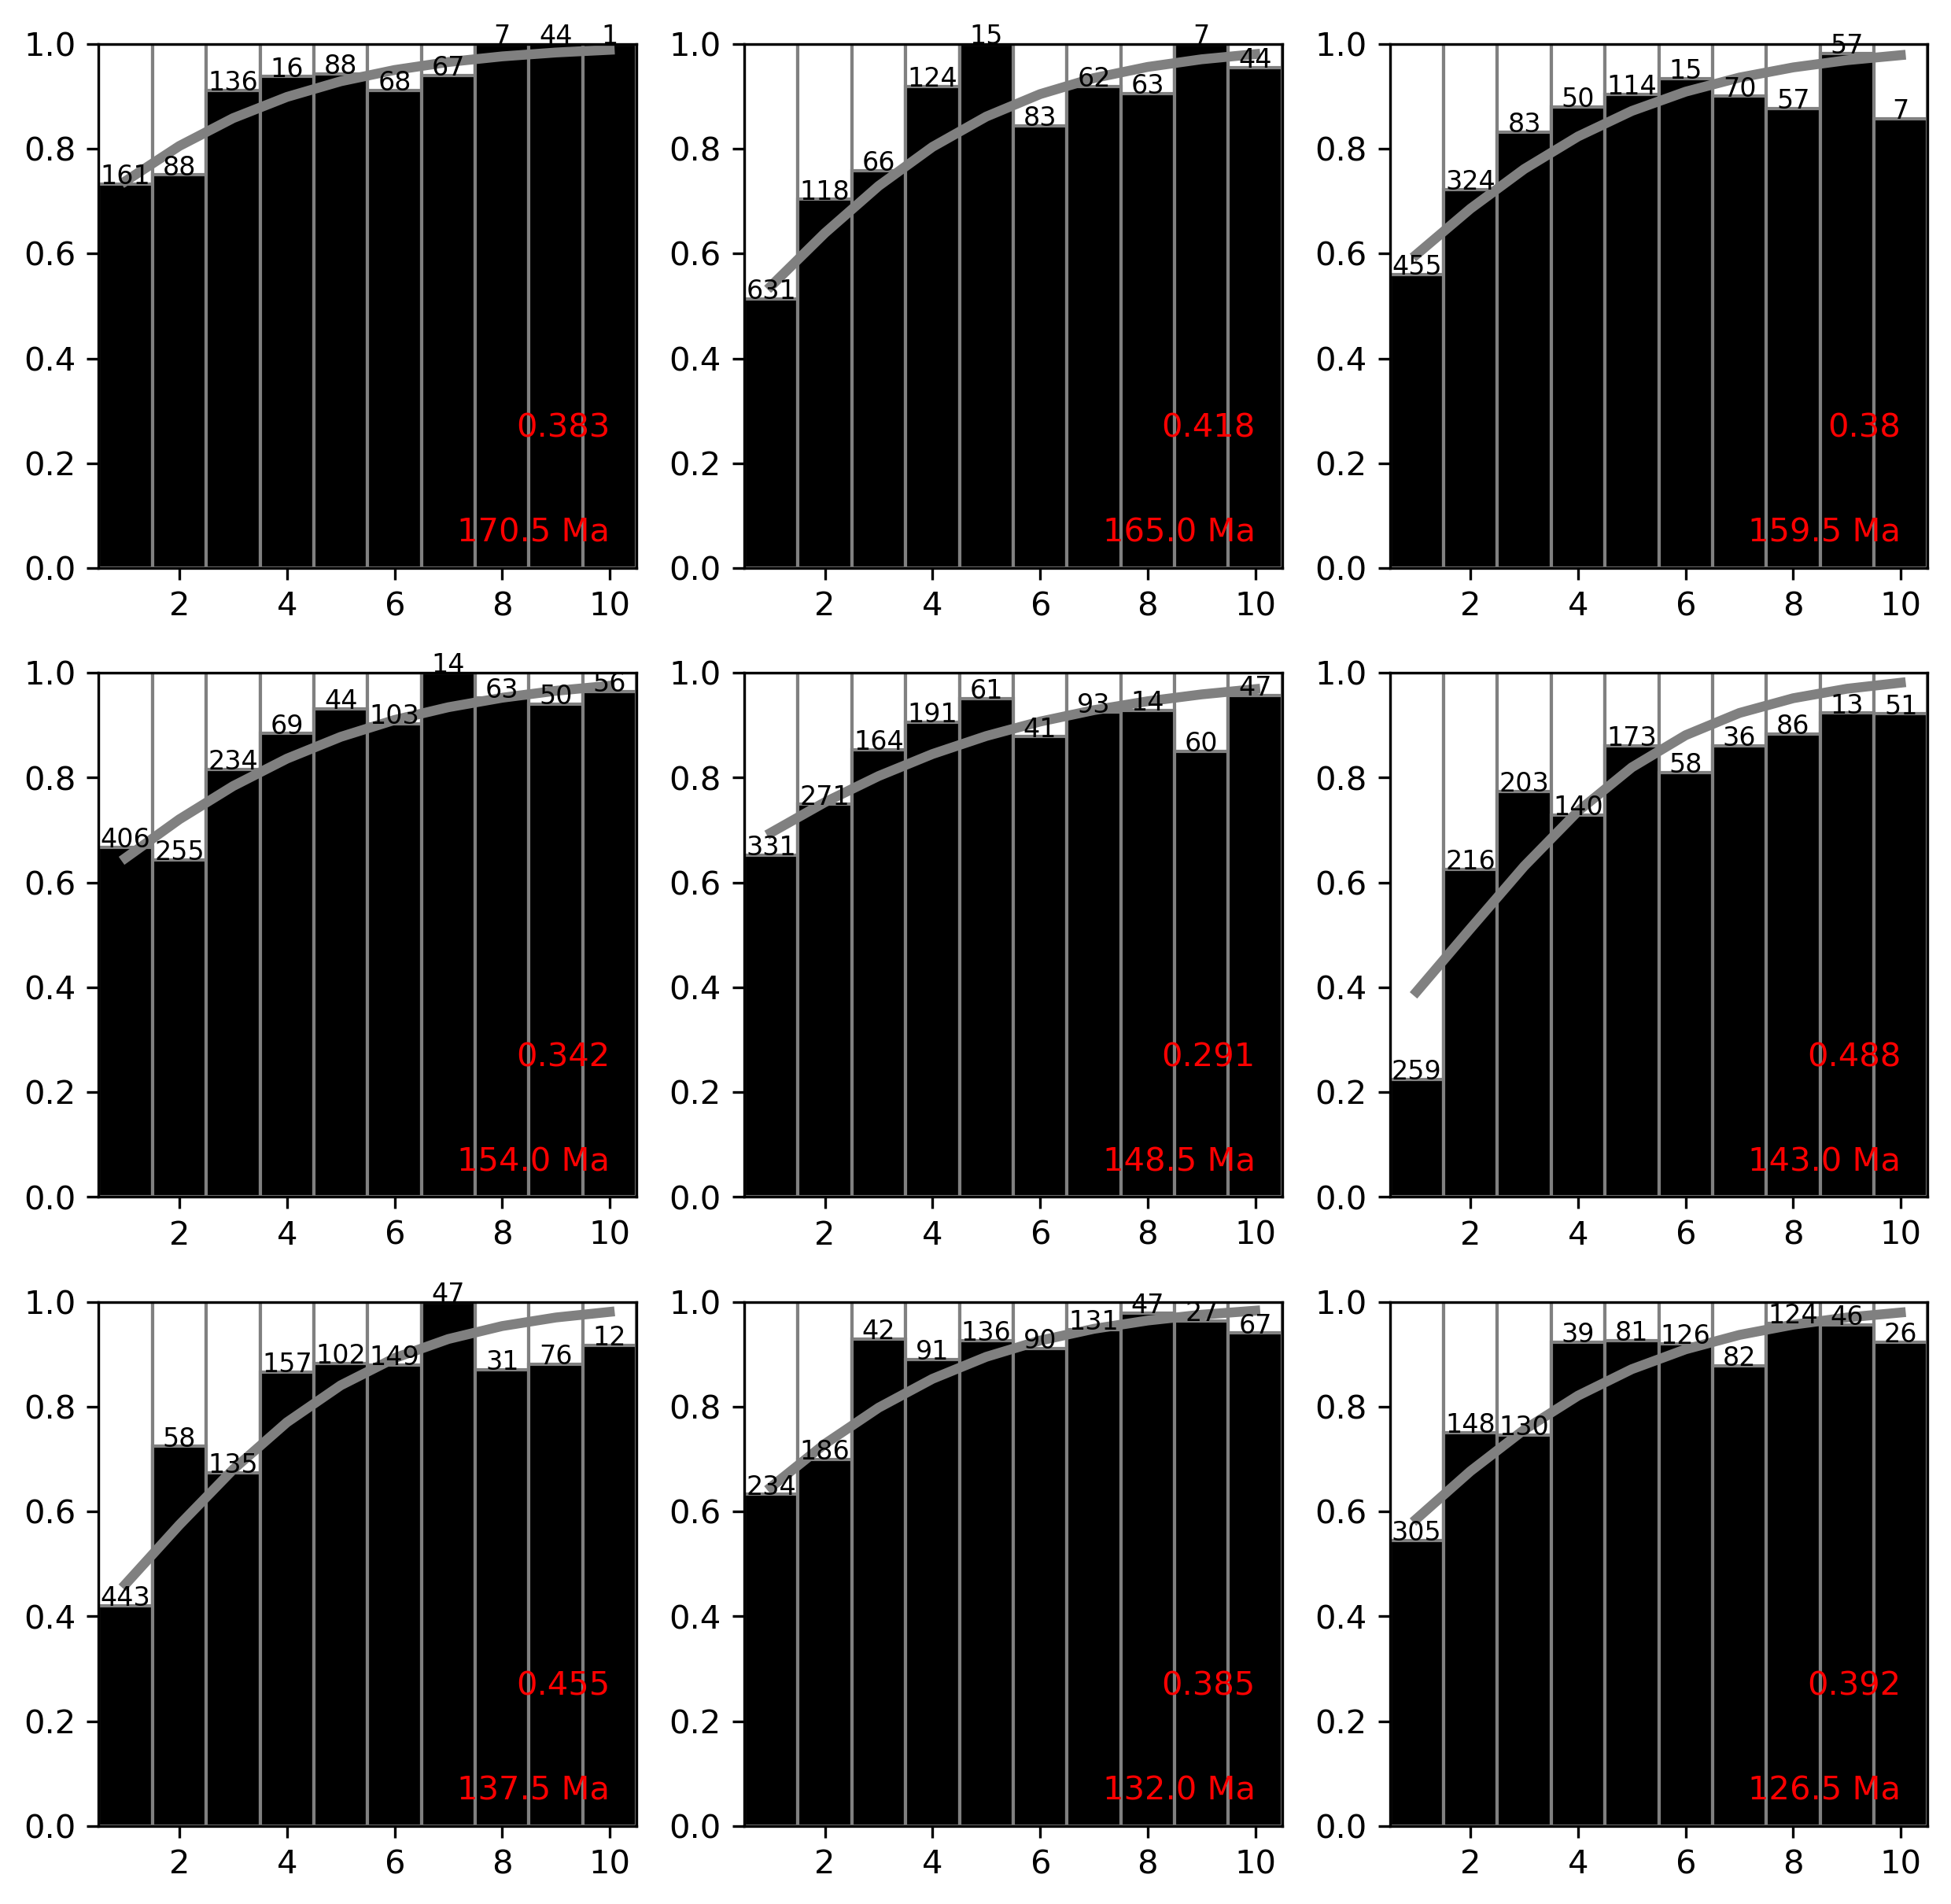

In [8]:
# Individual age-selectivity plots around a time point of interest (Ma)
center = 150

if center == None:
    center = np.random.randint(bins)
elif center not in bins_to_time:
    center = min(range(len(bins_to_time)), key = lambda i: abs(bins_to_time[i]-center))

fig, ax = plt.subplots(3, 3)
fig.set_size_inches(10, 10)
seen = []
#print(models)
for i in range(9):
    test_bin = i + center - 5
    #np.random.randint(bins)
    seen.append(test_bin)
    while (not isinstance(models[test_bin], LogitRegression)) or (test_bin in seen):
        seen.append(test_bin)
        test_bin += 1

    ax[i//3, i%3].set_ylim(0,1)
    ax[i//3, i%3].set_xlim(0.5, tail_length + 0.5)
    ax[i//3, i%3].bar(range(1, tail_length + 1), [1]*tail_length,color='white', edgecolor='gray', width=1)
    ax[i//3, i%3].bar(range(1, tail_length + 1), survivalMatrixMetazoa[:, test_bin], color='black', edgecolor='gray', width=1)
    for j in range(len(survivalMatrixMetazoa[:, test_bin])):
        if ageByBinMetazoa[test_bin][j] == 0:
            ax[i//3, i%3].text(j+1,0,ageByBinMetazoa[test_bin][j], fontsize=8, horizontalalignment='center')
        else:
            ax[i//3, i%3].text(j+1,survivalMatrixMetazoa[:, test_bin][j],ageByBinMetazoa[test_bin][j], fontsize=8, horizontalalignment='center')
    ax[i//3, i%3].text(10, 0.05, str(t_0 - (bin_size * (test_bin + 1))) + " Ma", color="red", horizontalalignment="right")
    ax[i//3, i%3].text(10, 0.25, round(models[test_bin].coef_[0][0], 3), color="red", horizontalalignment="right")
    
    ax[i//3, i%3].plot(range(1, tail_length + 1), models[test_bin].predict(np.array(list(range(0, tail_length))).reshape(-1, 1)), color="gray", linewidth=3)
    #ax[i//3, i%3].plot(range(1, tail_length + 1), modelsCons[test_bin].predict(np.array(list(range(0, tail_length))).reshape(-1, 1)), color="gray", linewidth=3, linestyle=":")

[544.5, 539.0, 533.5, 528.0, 522.5, 517.0, 511.5, 506.0, 500.5, 495.0, 489.5, 484.0, 478.5, 473.0, 467.5, 462.0, 456.5, 451.0, 445.5, 440.0, 434.5, 429.0, 423.5, 418.0, 412.5, 407.0, 401.5, 396.0, 390.5, 385.0, 379.5, 374.0, 368.5, 363.0, 357.5, 352.0, 346.5, 341.0, 335.5, 330.0, 324.5, 319.0, 313.5, 308.0, 302.5, 297.0, 291.5, 286.0, 280.5, 275.0, 269.5, 264.0, 258.5, 253.0, 247.5, 242.0, 236.5, 231.0, 225.5, 220.0, 214.5, 209.0, 203.5, 198.0, 192.5, 187.0, 181.5, 176.0, 170.5, 165.0, 159.5, 154.0, 148.5, 143.0, 137.5, 132.0, 126.5, 121.0, 115.5, 110.0, 104.5, 99.0, 93.5, 88.0, 82.5, 77.0, 71.5, 66.0, 60.5, 55.0, 49.5, 44.0, 38.5, 33.0, 27.5, 22.0, 16.5, 11.0, 5.5, 0.0]


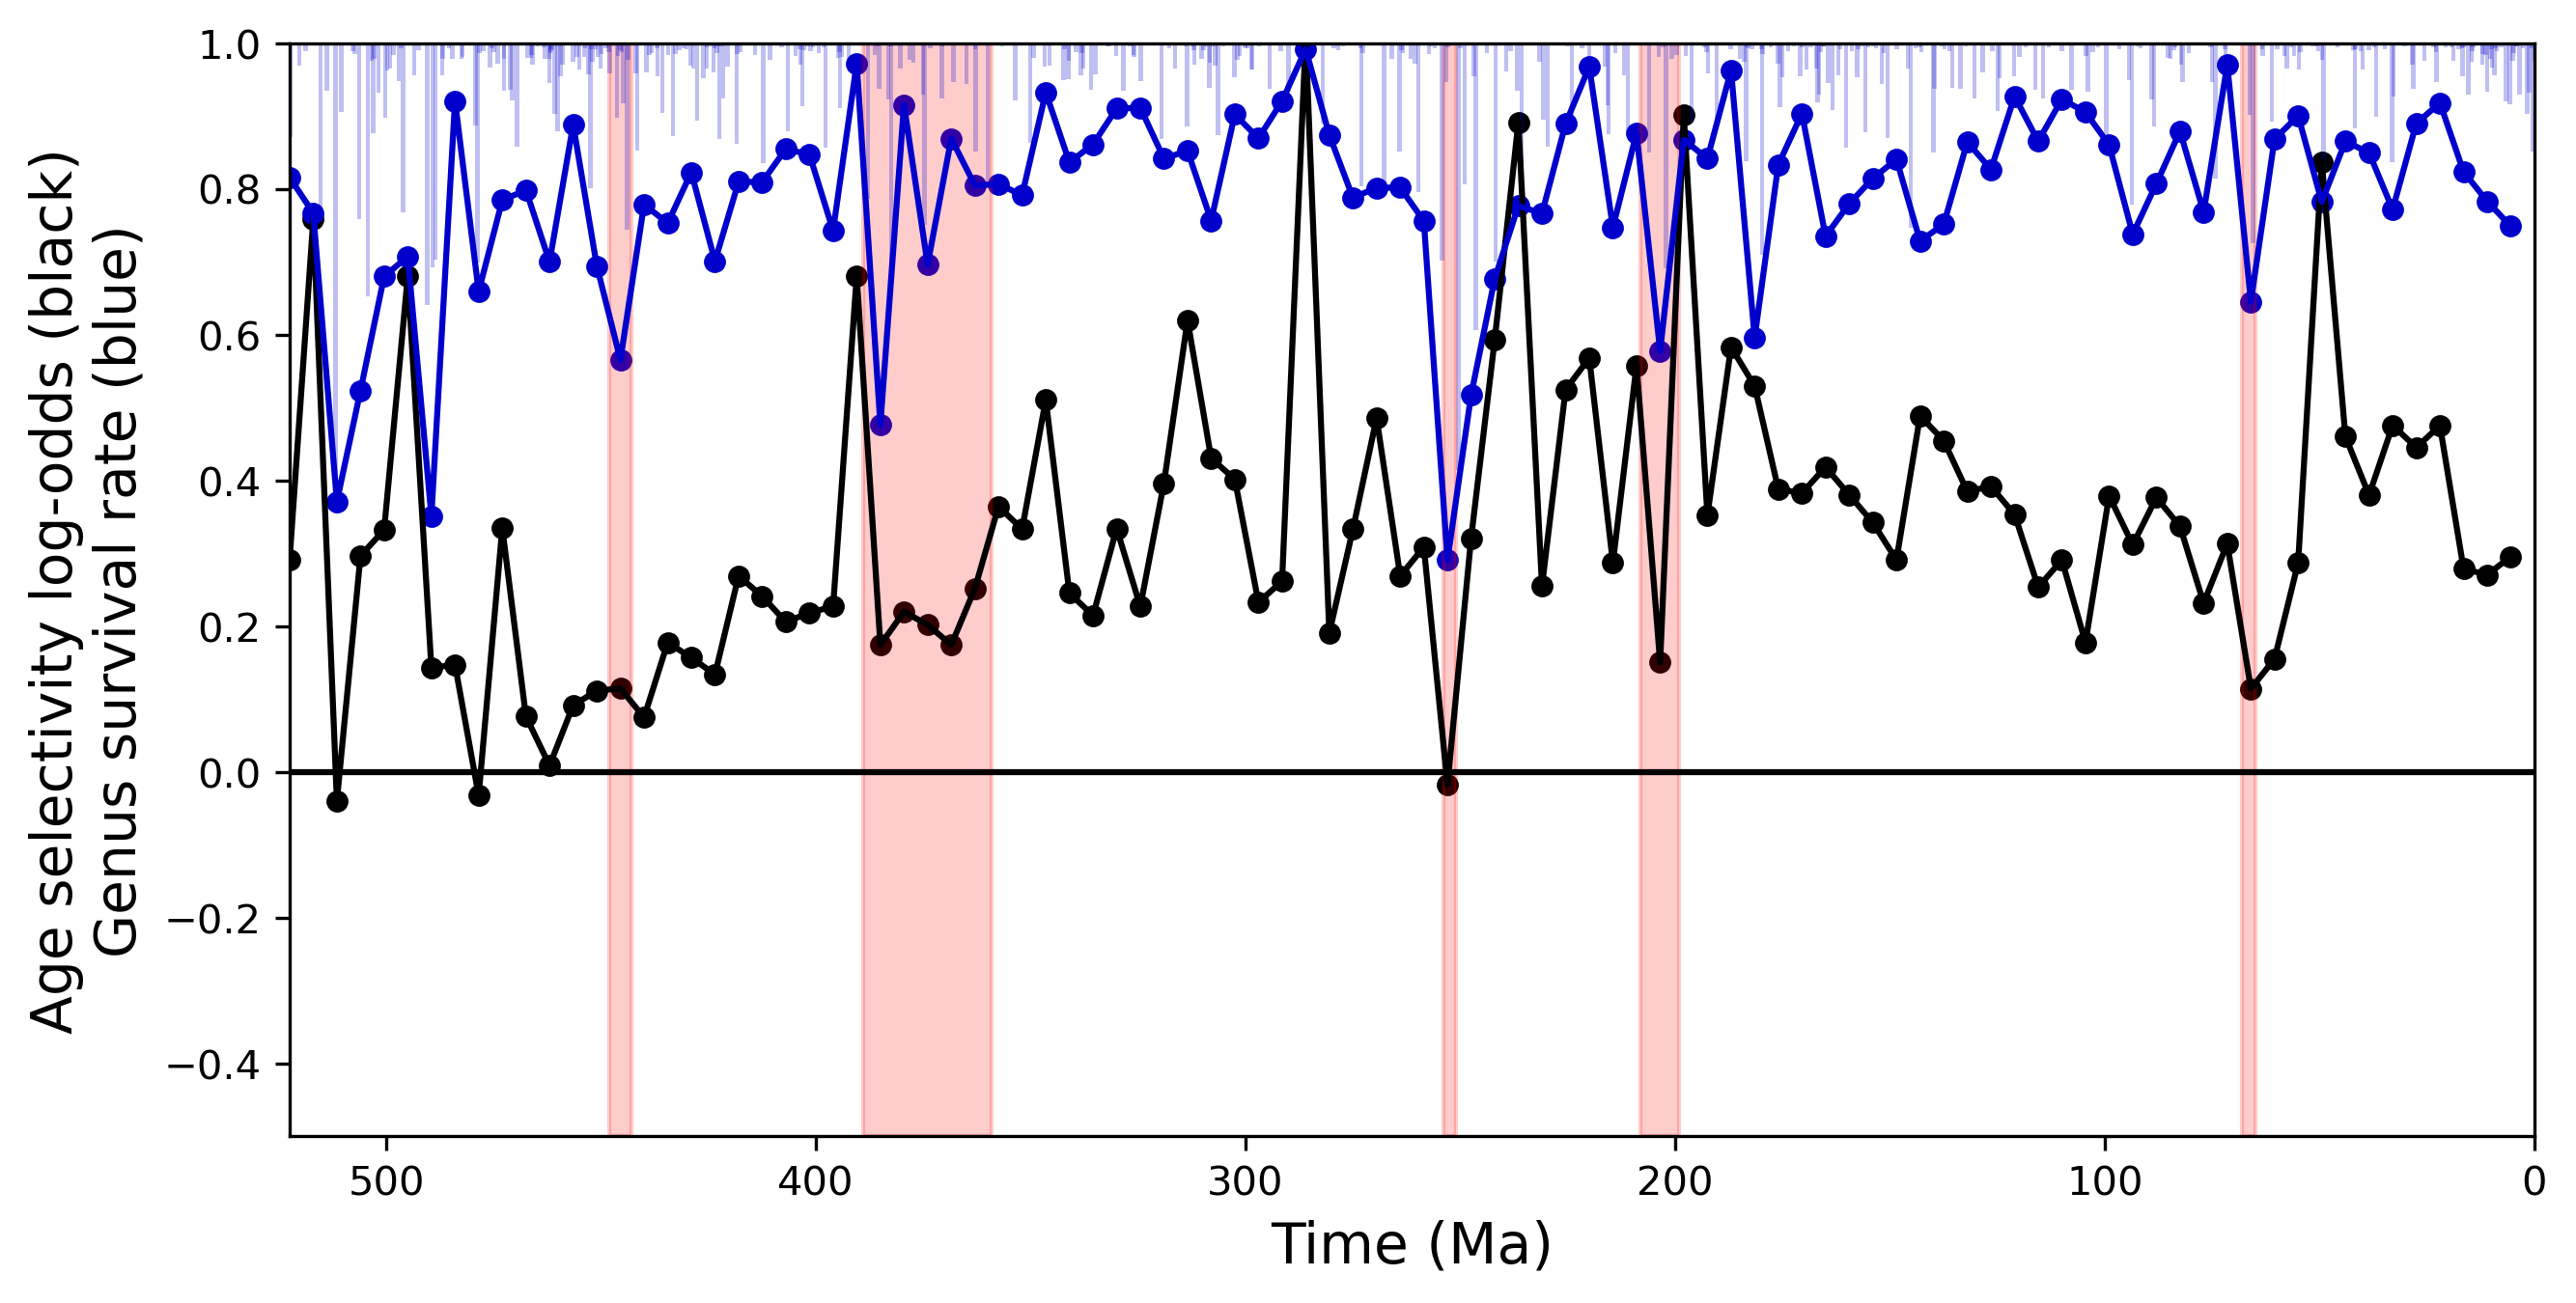

In [9]:
# Plots age-selectivity of extinction and extinction rates

#print(logOdds)
tots = durationMatrixMetazoa.sum(axis=0)
counts = (durationMatrixMetazoa!=0).sum(axis=0)
counts[counts == 0] = 1
mean_age = np.true_divide(tots, counts)

tots = durationMatrixHighRes.sum(axis=0)
counts = (durationMatrixHighRes!=0).sum(axis=0)
counts[counts == 0] = 1
mean_age_highRes = np.true_divide(tots, counts)

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
#ax.scatter([(start + end) / 2 for start, end in LIPs], [-0.1] * len(LIPs), color="red")
ax.hlines(0, 0, t_0, color="black")
#ax.vlines([253, 66, 198], -2, 2, alpha=0.5, color="red")
ax.axvspan(448, 443, alpha=0.2, color='red')
ax.axvspan(389, 359, alpha=0.2, color='red')
ax.axvspan(254, 251, alpha=0.2, color='red')
ax.axvspan(208, 199, alpha=0.2, color='red')
ax.axvspan(68, 65, alpha=0.2, color='red')

#for LIP in LIPs: ax.axvspan(LIP[0], LIP[1], alpha=0.2, color="pink")

#ax.axvspan(201, 210, alpha=0.2, color='red')
#ax.vlines([486], -2, 2, alpha=0.5, color="purple")
ax.bar([t_0 - (bin_size * x) - (0.5 * bin_size) for x in np.linspace(0, bins, num=bins*50)], [-x if x>0 else 0 for x in extinctionRatesHighRes],
        color="mediumblue",width=1,bottom=1, alpha=0.25)

#for i in range(0, 550, 50):
#    ax.vlines(i, -2, 2, linestyles='--', color="green")
#ax.plot(bins_to_time,[abs(np.log(x)) for x in logOdds], '--', color="gray")
ax.plot(bins_to_time[4:-1],[np.log(x) for x in logOdds][4:-1], color="black")
ax.scatter(bins_to_time[4:-1],[np.log(x) for x in logOdds][4:-1], s=20, color="black")

#ax.scatter([bins_to_time[x] for x in boundary],[np.log(x) for x in [logOdds[y] for y in boundary]], s=20, color="orange")


#ax.plot(bins_to_time,[np.log(x) for x in logOddsCons], color="gray", linestyle=":", zorder=-1)
#ax.scatter(bins_to_time,[np.log(x) for x in logOddsCons], s=20, color="gray")

ax.scatter(bins_to_time[4:-1], [1 - x for x in extinctionRates][4:-1], s=20, color="mediumblue")
ax.plot(bins_to_time[4:-1], [1 - x for x in extinctionRates][4:-1], color="mediumblue")
#ax.plot([t_0 - (bin_size * x) for x in np.linspace(0, bins, num=1000)], [1 - x for x in extinctionRatesHighRes],'--',color="orange")
#print(extinctionRatesHighRes)
#ax.plot(bins_to_time, mean_age / np.max(mean_age), color="green")
#ax.plot([t_0 - (bin_size * x) for x in np.linspace(0, bins, num=1000)], mean_age / np.max(mean_age),'--',color="green")

#ax.vlines(bins_to_time[4:-1], [np.log(min(x)) for x in bs[4:-1]], [np.log(max(x)) for x in bs[4:-1]], zorder=10000,linewidth=2,color="green")
#ax.plot(bins_to_time[4:-1], [np.log(min(x)) for x in bs[4:-1]])
#ax.plot(bins_to_time[4:-1], [np.log(max(x)) for x in bs[4:-1]])
bs_dots=True
if any(bs):
    for x in range(4,len(bs)-1):
        if bs_dots:
            ax.scatter([bins_to_time[x] for y in range(len(bs[x]))], np.log(bs[x]), marker="x",alpha=0.3,color="black",s=0.5)
    ax.fill_between(bins_to_time[4:-1], [np.log(min(x)) for x in bs[4:-1]], [np.log(max(x)) for x in bs[4:-1]], color="gray", alpha=0.5,zorder=-10)

populatedLogOdds = []
for i in range(bins - 1):
    start, end = (np.log(logOdds[i]), np.log(logOdds[i+1]))
    if start and end:
        populatedLogOdds += [(x/10)*end + (1-(x/10))*start for x in range(0, 10)]
populatedLogOdds += [np.nan]*10
#print(len(populatedLogOdds))
#ax.scatter(np.linspace(0, 550, num=1000)[::-1], populatedLogOdds)
plt.xlabel("Time (Ma)", fontsize=14)
plt.ylabel("Age selectivity log-odds (black)\nGenus survival rate (blue)", fontsize=14)
plt.xlim(0,t_0-5*bin_size)
plt.ylim(-0.5,1)
plt.gca().invert_xaxis()
print(bins_to_time)

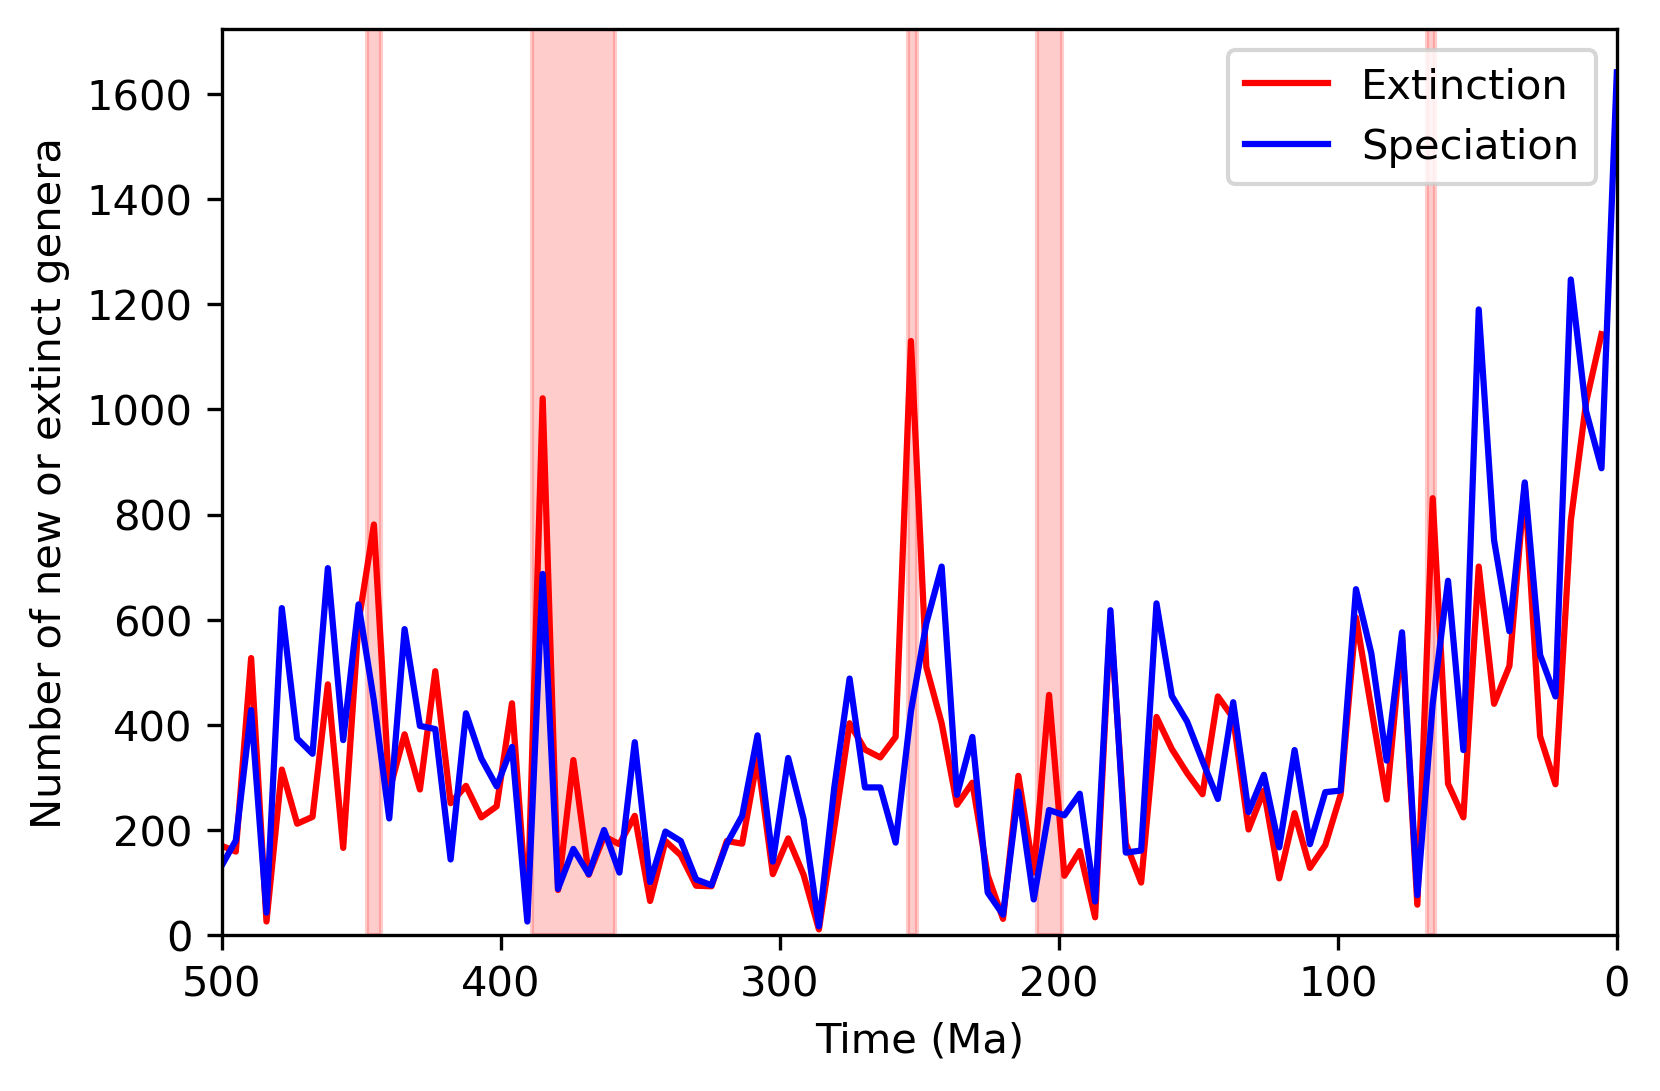

In [10]:
bins_to_time_ext = [(t_0 - (bin_size * x)) - (1 * bin_size) for x in range(bins)]
bins_to_time_spec = [(t_0 - (bin_size * x)) - (1 * bin_size) for x in range(bins)]

fig, ax = plt.subplots()

ax.plot(bins_to_time_ext, extinctionNums, color="red", label="Extinction")
ax.plot(bins_to_time_spec, speciationNums, color="blue", label="Speciation")
#ax.plot(bins_to_time_ext, speciationNums/extinctionNums, color="red")

ax.axvspan(448, 443, alpha=0.2, color='red')
ax.axvspan(389, 359, alpha=0.2, color='red')
ax.axvspan(254, 251, alpha=0.2, color='red')
ax.axvspan(208, 199, alpha=0.2, color='red')
ax.axvspan(68, 65, alpha=0.2, color='red')
ax.set_xlim(500,0)
ax.set_ylim(0, None)

ax.set_xlabel("Time (Ma)")
ax.set_ylabel("Number of new or extinct genera")
ax.legend()

#twin1 = ax.twinx()
#twin1.plot(bins_to_time_ext, speciationNums/extinctionNums, color="black")
#twin1.plot(bins_to_time, richnessNums, color="green")
#twin1.set_ylim(0, 3)
#twin1.hlines([1],0,t_0,linestyle="--")

#plt.gca().invert_xaxis()

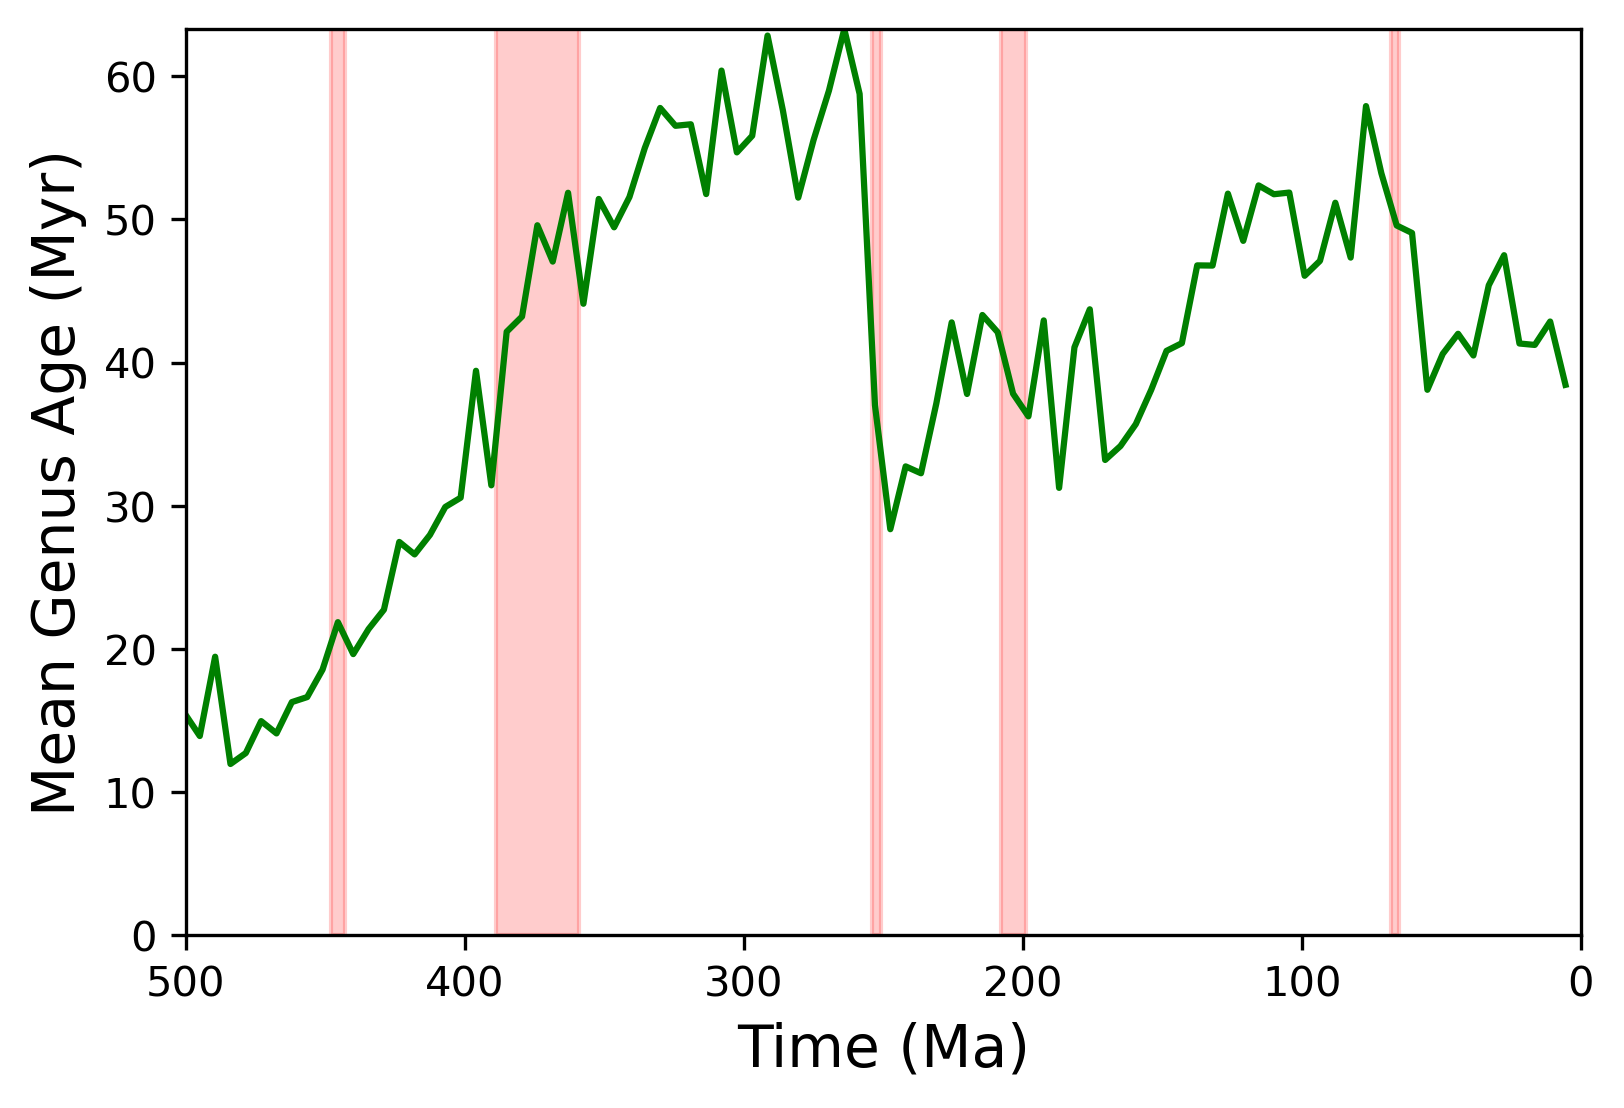

In [32]:
fig, ax = plt.subplots()
ax.axvspan(448, 443, alpha=0.2, color='red')
ax.axvspan(389, 359, alpha=0.2, color='red')
ax.axvspan(254, 251, alpha=0.2, color='red')
ax.axvspan(208, 199, alpha=0.2, color='red')
ax.axvspan(68, 65, alpha=0.2, color='red')
ax.plot([t_0 + bin_size] + bins_to_time[:-1], [x * bin_size for x in mean_age], color="green")
ax.set_ylim(0, max(mean_age) * bin_size)
ax.set_xlim(0, 500)
ax.set_xlabel("Time (Ma)", fontsize=14)
ax.set_ylabel("Mean Genus Age (Myr)", fontsize=14)
plt.gca().invert_xaxis()

[(544.5, 0, 0.75), (511.5, 6, 0.63), (506.0, 7, 0.48), (500.5, 8, 0.32), (489.5, 10, 0.65), (478.5, 12, 0.34), (462.0, 15, 0.3), (451.0, 17, 0.31), (445.5, 18, 0.43), (385.0, 29, 0.52), (374.0, 31, 0.3), (253.0, 53, 0.71), (247.5, 54, 0.48), (242.0, 55, 0.32), (203.5, 62, 0.42), (181.5, 66, 0.4), (66.0, 87, 0.35)]
3
[[ 1.         -0.31310454]
 [-0.31310454  1.        ]]


Text(0, 0.5, 'Age selectivity log-odds')

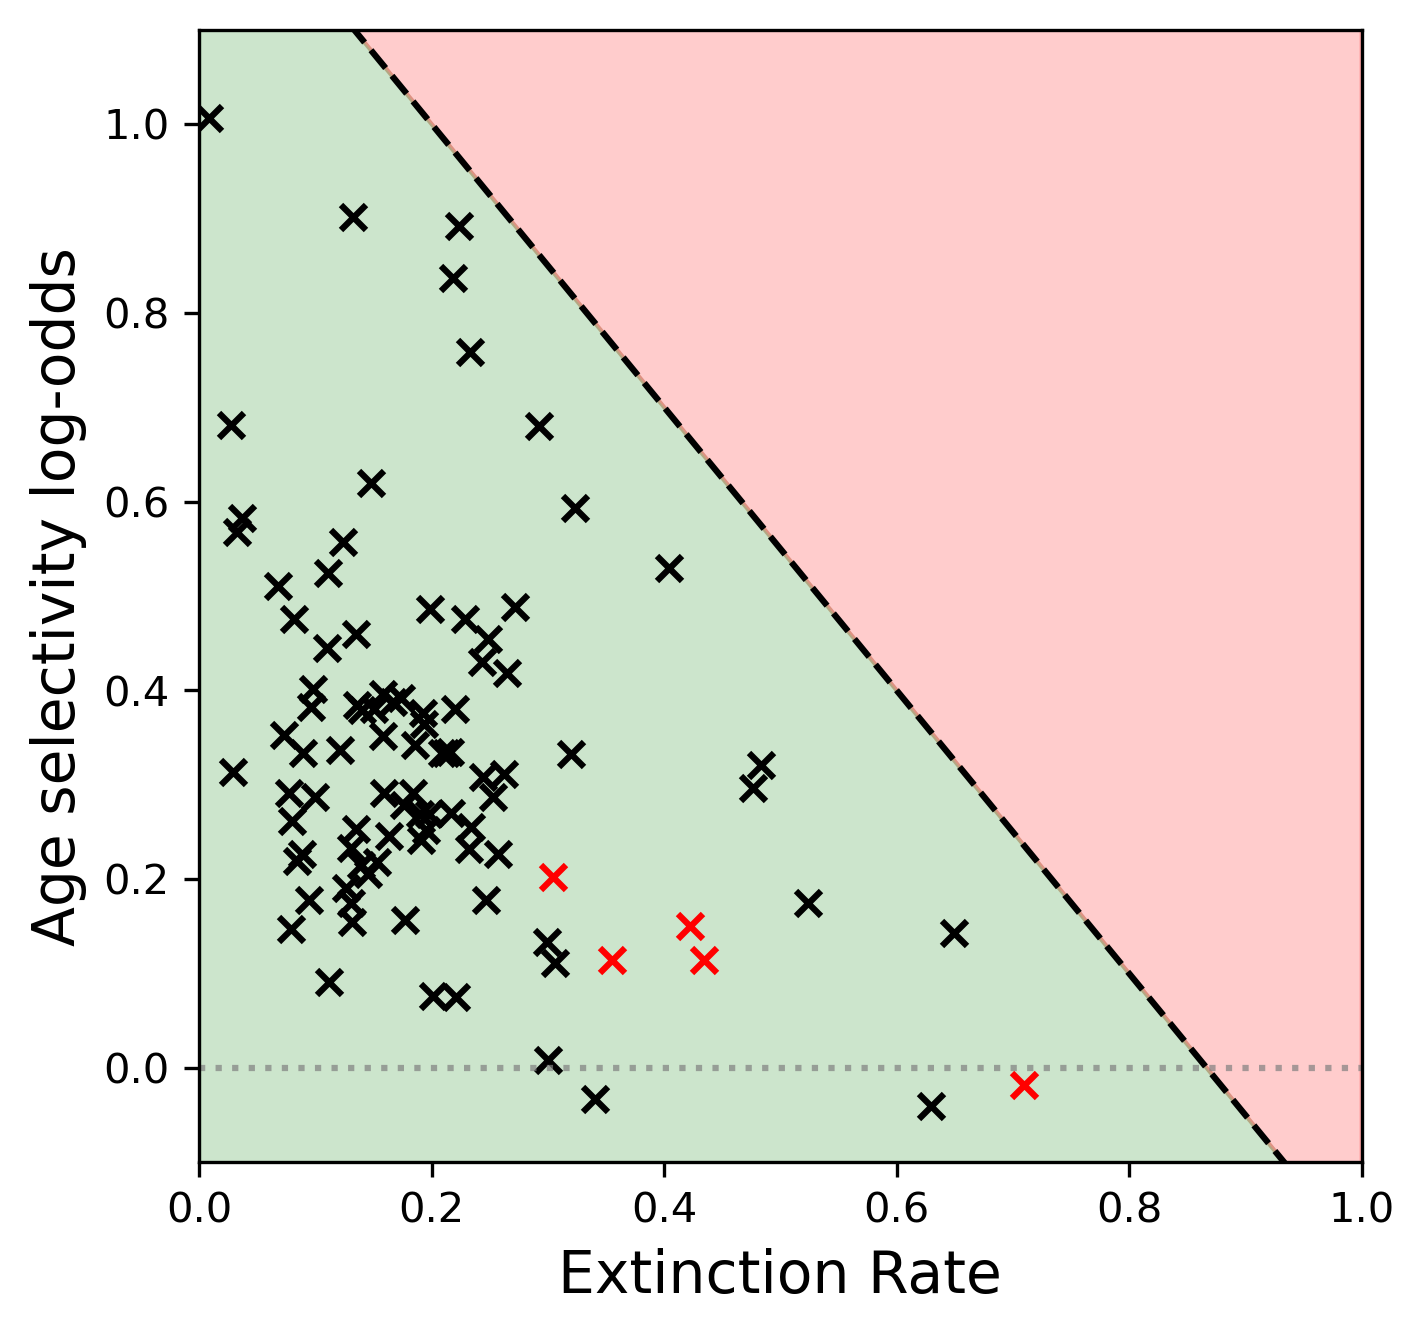

In [16]:
#print(extinctionRates)
#print([np.log(x) for x in logOdds])
print([(bins_to_time[x], x, round(extinctionRates[x],2)) for x in range(bins) if extinctionRates[x]>0.3])

outlier = max([x for x in logOdds if not x is np.nan])
print(logOdds.index(outlier))
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.hlines(0, 0, 1, color="gray", linestyle=":",alpha=0.7)
#ax.scatter(np.diff(extinctionRates[15:-1]), np.diff([np.log(x) for x in logOdds][15:-1]), color="black")
#ax.scatter(np.diff(extinctionRates), np.diff([np.log(x) for x in logOdds]), color="black")
#ax.scatter(extinctionRates[4:-2], [x for x in logOdds][4:-2], color="black",marker="x")
#ax.plot(extinctionRates[4:-2], [x for x in logOdds][4:-2], color="black")

boundary = []

for poi in range(4, bins-2):
    extrt, odds = extinctionRates[poi], logOdds[poi]
    #if (odds - 2.25)/extrt > -2.2:
    #    boundary.append(poi)
    #    ax.text(0.02+extrt, odds, str(bins_to_time[poi]) + " Ma", va="center",fontsize=5)
    #    ax.scatter(extinctionRates[poi], [x for x in logOdds][poi], color="red",marker="x")
    if poi in [53,62,18,87,31]:
        ax.scatter(extinctionRates[poi], np.log(logOdds[poi]), color="red",marker="x")
    else:
        ax.scatter(extinctionRates[poi], np.log(logOdds[poi]), color="black",marker="x")

ax.fill_between(np.linspace(0,1,num=100), [-1]*100, np.linspace(1.3,-0.2,num=100), color="green", alpha=0.2,zorder=-10)
ax.fill_between(np.linspace(0,1,num=100), [2]*100, np.linspace(1.3,-0.2,num=100), color="red", alpha=0.2,zorder=-10)
ax.plot(np.linspace(0,1,num=100), np.linspace(1.3,-0.2,num=100), linestyle="--", color="black")

print(np.corrcoef([x for x in logOdds][4:-2], extinctionRates[4:-2]))
ax.set_xlim(0,1)
ax.set_ylim(-0.1, 1.1)
ax.set_xlabel("Extinction Rate", fontsize=14)
ax.set_ylabel("Age selectivity log-odds", fontsize=14)

<ipython-input-17-f3e7181ac74b>:2: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(bins_to_time_ext, speciationNums/extinctionNums, color="black")


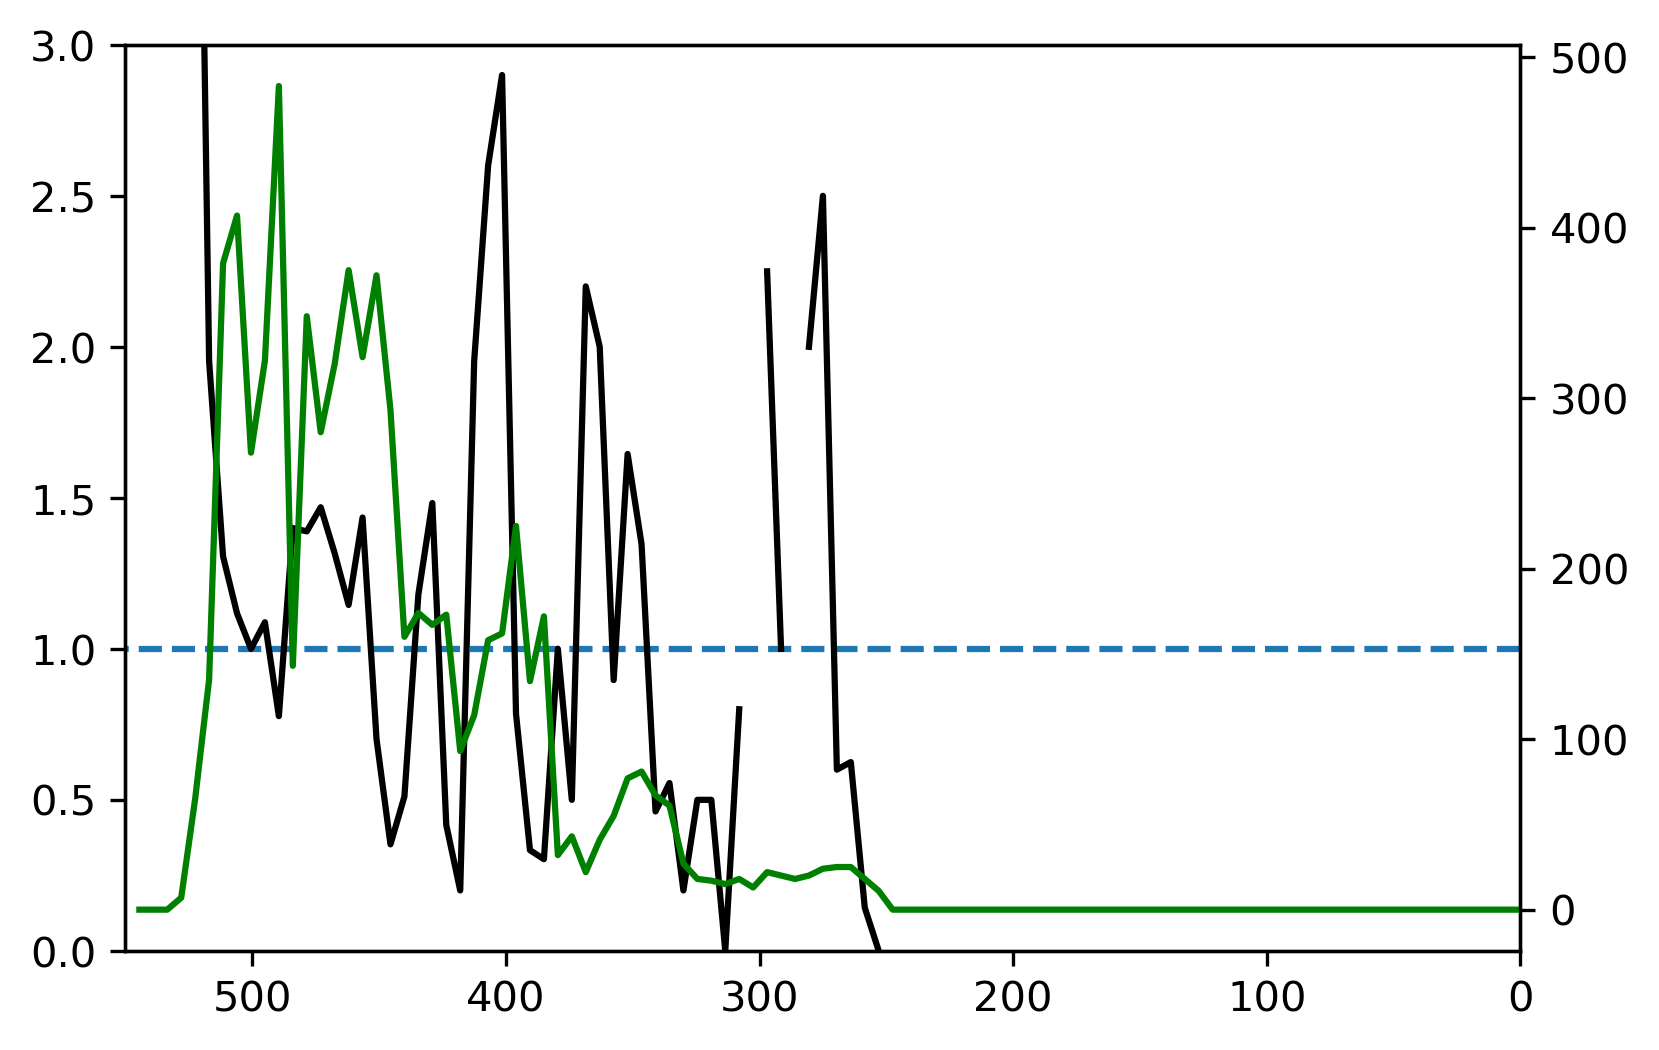

In [17]:
fig, ax = plt.subplots()
ax.plot(bins_to_time_ext, speciationNums/extinctionNums, color="black")
twin1 = ax.twinx()

twin1.plot(bins_to_time_ext, richnessNums, color="green")
ax.set_ylim(0, 3)
ax.set_xlim(t_0, 0)
ax.hlines([1],0,t_0,linestyle="--")


In [12]:
logOddsCons, modelsCons, bsCons = getLogOdds(survivalMatrixMetazoa, num_taxa, count_by_bin = ageByBinMetazoa, num_bootstraps=0, ignore_youngest=True)

/home/software/anaconda3/2020.11/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/software/anaconda3/2020.11/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


ValueError: x and y must be the same size

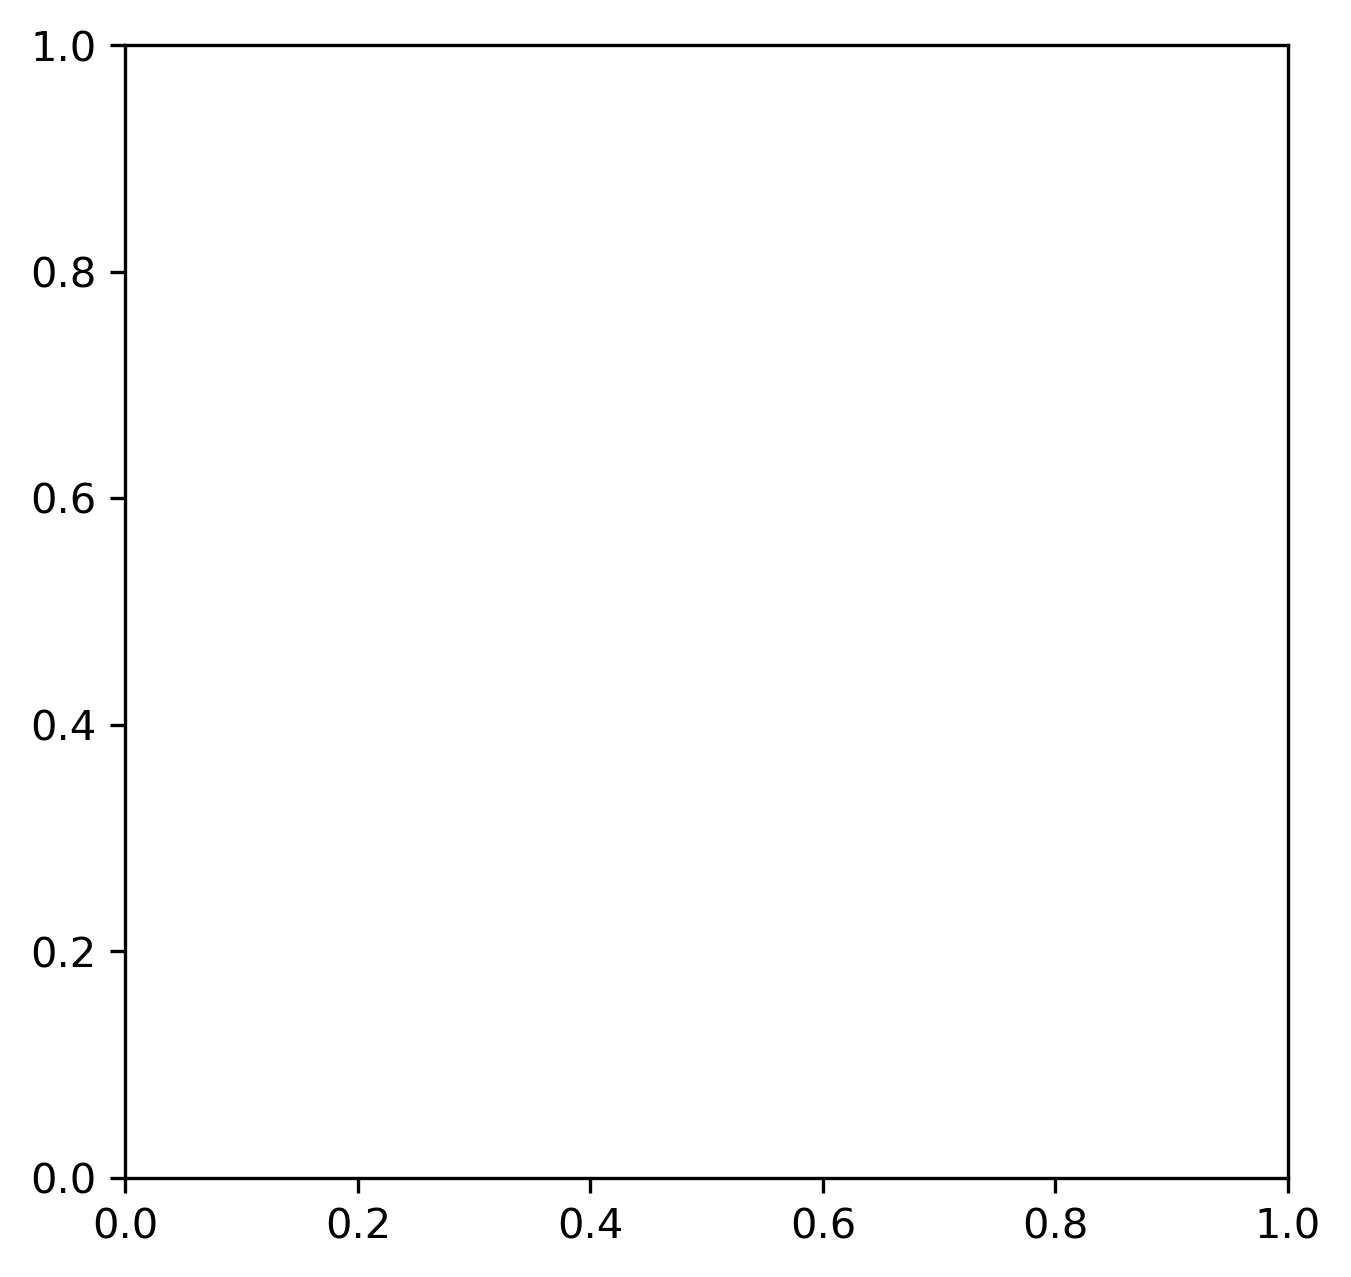

In [21]:
#print(extinctionRates)
#print([np.log(x) for x in logOdds])
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
#ax.hlines(0, 0, 1, color="black")
#ax.scatter(np.diff(extinctionRates[15:-1]), np.diff([np.log(x) for x in logOdds][15:-1]), color="black")
#ax.scatter(np.diff(extinctionRates), np.diff([np.log(x) for x in logOdds]), color="black")
ax.scatter(extinctionRates[4:-2], [np.log(np.mean(x)) for x in bs][4:-2], color="black")
print(np.corrcoef([np.log(np.mean(x)) for x in bs][4:-2], extinctionRates[4:-2]))
#ax.set_xlim(0,1)
ax.set_xlabel("Extinction Rate", fontsize=14)
ax.set_ylabel("Age selectivity log-odds", fontsize=14)

LinAlgError: SVD did not converge in Linear Least Squares

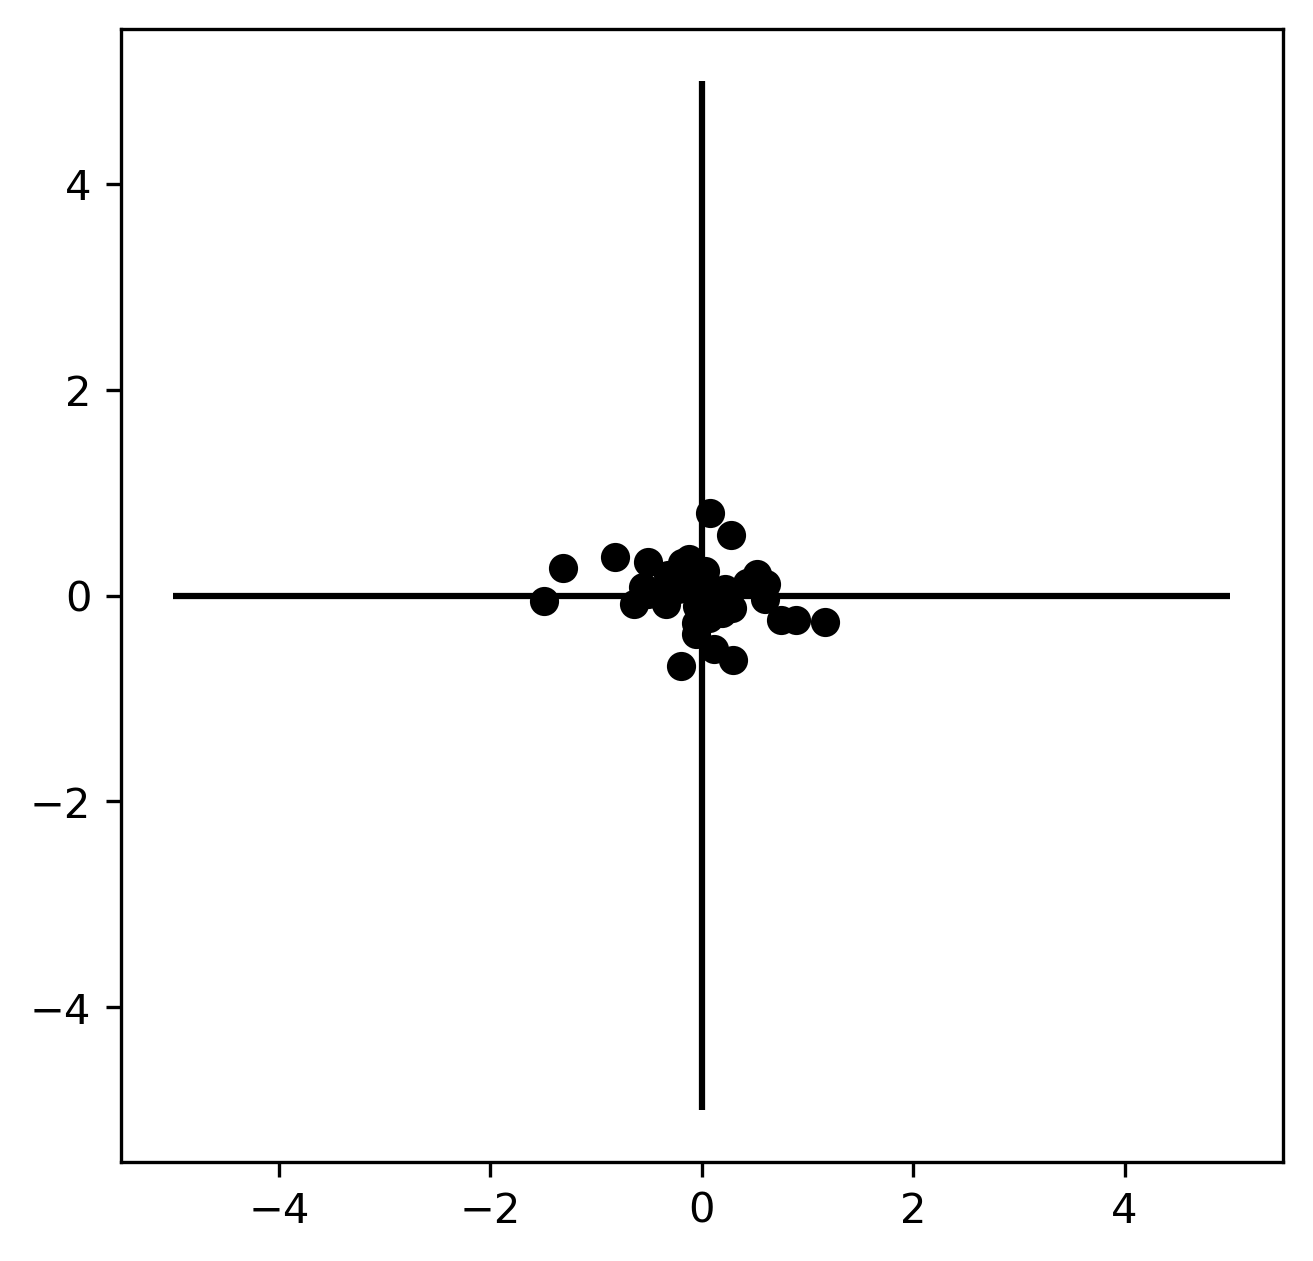

In [22]:
#print(extinctionRates)
#print([np.log(x) for x in logOdds])
fig, ax = plt.subplots()
fig.set_size_inches(5, 5)
ax.hlines(0, -5, 5, color="black")
ax.vlines(0, -5, 5, color="black")
#print(logOdds)
logOdds_diff = np.diff([np.log(x) for x in logOdds][4:-2])
logOdds_ext = np.diff(extinctionRates[4:-2])
#logOdds_diff_nooutliers = [logOdds_diff[x] for x in range(len(logOdds_diff)) if abs(logOdds_diff[x]) < 0.5]
#logOdds_ext_nooutliers = [logOdds_ext[x] for x in range(len(logOdds_diff)) if abs(logOdds_diff[x]) < 0.5]


ax.scatter(logOdds_diff, logOdds_ext, color="black")
correlation = np.corrcoef(logOdds_diff, logOdds_ext)
regression = np.polyfit(logOdds_diff, logOdds_ext, 1)

print(correlation, regression)
ax.plot(np.linspace(-1, 1,100), [x * regression[0] + regression[1] for x in np.linspace(-1, 1, 100)])
ax.set_xlim(-1, 1)
ax.set_ylim(-1,1)
ax.set_xlabel("Change in extinction rate", fontsize=14)
ax.set_ylabel("Change in age selectivity log-odds", fontsize=14)

[0.6440154187167544, 0.5098371923386087, 0.4382633131479577, 0.36186020231487814, 0.3239150606394884, 0.2823371744691639, 0.2533728647305773, 0.22947281377369522, 0.2135026740941859, 0.19975110865211068, 0.19059594588482087, 0.1783463608596157, 0.1677137016626635, 0.16092892415813395, 0.1543192585962003, 0.14047972424562225, 0.13090008456282506, 0.11842407992715501, 0.10692304369335338, 0.09694378998978627, 0.09098635536021035, 0.09291045140751136, 0.08746900053919916, 0.08311676818737597, 0.08266347712829011, 0.08174523528367554, 0.07825505494965478, 0.07173345453498978, 0.07080602785543358, 0.06704588701188587, 0.0642669154855119, 0.06601796266159812, 0.0661939628410631, 0.06160876781215483, 0.060881393450192944, 0.054574969490857814, 0.05286855828514579, 0.05530771662121891]


Text(-2, 0.65, 'a.')

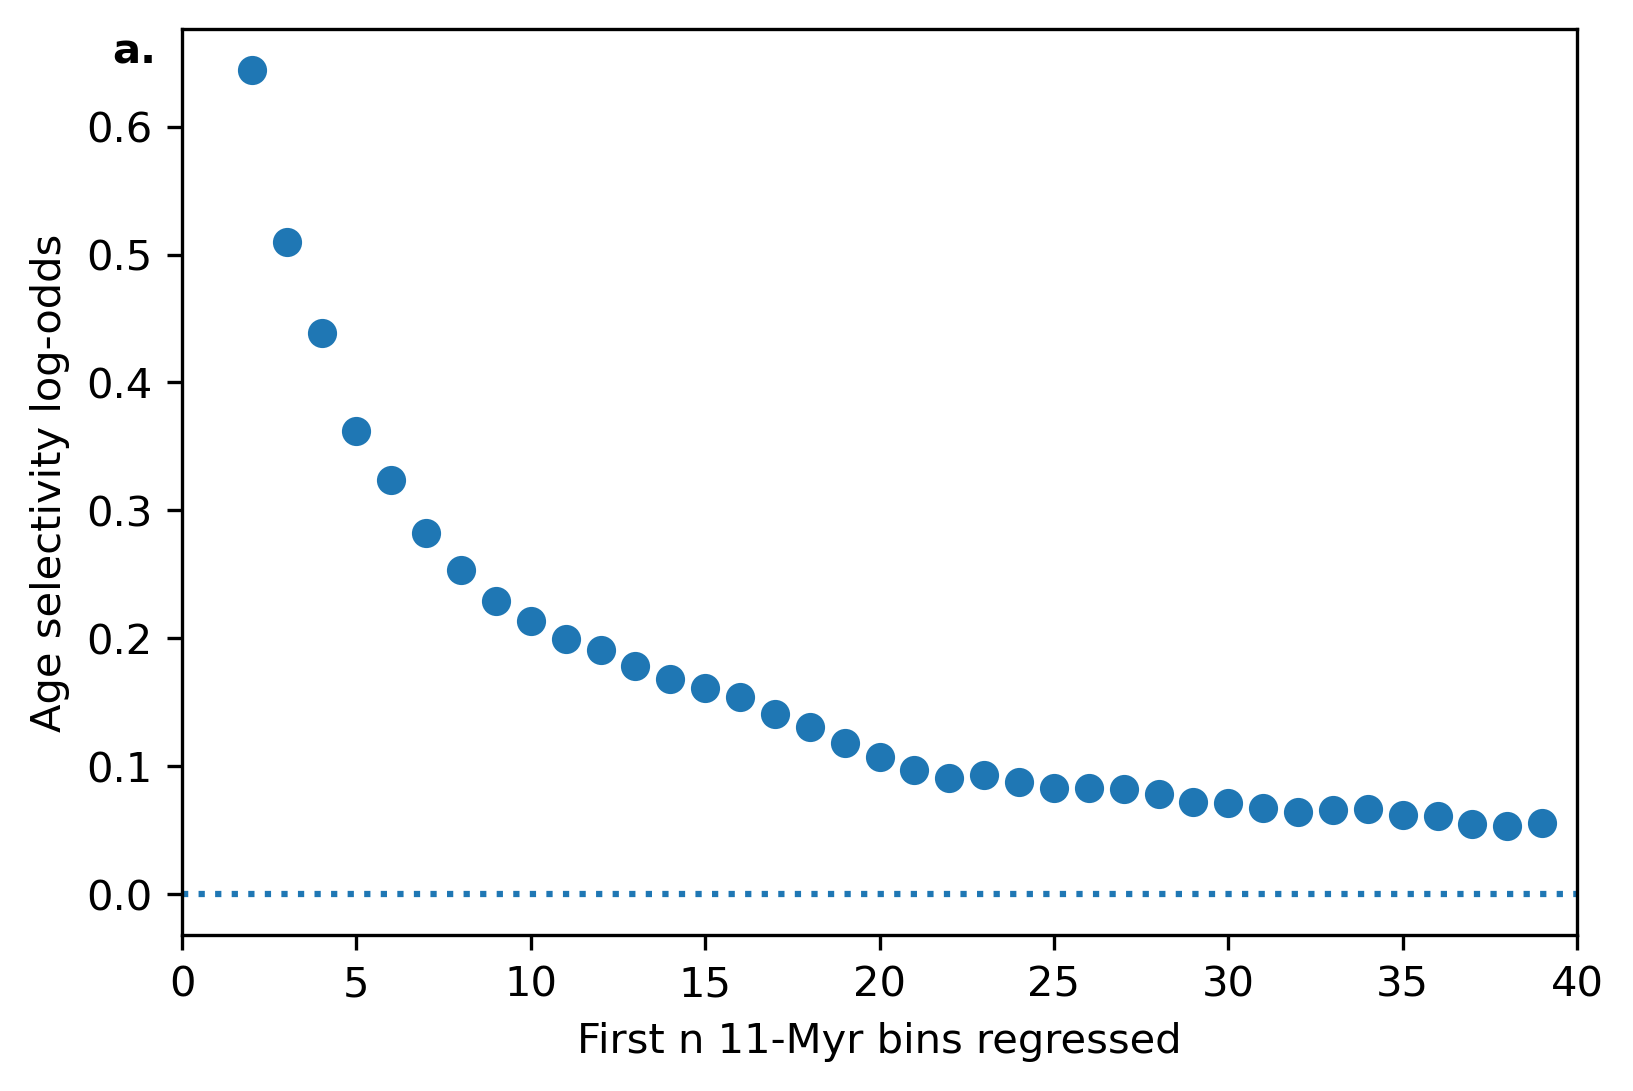

In [27]:
permissiveDurationMatrixMetazoa = getDurationMatrix(subcladeDict, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1, min_unique=False)
plt.hlines([0], 0, 40, linestyle=":")
plt.xlim(0,40)
allOdds = []
for max_age in range(2, 40):
    survDict, tots = getSurvivalsByAge(permissiveDurationMatrixMetazoa, max_age=max_age)
    #print(survDict)
    overallSurvival = list(survDict.values())

    logOdds, survModels, _ = getLogOdds(survDict, permissiveDurationMatrixMetazoa.shape[0], num_bootstraps = 0)
    allOdds.append(np.log(logOdds[0]))
print(allOdds)
xs = np.array(list(range(2,40)))

plt.scatter(xs, allOdds)
#m, t = exponential_fit(xs, allOdds, max(allOdds), 1)
#print(m,t)
#plt.plot(xs, monoExp(xs, m, t), '--', label="fitted")
plt.ylabel("Age selectivity log-odds")
plt.xlabel("First n 11-Myr bins regressed")
plt.text(-5, 0.65, "a.",weight="bold")

[0.30981627425415703, 0.11640965500098255, 0.07381535677369855, 0.02014341305207501, 0.04312375356970244, 0.004587688618353791, 0.01942373893542282, 0.010352442778896354, 0.01922819340148174, 0.008844964151731638, 0.01747489642581268, -0.00611285581442933, 0.005150173621469412, 0.016107623598488274, 0.003116506390173468, -0.032556805322357274, 0.013390475206967123, -0.022698498824380575]
0.6741941343063343 0.7971287539450324


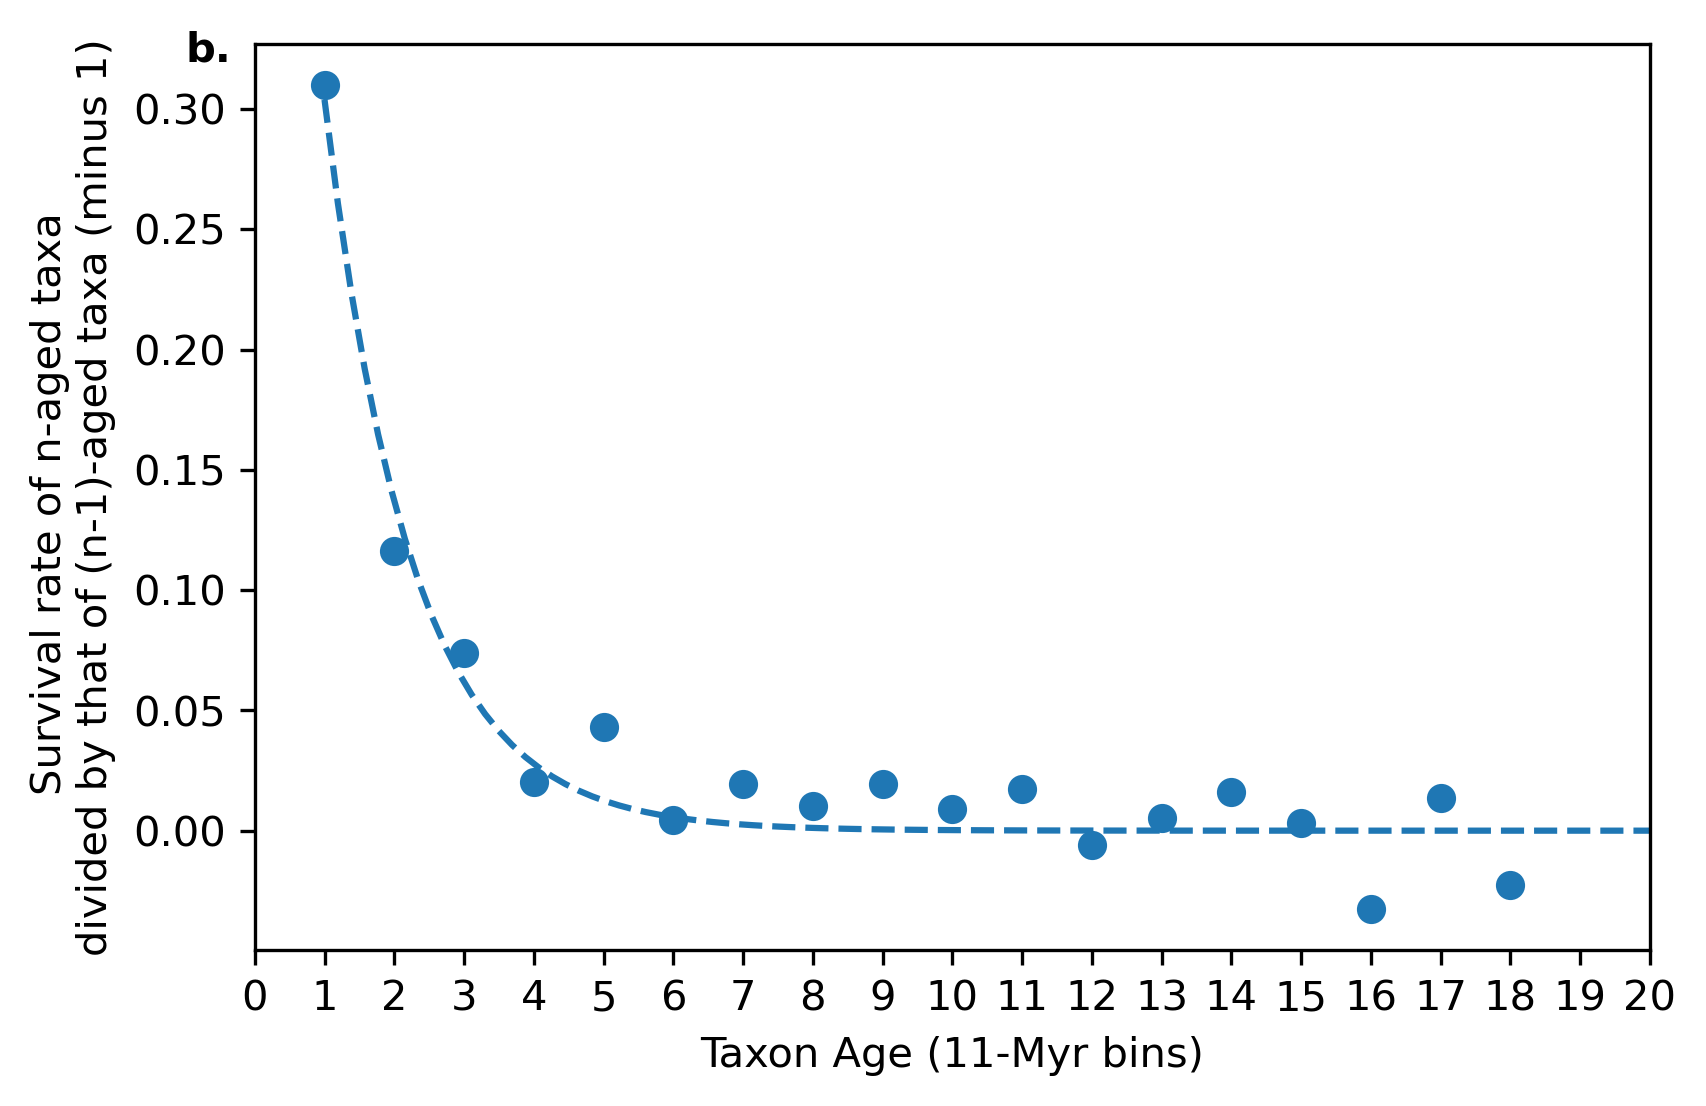

In [31]:
%run "~/persistence/sepkoskiMakerV6.ipynb"
bins_included = 20
permissiveDurationMatrixMetazoa = getDurationMatrix(subcladeDict, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1, min_unique=True)
survDict, counts = getSurvivalsByAge(permissiveDurationMatrixMetazoa, max_age=bins_included)
ratios = []
for max_age in range(2, bins_included):
    ratios.append((survDict[max_age] / survDict[max_age - 1]) - 1)
print(ratios)
plt.scatter(range(1,bins_included-1), ratios)
plt.xlim(0, bins_included)
xs = np.array(list(range(1,bins_included-1)))
m, t = exponential_fit(xs, ratios, max(ratios), 1)
full_xs = np.array(list(range(0,bins_included-1)))
plt.plot(np.linspace(1,bins_included, 100), monoExp(np.linspace(1,bins_included, 100), m, t), '--', label="fitted")
plt.ylabel("Survival rate of n-aged taxa \ndivided by that of (n-1)-aged taxa (minus 1)")
plt.xlabel("Taxon Age (11-Myr bins)")
plt.xticks(range(bins_included+1))
plt.text(-1,0.32,"b.",weight="bold")
print(m,t)

[[33721, 15828, 9963, 6892, 4923, 3556, 2861, 2285, 1886, 1578]]
[1.346931386224066]


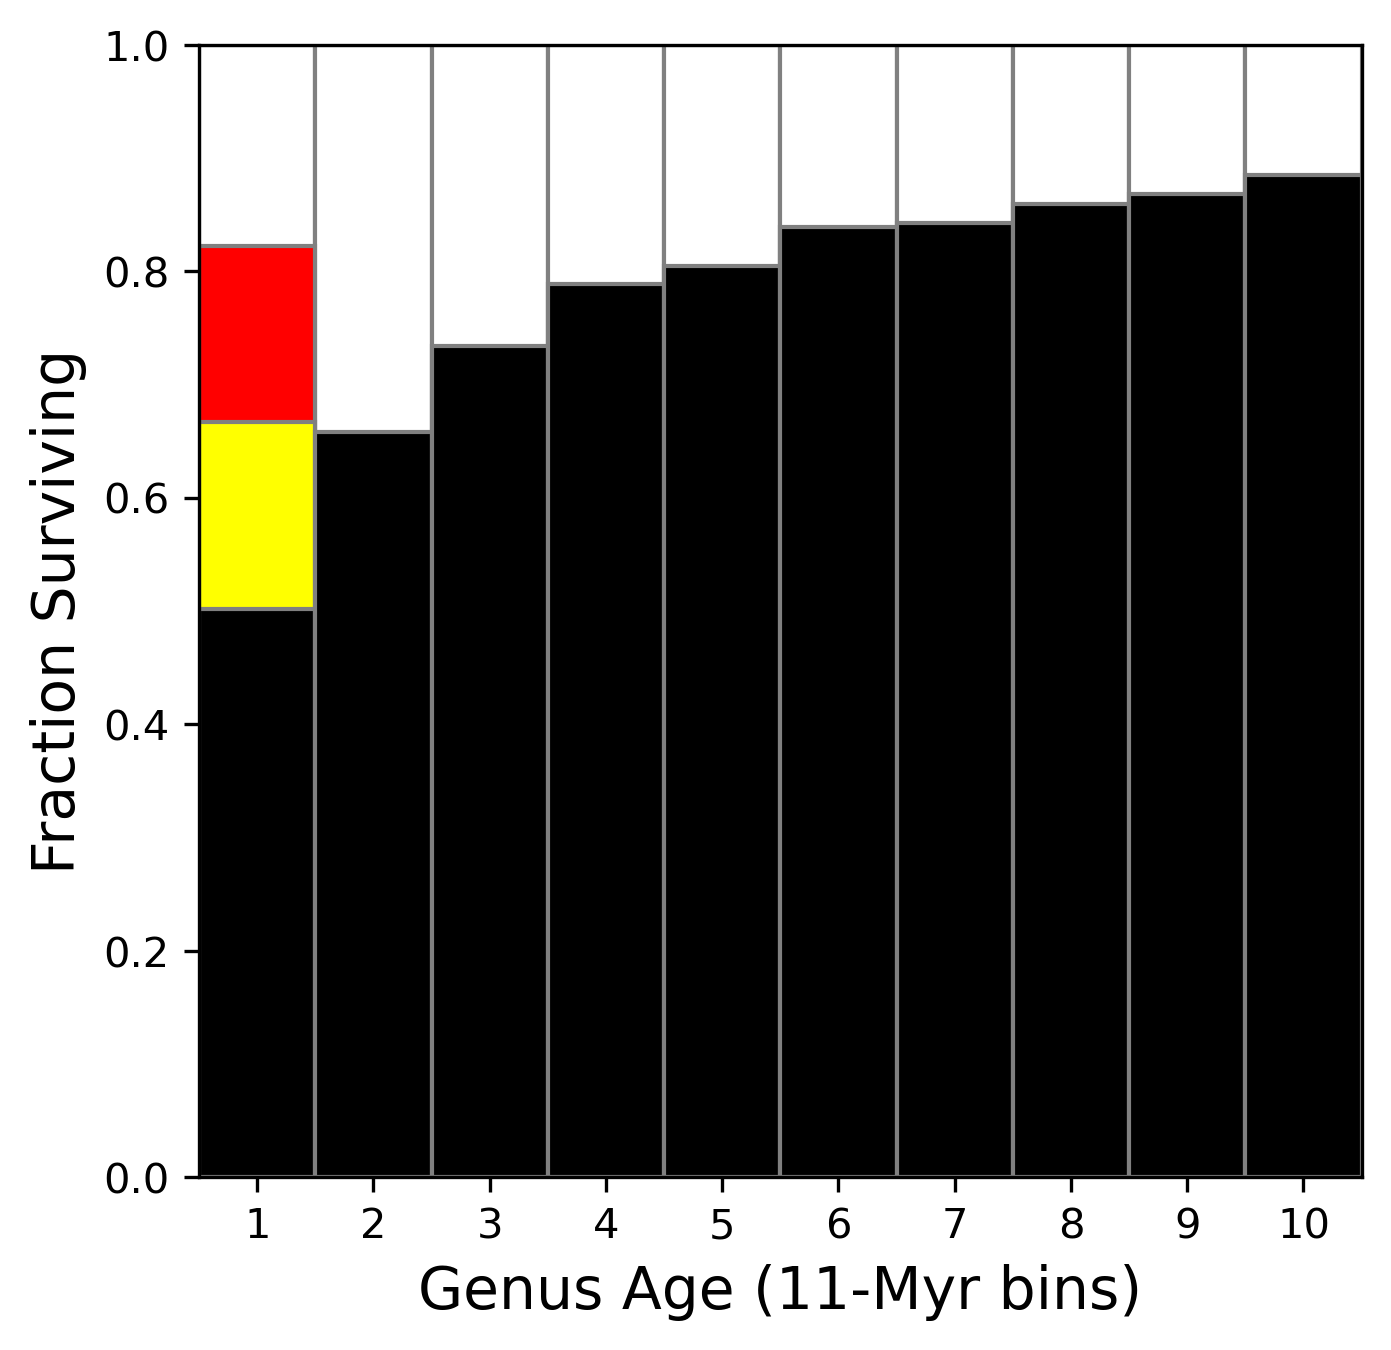

In [34]:
max_age = 10
permissiveDurationMatrixMetazoa = getDurationMatrix(subcladeDict, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1, min_unique=False)
morethan2 = getDurationMatrix(subcladeDict, n_bins=50, t_0=t_0, 
                              max_duration=t_0, min_occurrences=2, min_unique=False)
morethan2unique = getDurationMatrix(subcladeDict, n_bins=50, t_0=t_0, 
                                    max_duration=t_0, min_occurrences=2, min_unique=True)
survDict, counts = getSurvivalsByAge(permissiveDurationMatrixMetazoa, max_age=max_age)
survDict2, _ = getSurvivalsByAge(morethan2, max_age=max_age)
survDict2unique, _ = getSurvivalsByAge(morethan2unique, max_age=max_age)

#print(permissiveDurationMatrixMetazoa.shape)
#print(logOdds, survModels)
overallSurvival = list(survDict.values())
overallSurvival2 = list(survDict2.values())
overallSurvival2unique = list(survDict2unique.values())

print(counts)

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=max_age, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11-Myr bins)", fontsize=14)
ax.set_ylabel("Fraction Surviving", fontsize=14)
ax.set_ylim(0,1)
ax.set_xlim(0.5, max_age + 0.5)
ax.bar(range(1, max_age + 1), [1]*max_age,color='white', edgecolor='gray', width=1)

ax.bar([1], overallSurvival2unique[0], color='red', edgecolor='gray', width=1)
ax.bar([1], overallSurvival2[0], color='yellow', edgecolor='gray', width=1)
ax.bar(range(1, max_age + 1), overallSurvival, color='black', edgecolor='gray', width=1)
#ax.bar([1], overallSurvival[0], color='green', edgecolor='gray', width=1)


logOdds, survModels, _ = getLogOdds(survDict, permissiveDurationMatrixMetazoa.shape[0], num_bootstraps = 0, count_by_bin=counts)
print(logOdds)
#ax.plot(range(1, max_age + 1), survModels[0].predict(np.array(list(range(0, max_age))).reshape(-1, 1)), color="gray", linewidth=3)

In [24]:
LIPs = [(16.65,15.9),(28.9,23.75),(60.1,54.9),(66.36,65.59),(90,84),(95,83),(118.9,109.9),
        (118,115.3),(125,119),(132,95),(135,75),(135,131.5),(137,130),(137,130),(140,130),
        (183.25,182.43),(188,153), (201.64, 200.92), (252.24, 251.35), (259.9,259.51),
        (287,275),(292.4,288),(302,292),(320,280),(376.7,364.4),(378.64,364), (450,444),
        (508,498.3),(512.8,509),(539,530), (560,550),(560,550),(592,588),(615,610),(719.47,716.33)]

In [54]:
supercladeDictMetazoa = getSubcladeOccurences("Metazoa", resolution="family",
                                              environment_only="marine")

permissiveDurationMatrixMetazoaFam = getDurationMatrix(supercladeDictMetazoa, n_bins=50, t_0=t_0, 
                                                       max_duration=t_0, min_occurrences=1)
survDict, tots = getSurvivalsByAge(permissiveDurationMatrixMetazoaFam, max_age=20)
overallSurvival = list(survDict.values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Family Age (11 Ma bins)", fontsize=14)
ax.set_ylabel("Fraction Surviving", fontsize=14)
ax.set_ylim(0,1)
ax.set_xlim(0.5, 20 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

logOdds, survModels, _ = getLogOdds(survDict, permissiveDurationMatrixMetazoaFam.shape[0], num_bootstraps = 0)
print(logOdds)
ax.plot(range(1, 20 + 1), survModels[0].predict(np.array(list(range(0, 20))).reshape(-1, 1)), color="gray", linewidth=3)

Local save of requested search found.



KeyboardInterrupt: 

Time bin: 0 / 1
[1.057953112763164]


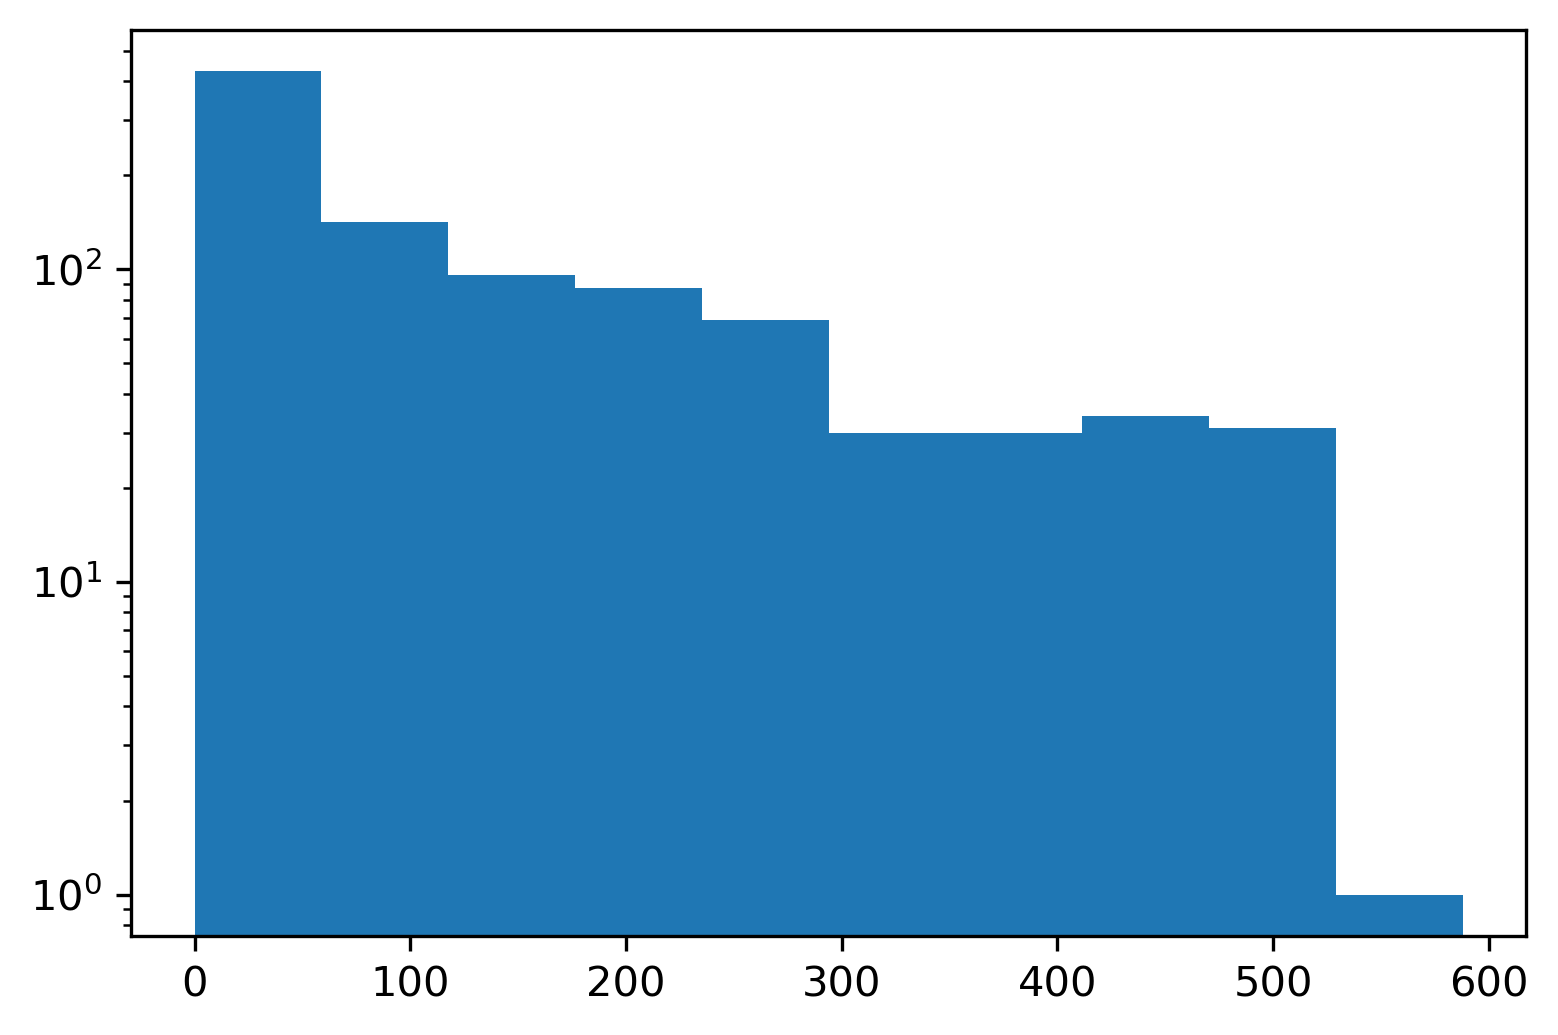

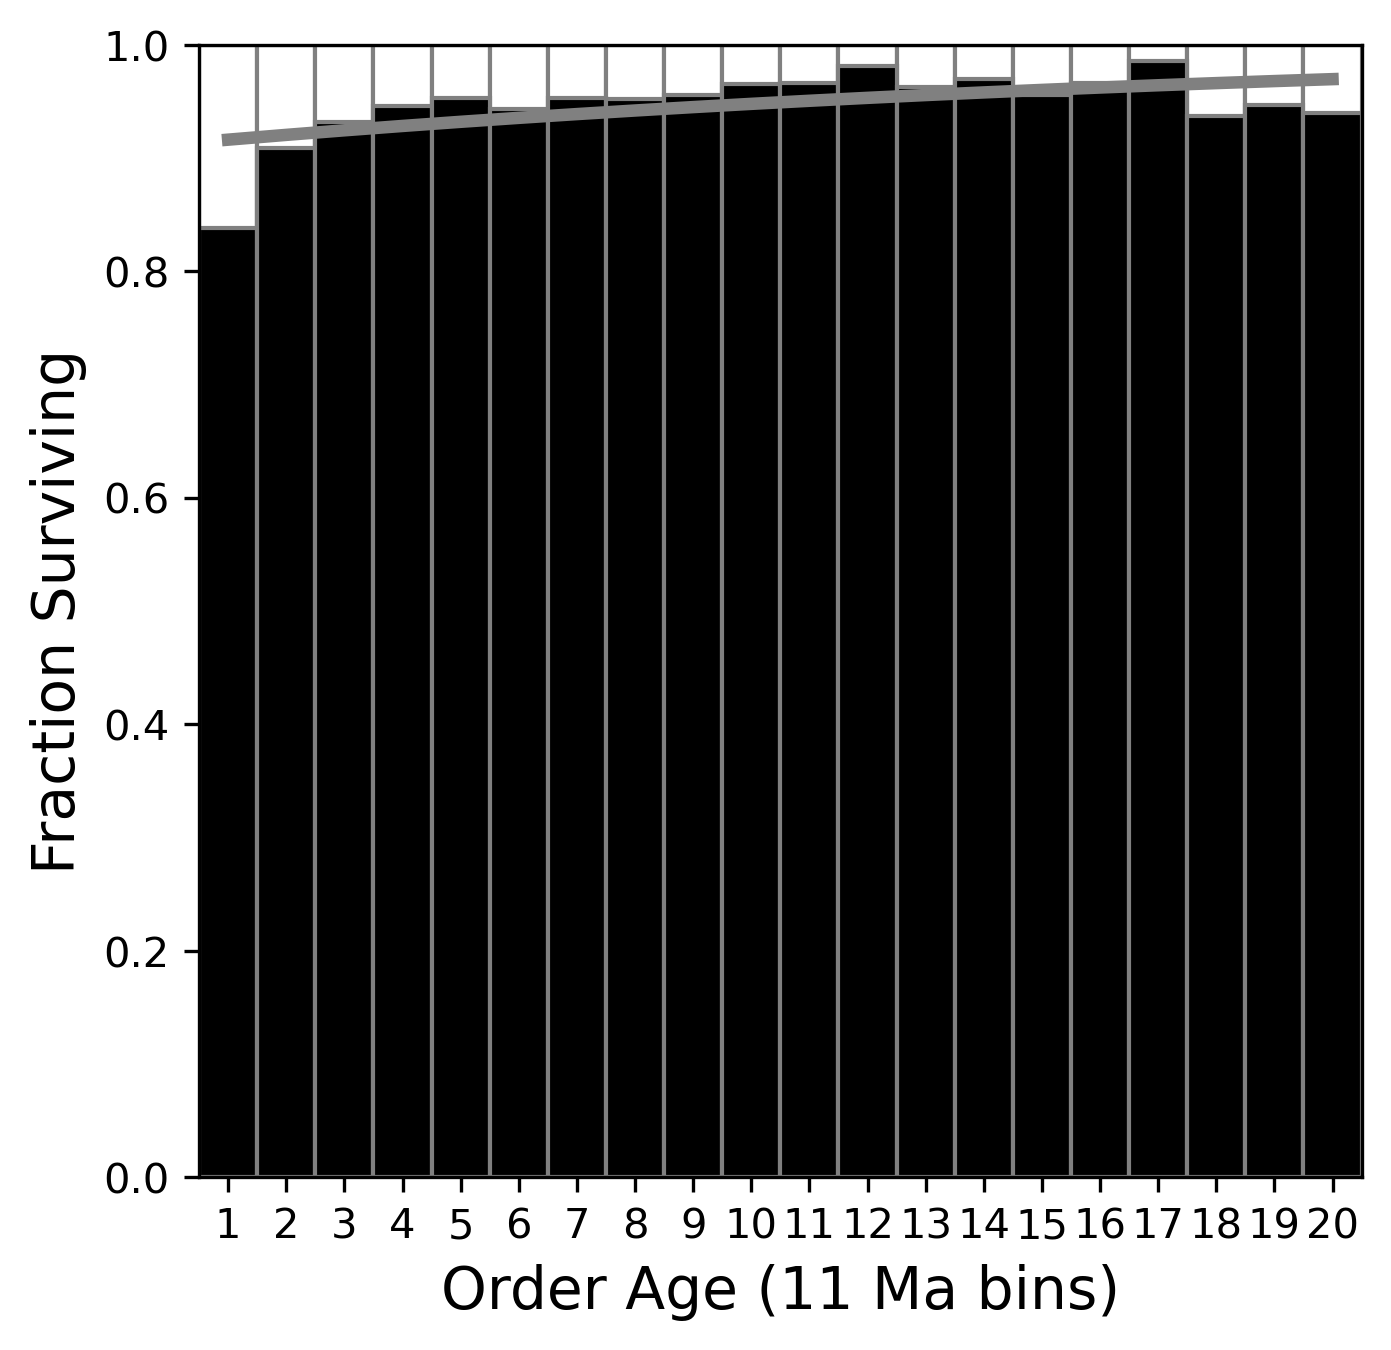

In [55]:
superdupercladeDictMetazoa = getSubcladeOccurences("Metazoa", resolution="order",
                                                   environment_only="marine")
permissiveDurationMatrixMetazoaOrd = getDurationMatrix(superdupercladeDictMetazoa, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
survDict = getSurvivalsByAge(permissiveDurationMatrixMetazoaOrd, max_age=20)
overallSurvival = list(survDict.values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Order Age (11 Ma bins)", fontsize=14)
ax.set_ylabel("Fraction Surviving", fontsize=14)
ax.set_ylim(0,1)
ax.set_xlim(0.5, 20 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

logOdds, survModels, _ = getLogOdds(survDict, permissiveDurationMatrixMetazoaOrd.shape[0], num_bootstraps = 0)
print(logOdds)
ax.plot(range(1, 20 + 1), survModels[0].predict(np.array(list(range(0, 20))).reshape(-1, 1)), color="gray", linewidth=3)

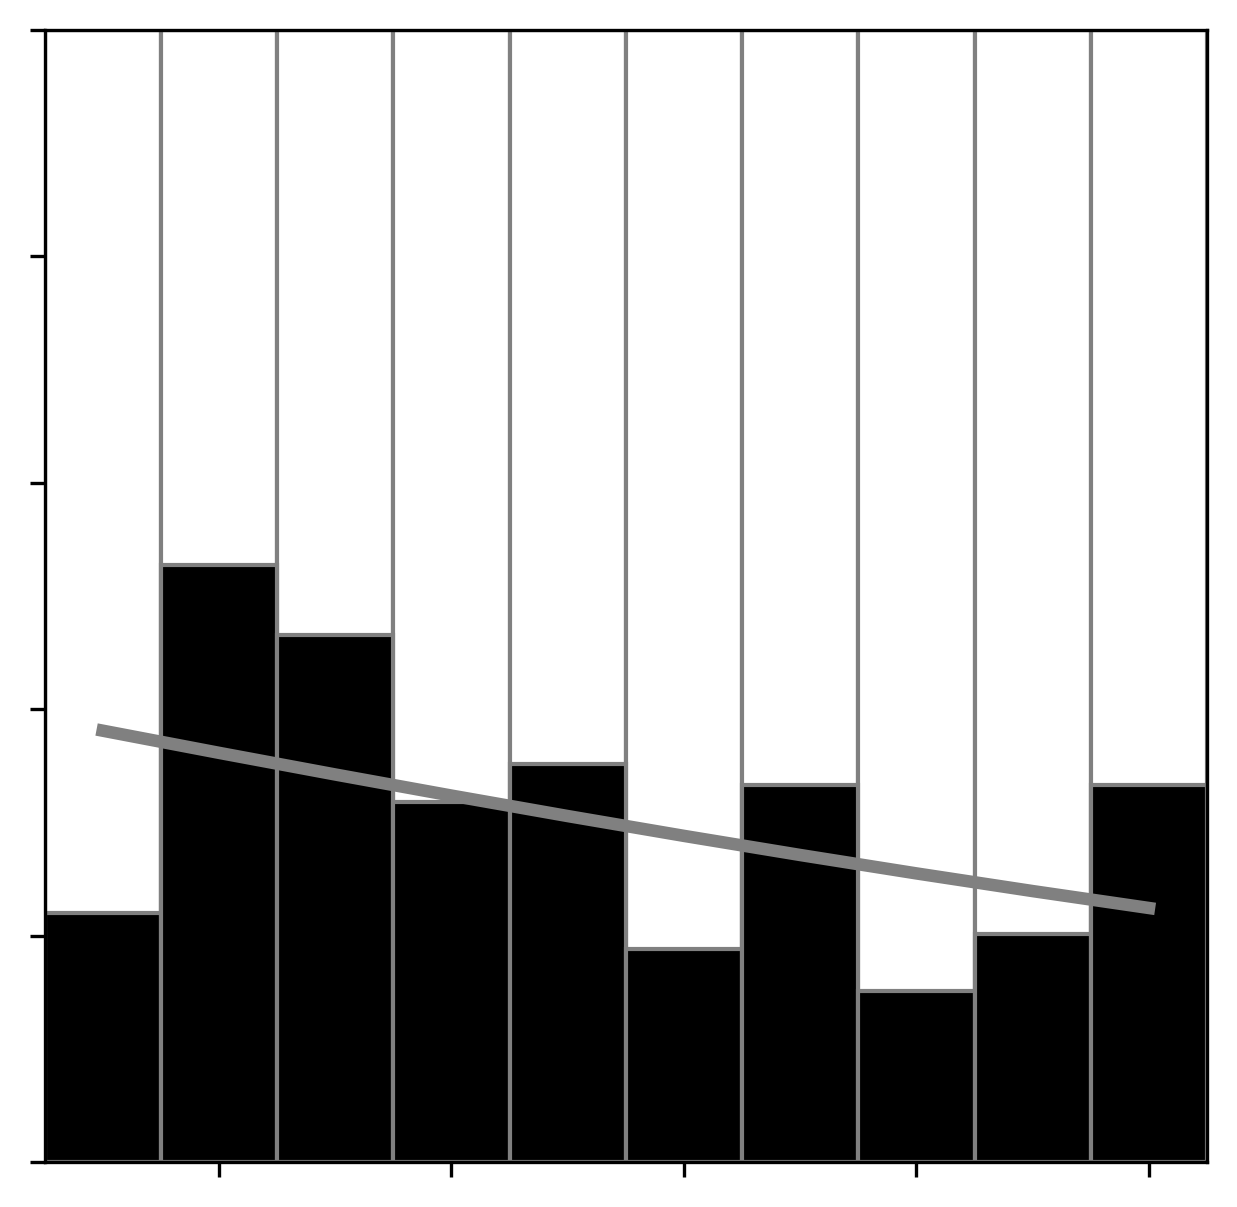

In [173]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
examples = [53, 53]
test_bin = 53 #np.random.randint(bins)
#ax.set_xlabel("Age (5.5 Ma bins)", fontsize=14)
#ax.set_ylabel("Fraction Surviving", fontsize=14)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_ylim(0,1)
ax.set_xlim(0.5, tail_length + 0.5)
ax.bar(range(1, tail_length + 1), [1]*tail_length,color='white', edgecolor='gray', width=1)
ax.bar(range(1, tail_length + 1), survivalMatrixMetazoa[:, test_bin], color='black', edgecolor='gray', width=1)

#print("log-odds:", np.log(np.e ** models[test_bin].coef_[0][0]))
#ax.text(10, 0.05, str(t_0 - (bin_size * (test_bin + 1))) + " Ma", color="red", horizontalalignment="right")
#ax.text(10, 0.25, round(np.log(np.e ** models[test_bin].coef_[0][0]), 3), color="red", horizontalalignment="right")
ax.plot(range(1, tail_length + 1), models[test_bin].predict(np.array(list(range(0, tail_length))).reshape(-1, 1)), color="gray", linewidth=3)

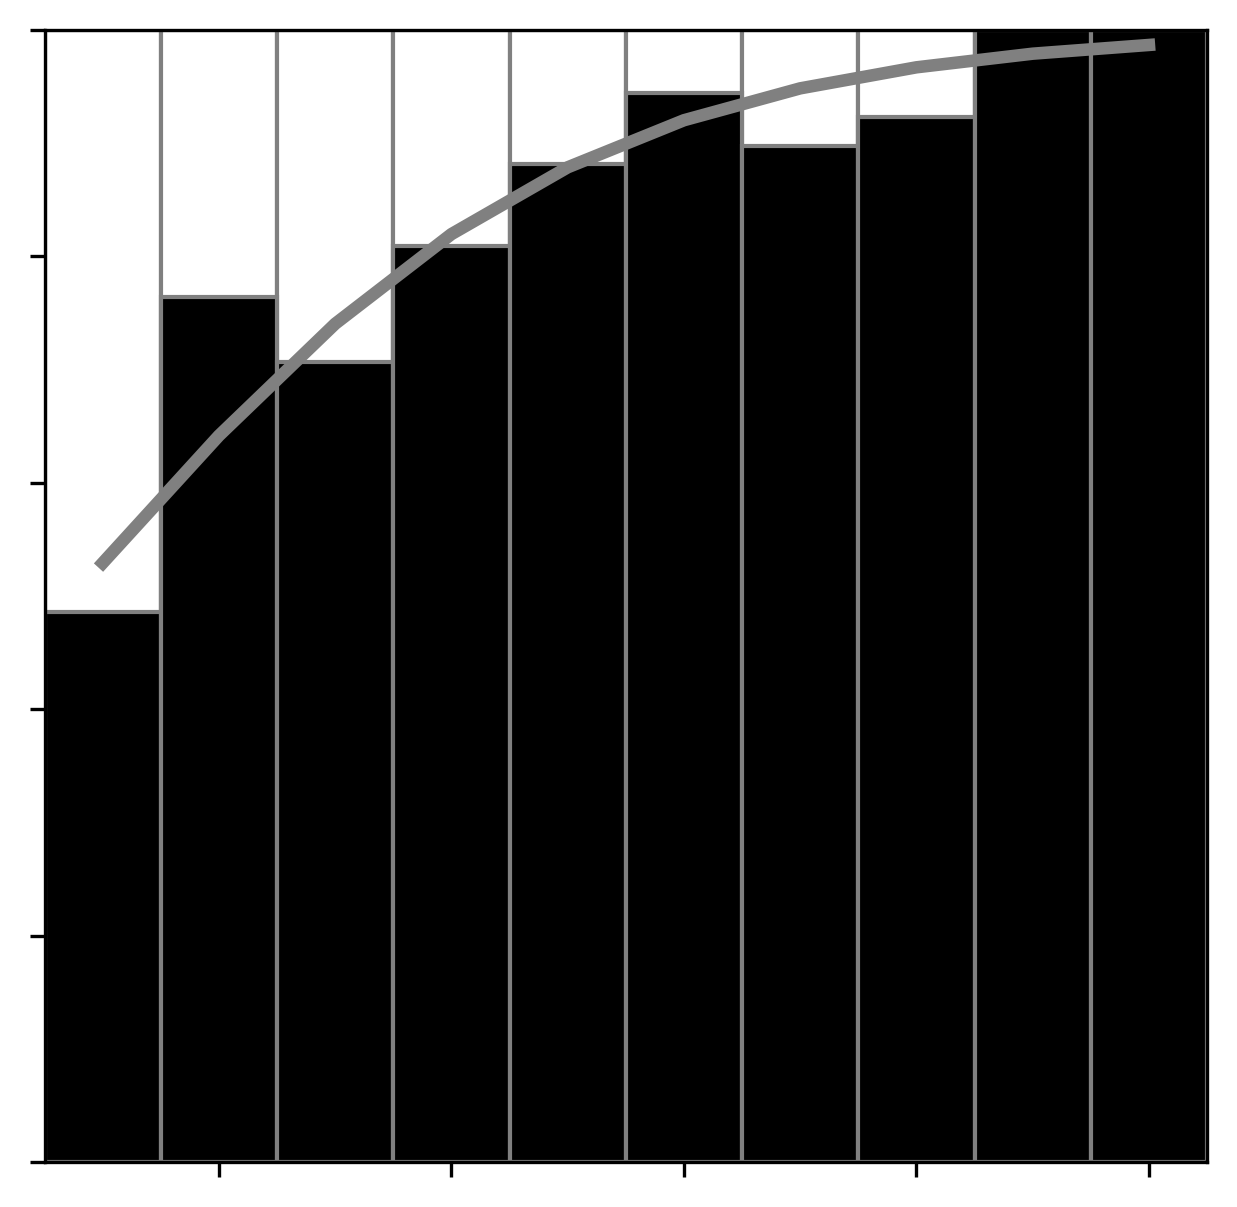

In [174]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
test_bin = 41 #np.random.randint(bins)
#ax.set_xlabel("Age (5.5 Ma bins)", fontsize=14)
#ax.set_ylabel("Fraction Surviving", fontsize=14)
#ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.set_ylim(0,1)
ax.set_xlim(0.5, tail_length + 0.5)
ax.bar(range(1, tail_length + 1), [1]*tail_length,color='white', edgecolor='gray', width=1)
ax.bar(range(1, tail_length + 1), survivalMatrixMetazoa[:, test_bin], color='black', edgecolor='gray', width=1)
#print("log-odds:", np.log(np.e ** models[test_bin].coef_[0][0]))
#ax.text(10, 0.05, str(t_0 - (bin_size * (test_bin + 1))) + " Ma", color="red", horizontalalignment="right")
#ax.text(10, 0.25, round(np.log(np.e ** models[test_bin].coef_[0][0]), 3), color="red", horizontalalignment="right")
ax.plot(range(1, tail_length + 1), models[test_bin].predict(np.array(list(range(0, tail_length))).reshape(-1, 1)), color="gray", linewidth=3)

40483 young families 16814 mid families and 32088 old families
[(20,), (20,), (20,)]
[452, 245, 264, 265, 276, 83, 84, 61, 47, 45, 36, 40, 18, 36, 42, 20, 8, 32, 15]


<BarContainer object of 20 artists>

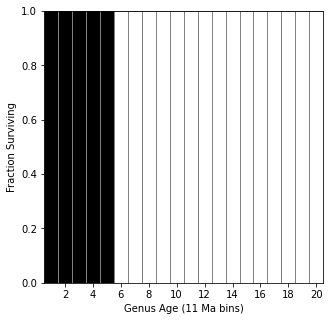

In [77]:
permissiveDurationMatrixMetazoa, subLabels = getDurationMatrix(subcladeDictMetazoa, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1,
                                                    return_labels=True)
permissiveDurationMatrixMetazoaSuper, superLabels = getDurationMatrix(supercladeDictMetazoa, n_bins=50, t_0=t_0, 
                                                         max_duration=t_0, min_occurrences=1,
                                                         return_labels = True)

survivalMatrices, tot_lists = getSurvivalMatrix(permissiveDurationMatrixMetazoa, max_tail=20, min_per_bin=3, 
                                     taxDict=taxDictFamily, supercladeDurationMatrix=permissiveDurationMatrixMetazoaSuper, 
                                     taxon_labels=subLabels, super_labels=superLabels, proportions=False)
overallSurvivalMatrices = [np.sum(x, axis=1) for x in survivalMatrices]
#overallSurvivalMatrices_fractions = [survivalMatrices[i] / tot_list[i] for i in range(3)]
print([x.shape for x in overallSurvivalMatrices])
print(tot_lists)
#survDict = getSurvivalsByAge(permissiveDurationMatrixMetazoa, max_age=20)
#logOdds, survModels = getLogOdds(survDict, max_p=max_p, min_p=min_p)
#print(logOdds, survModels)
#overallSurvival = list(survDict.values())

fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 20 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvivalMatrices[0], color='black', edgecolor='gray', width=1)
#ax.plot(range(1, 20 + 1), survModels[0].predict(np.array(list(range(0, 20))).reshape(-1, 1)), color="gray", linewidth=3)

Local save of requested search found.

12740 unique subclades (['genus']) found
10544 subclades with multiple occurences
8782 subclades with multiple unique occurences
7756 subclades with at least 5 occurences


<ipython-input-1-76b0b2457abf>:162: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


TypeError: unsupported operand type(s) for -: 'str' and 'str'

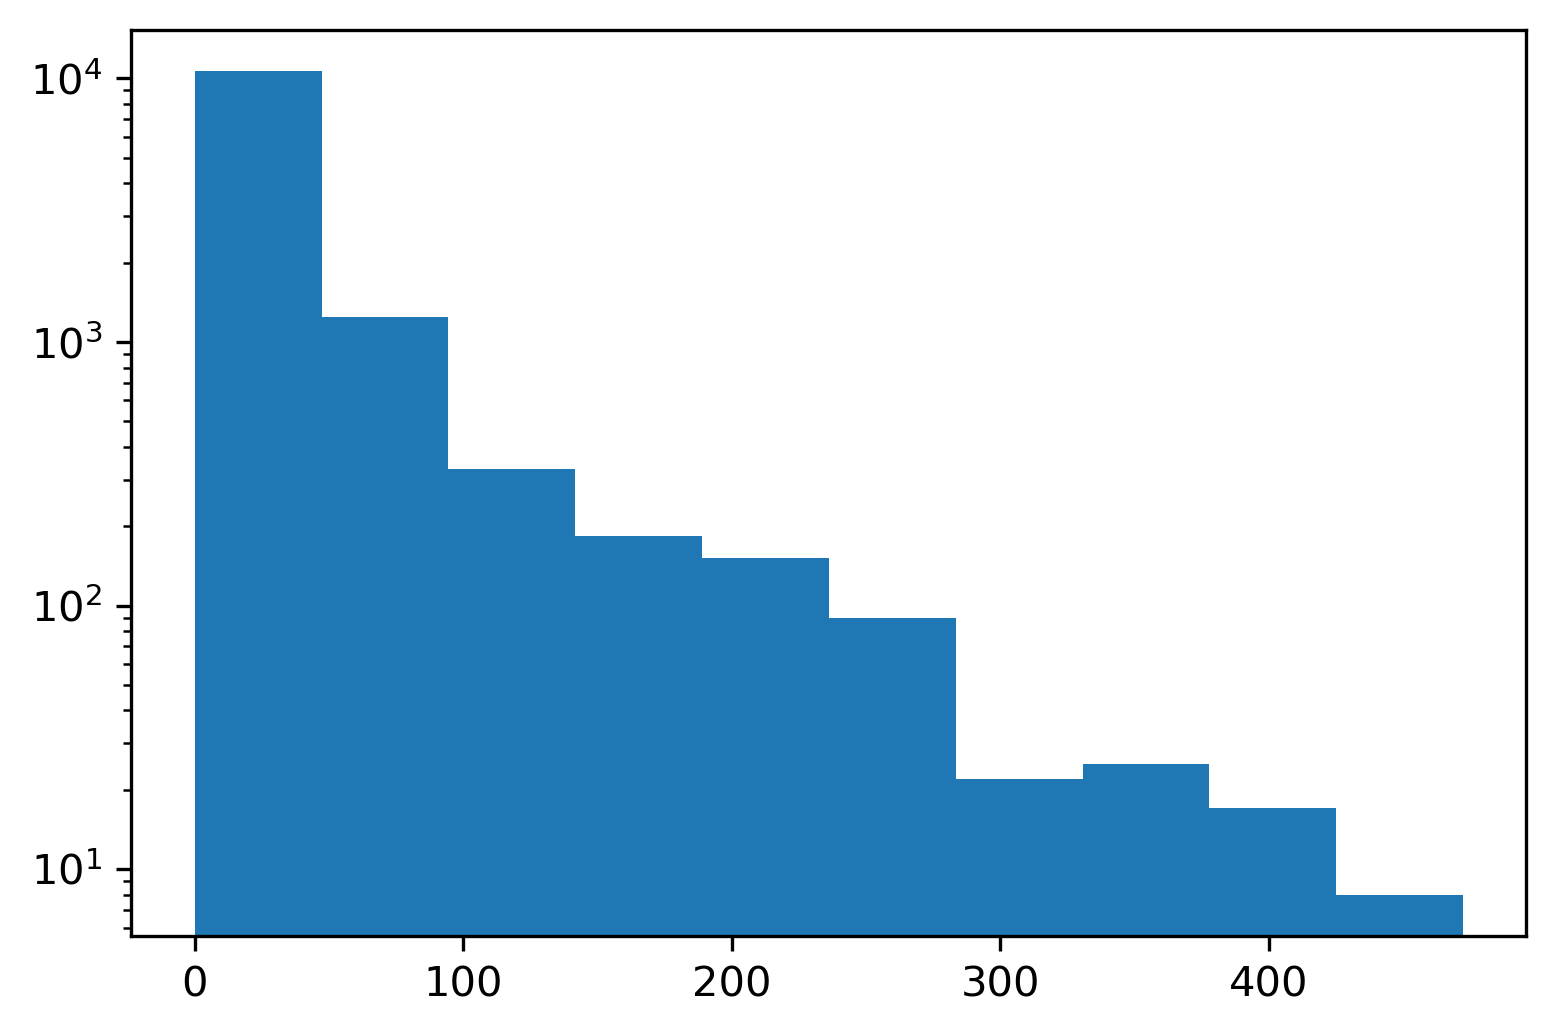

In [17]:
subcladeDictMollusca = getSubcladeOccurences("Mollusca", resolution=subclade_resolution, 
                                             environment_only="marine")
permissiveDurationMatrixMollusca = getDurationMatrix(subcladeDictMollusca, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
_, overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixMollusca, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

818 unique subclades (genus) found
717 subclades with multiple occurences
615 subclades with multiple unique occurences
575 subclades with at least 5 occurences


<ipython-input-3-8e4a6b8e57e8>:154: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


<BarContainer object of 20 artists>

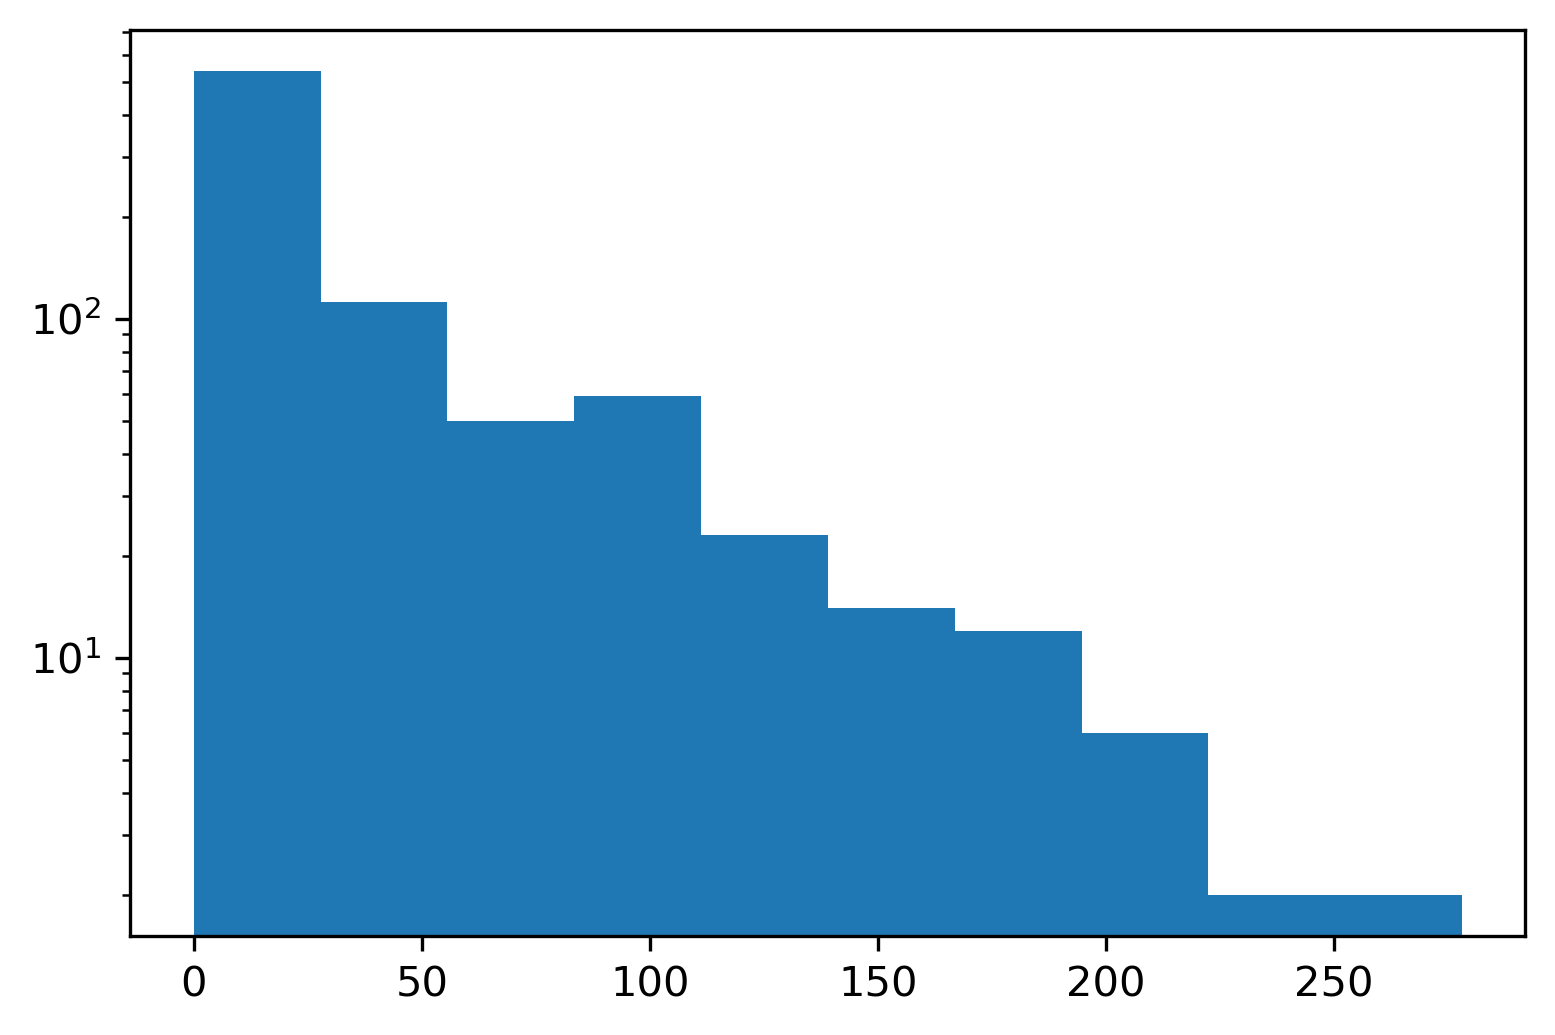

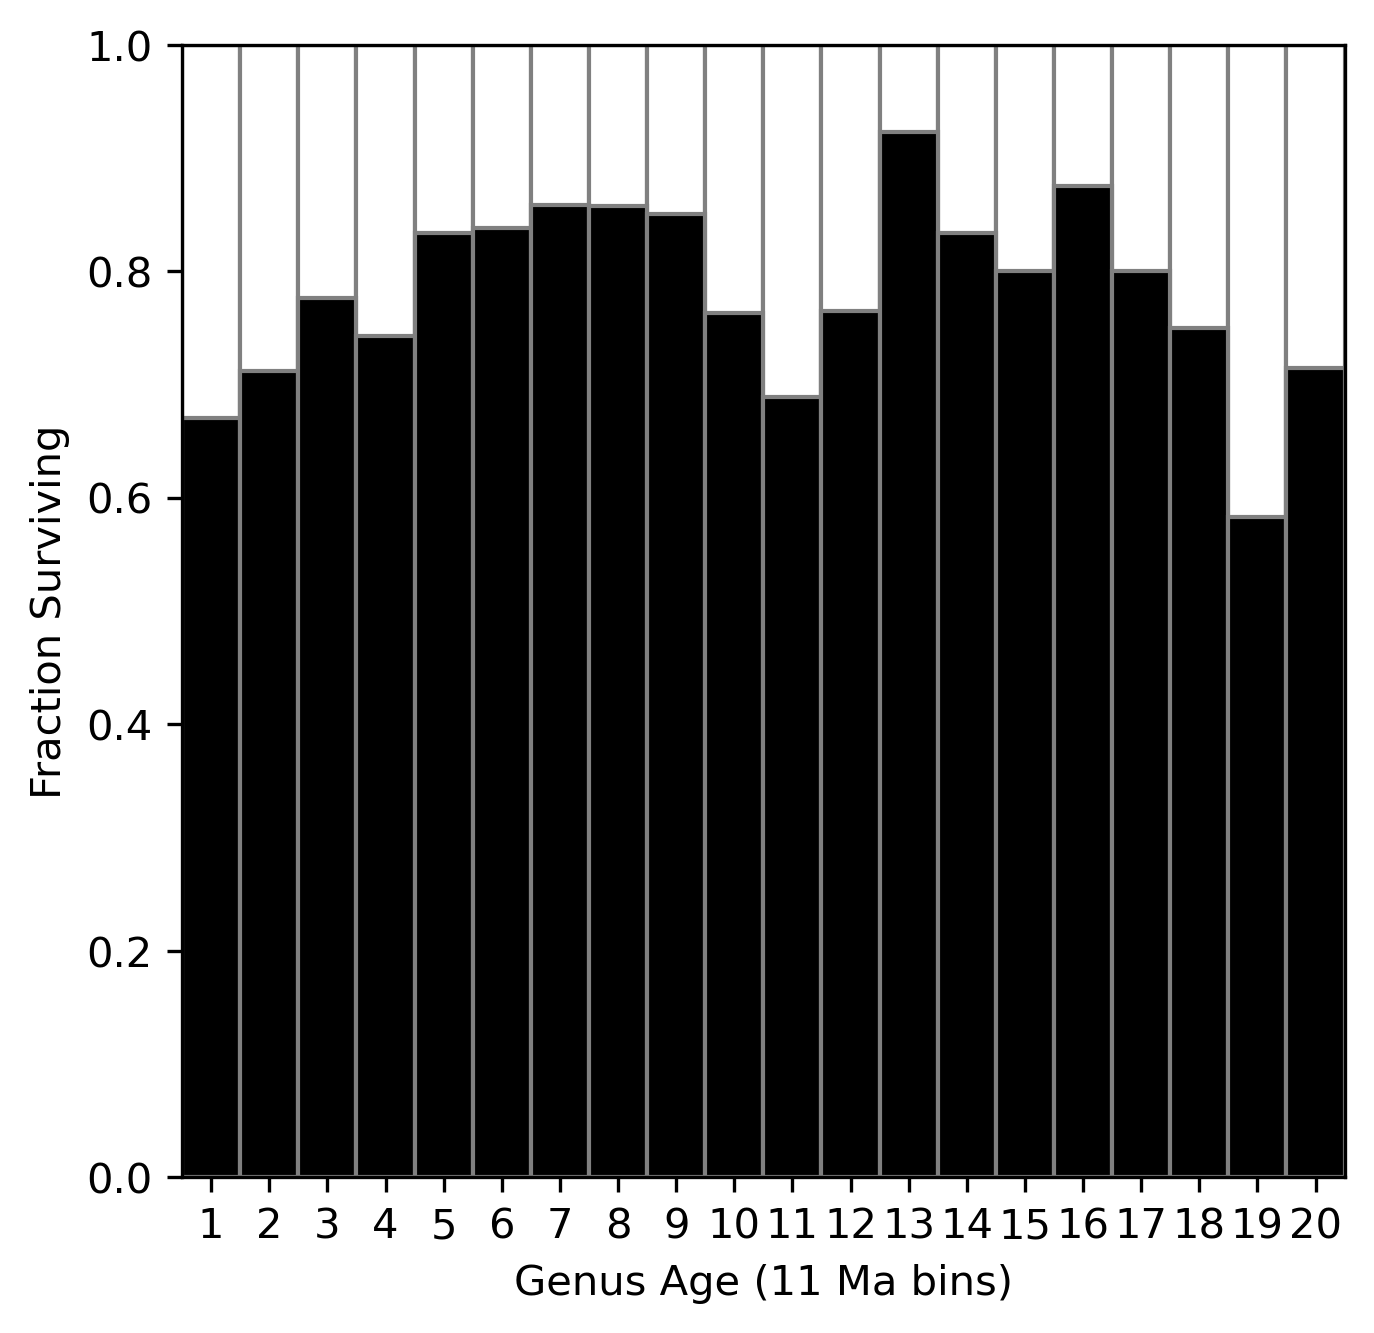

In [64]:
subcladeDictBrach = getSubcladeOccurences("Radiolaria", resolution=subclade_resolution) 
                                             #environment_only="marine")
permissiveDurationMatrixBrach = getDurationMatrix(subcladeDictBrach, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixBrach, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 20 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

No local save of requested search found. Downloading from PBDB.
Search results saved to /home/parsonsc/persistence/Chordata.csv

16664 unique subclades (genus) found
10368 subclades with multiple occurences
7935 subclades with multiple unique occurences
6013 subclades with at least 5 occurences


<ipython-input-3-8e4a6b8e57e8>:154: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


<BarContainer object of 20 artists>

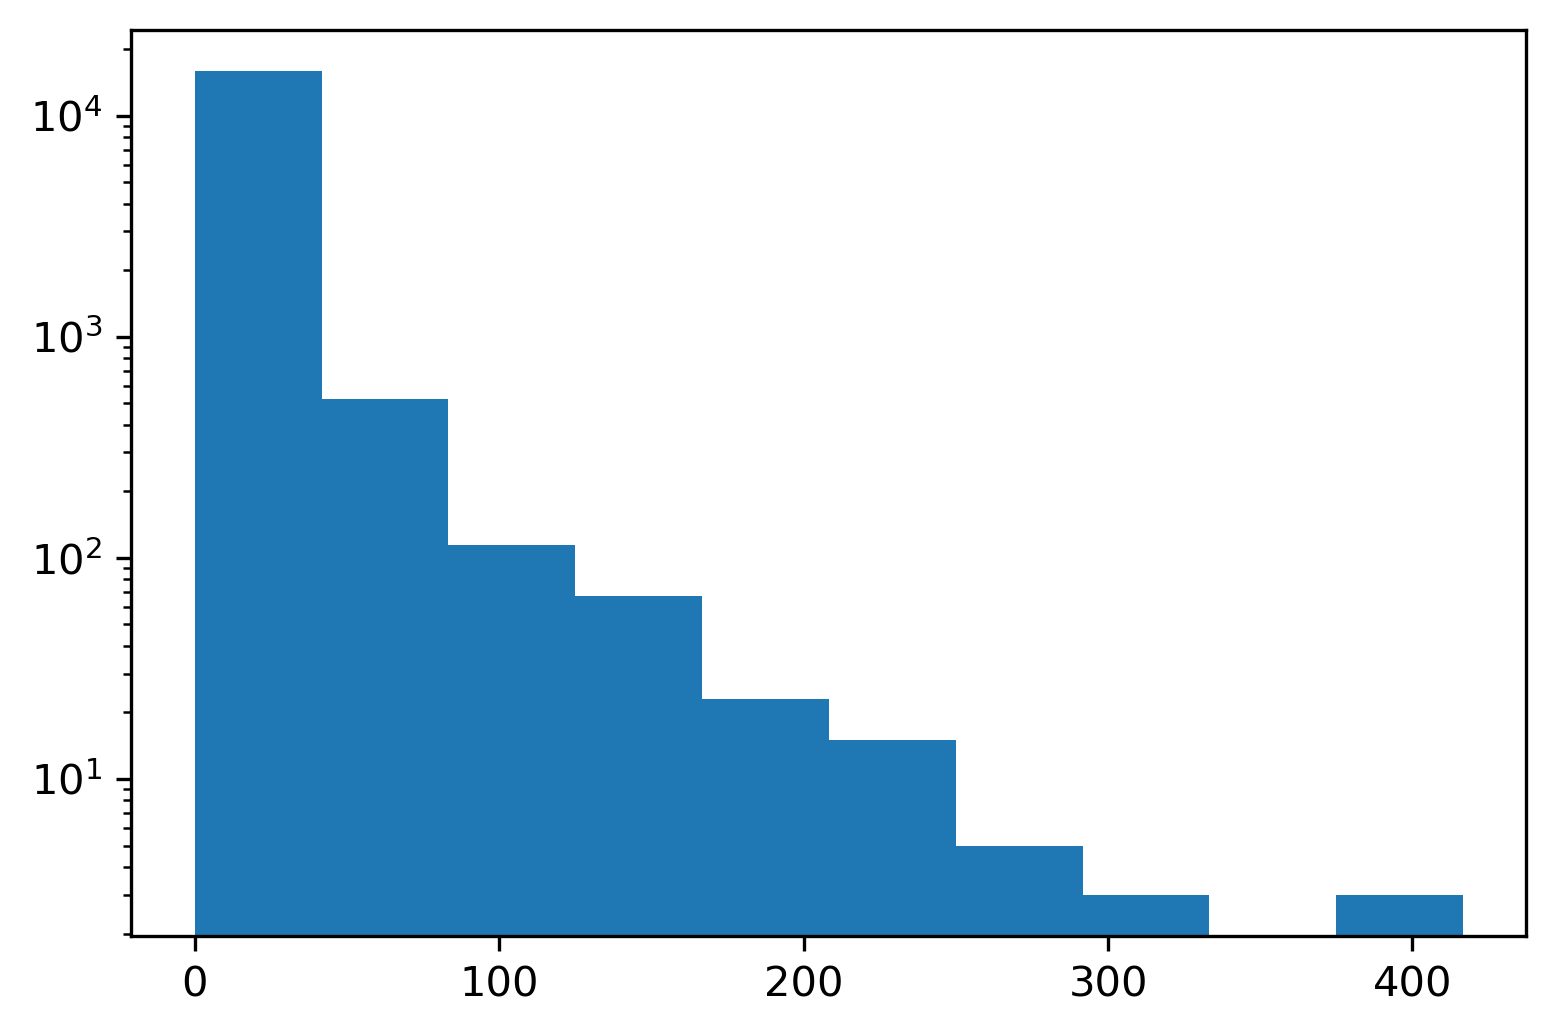

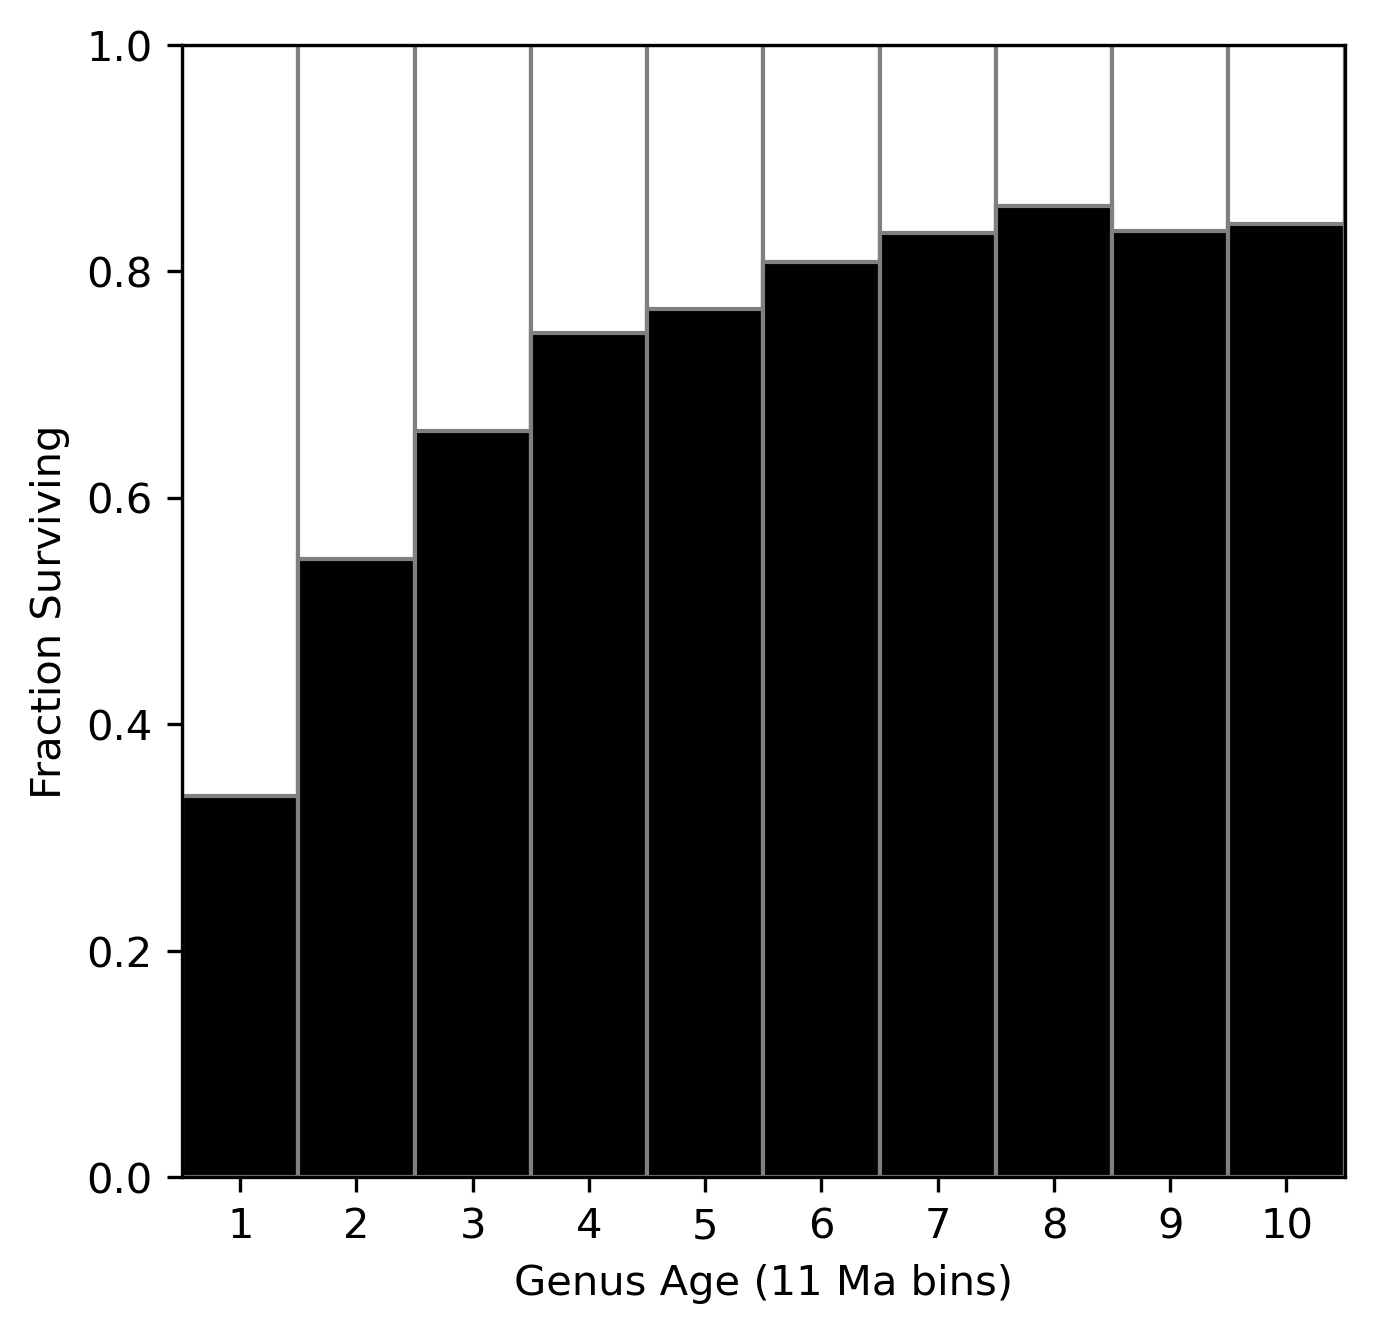

In [101]:
subcladeDictVert = getSubcladeOccurences("Chordata", resolution=subclade_resolution)
permissiveDurationMatrixVert = getDurationMatrix(subcladeDictVert, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixVert, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

2683 unique subclades (['genus']) found
2204 subclades with multiple occurences
1638 subclades with multiple unique occurences
1501 subclades with at least 5 occurences


<ipython-input-1-76b0b2457abf>:162: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


TypeError: unsupported operand type(s) for -: 'str' and 'str'

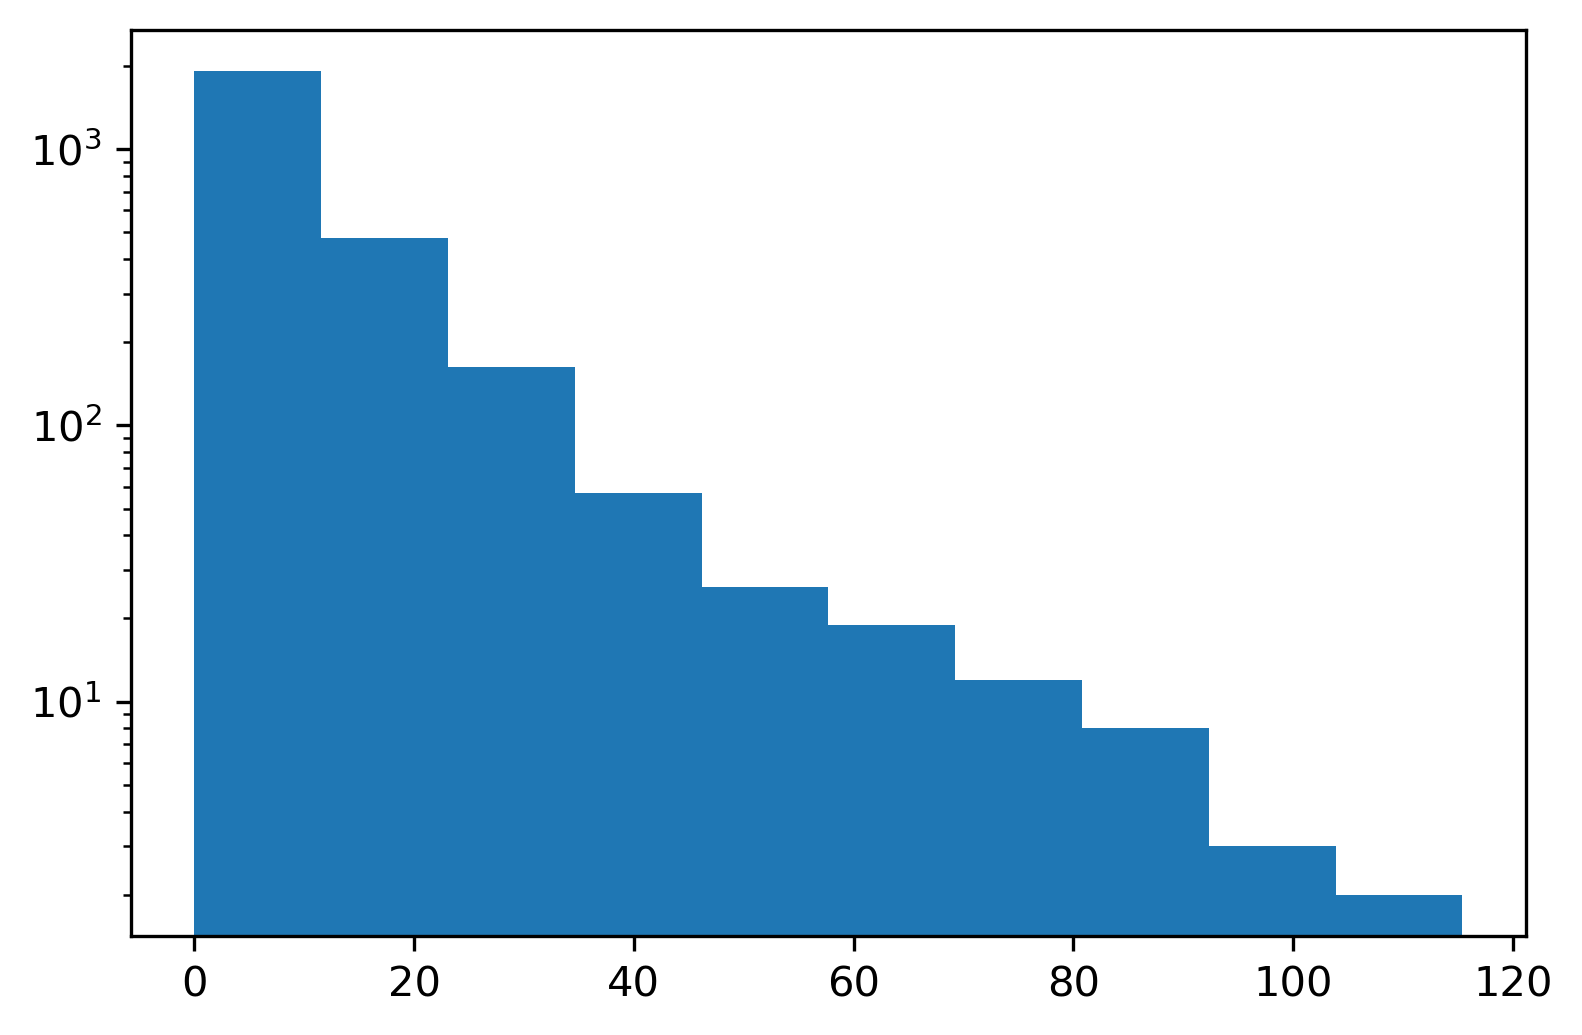

In [15]:
subcladeDictTril = getSubcladeOccurences("Trilobita", resolution=subclade_resolution)
permissiveDurationMatrixTril = getDurationMatrix(subcladeDictTril, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixTril, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

13028 unique subclades (['genus']) found
10761 subclades with multiple occurences
8987 subclades with multiple unique occurences
7925 subclades with at least 5 occurences


<ipython-input-1-76b0b2457abf>:162: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


<BarContainer object of 20 artists>

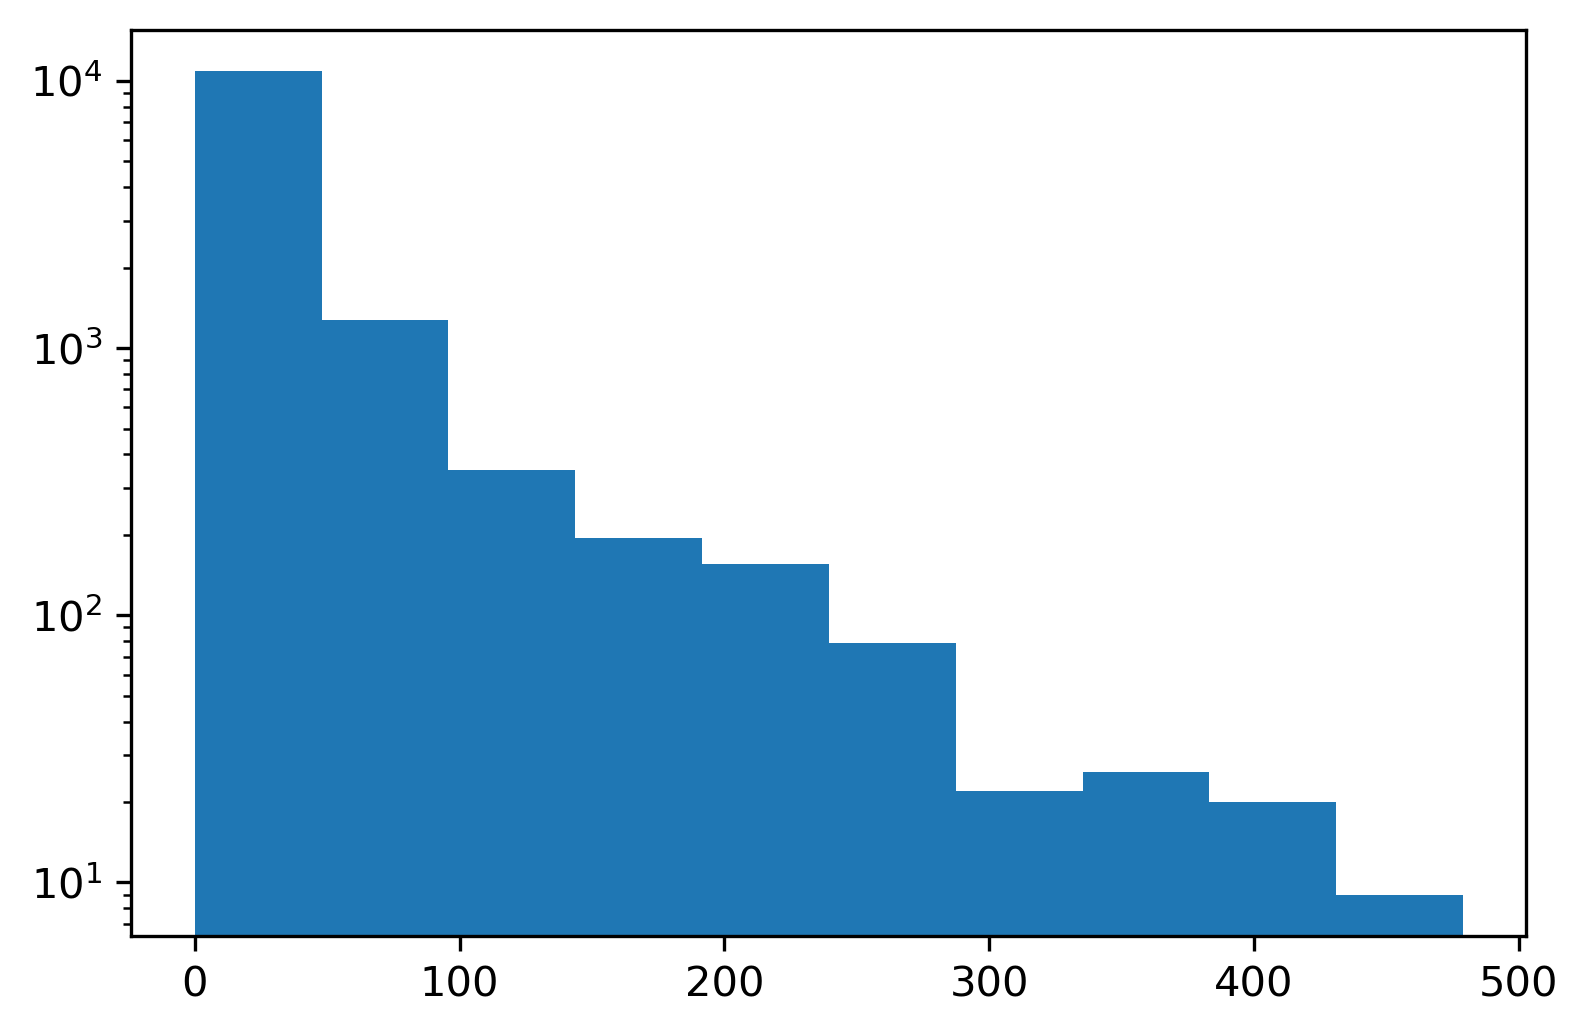

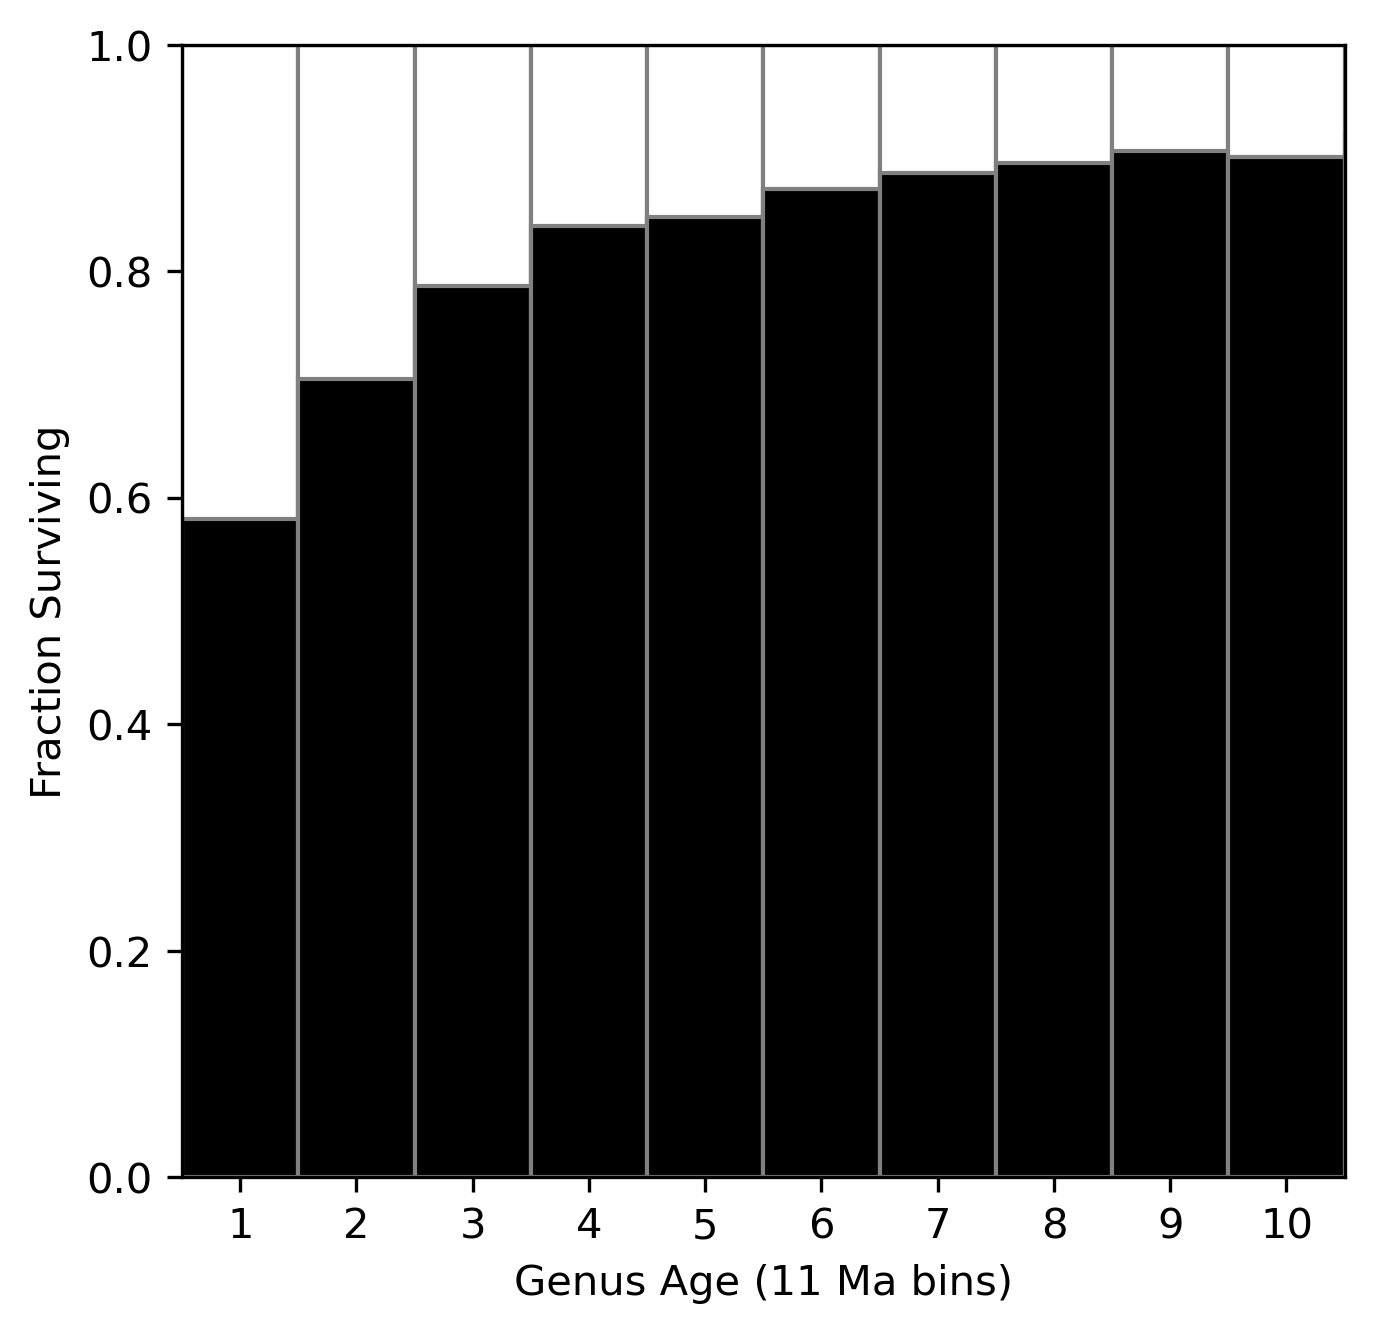

In [21]:
subcladeDictCeph = getSubcladeOccurences("Mollusca", resolution=subclade_resolution)[subclade_resolution]
permissiveDurationMatrixCeph = getDurationMatrix(subcladeDictCeph, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival, _ = getSurvivalsByAge(permissiveDurationMatrixCeph, max_age=20)
overallSurvival = list(overallSurvival.values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

3142 unique subclades (genus) found
2729 subclades with multiple occurences
2091 subclades with at least 5 occurences


<BarContainer object of 20 artists>

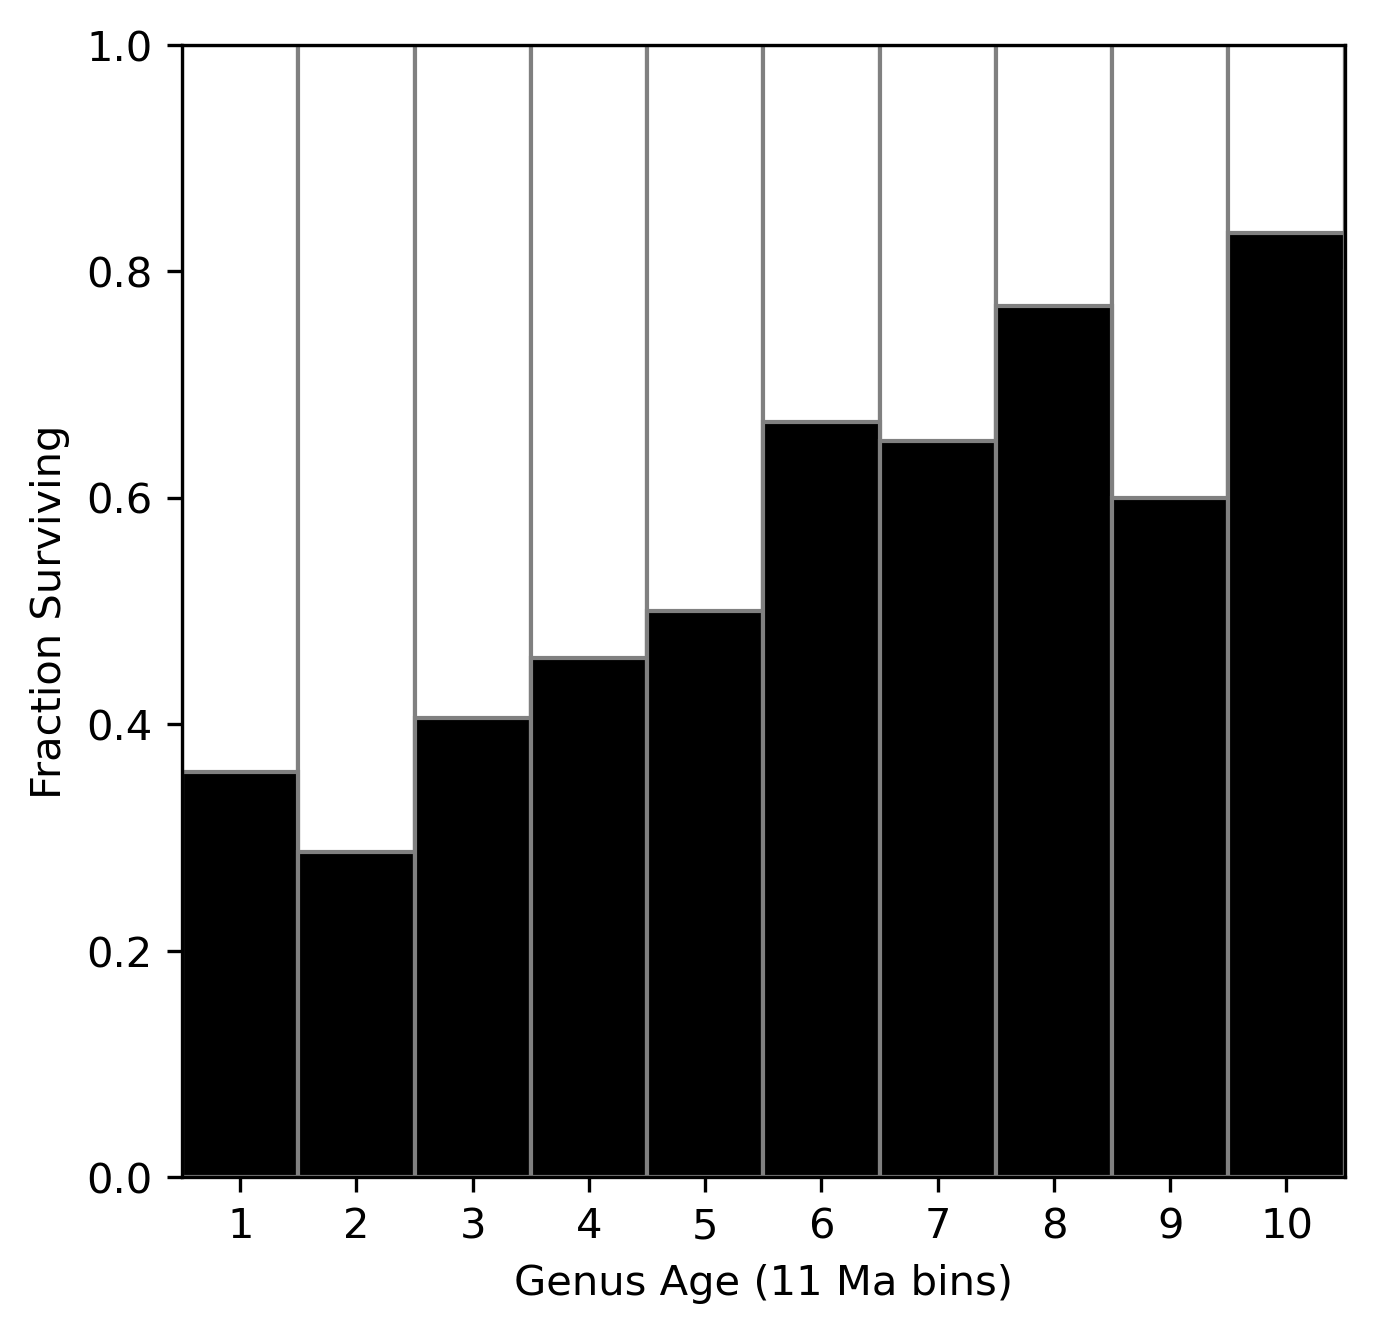

In [92]:
subcladeDictAmm = getSubcladeOccurences("Ammonoidea", resolution=subclade_resolution)
permissiveDurationMatrixAmm = getDurationMatrix(subcladeDictAmm, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixAmm, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

1992 unique subclades (genus) found
1606 subclades with multiple occurences
1139 subclades with at least 5 occurences


<BarContainer object of 20 artists>

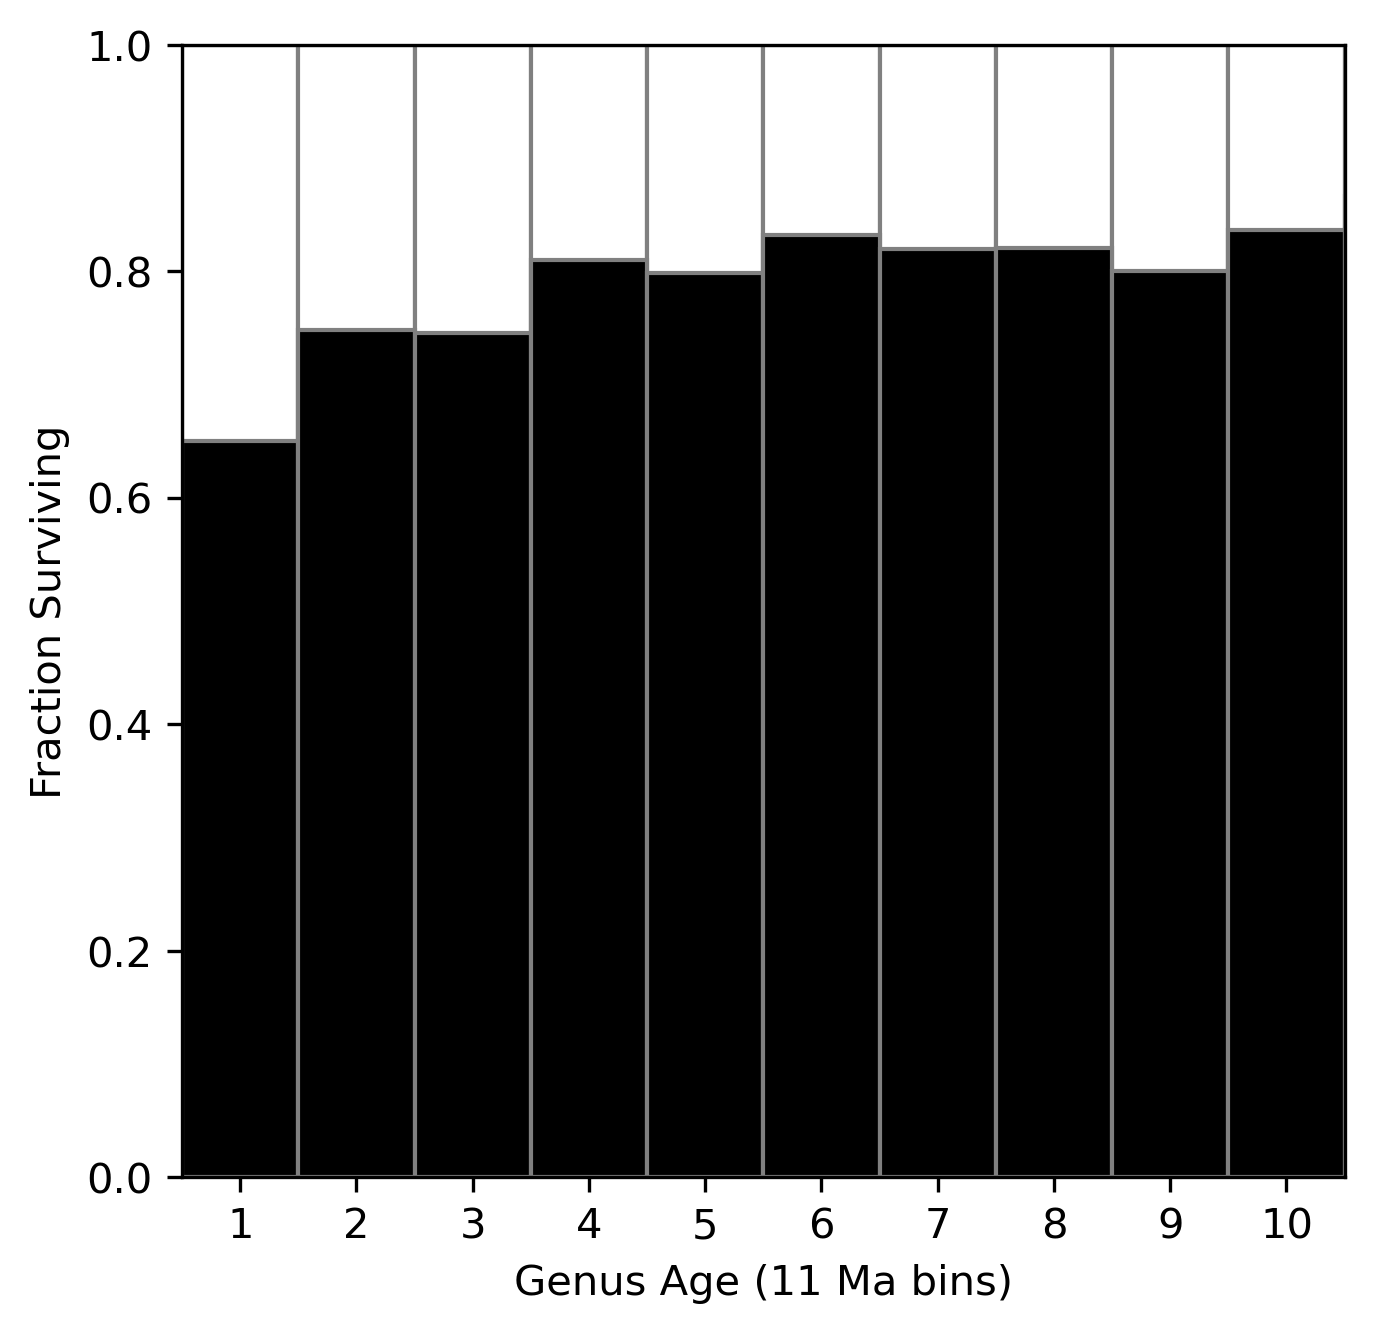

In [93]:
subcladeDictAnth = getSubcladeOccurences("Anthozoa", resolution=subclade_resolution)
permissiveDurationMatrixAnth = getDurationMatrix(subcladeDictAnth, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixAnth, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

7982 unique subclades (genus) found
5103 subclades with multiple occurences
2967 subclades with at least 5 occurences


<BarContainer object of 20 artists>

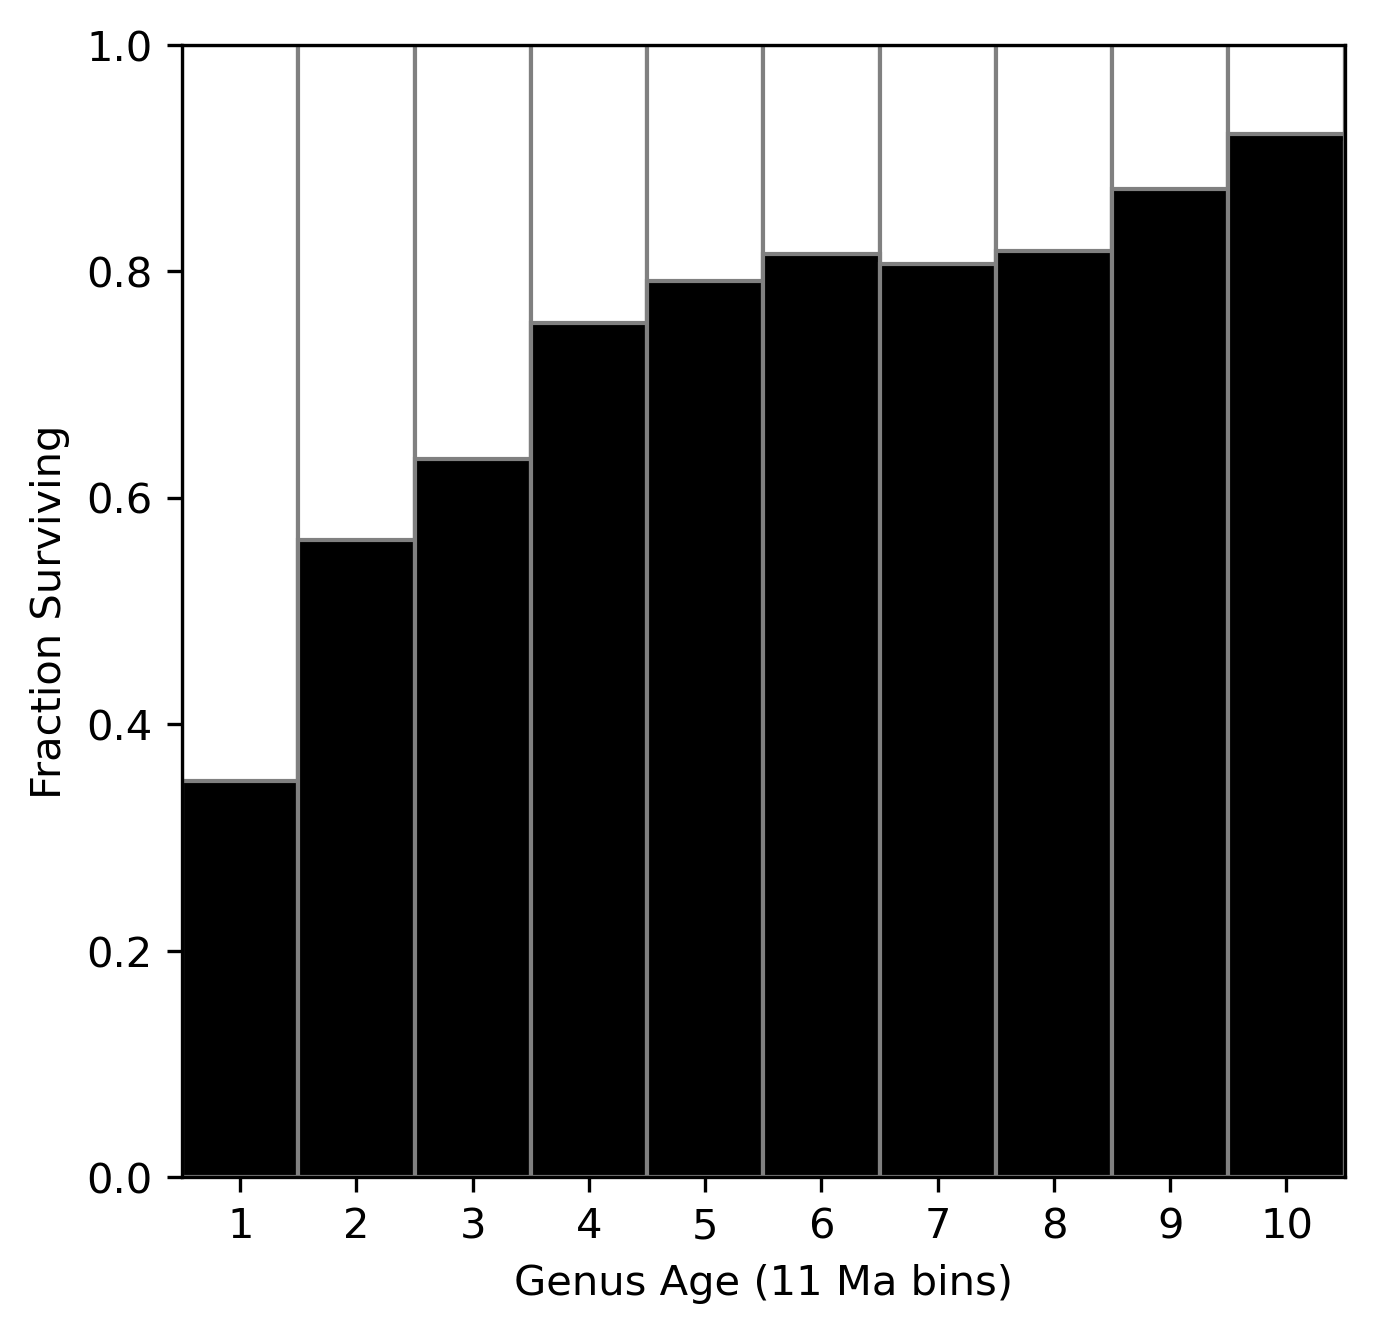

In [94]:
subcladeDictArth = getSubcladeOccurences("Arthropoda", resolution=subclade_resolution, 
                                         environment_only="marine")
permissiveDurationMatrixArth = getDurationMatrix(subcladeDictArth, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixArth, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

13707 unique subclades (genus) found
5701 subclades with multiple occurences
1995 subclades with at least 5 occurences


<BarContainer object of 20 artists>

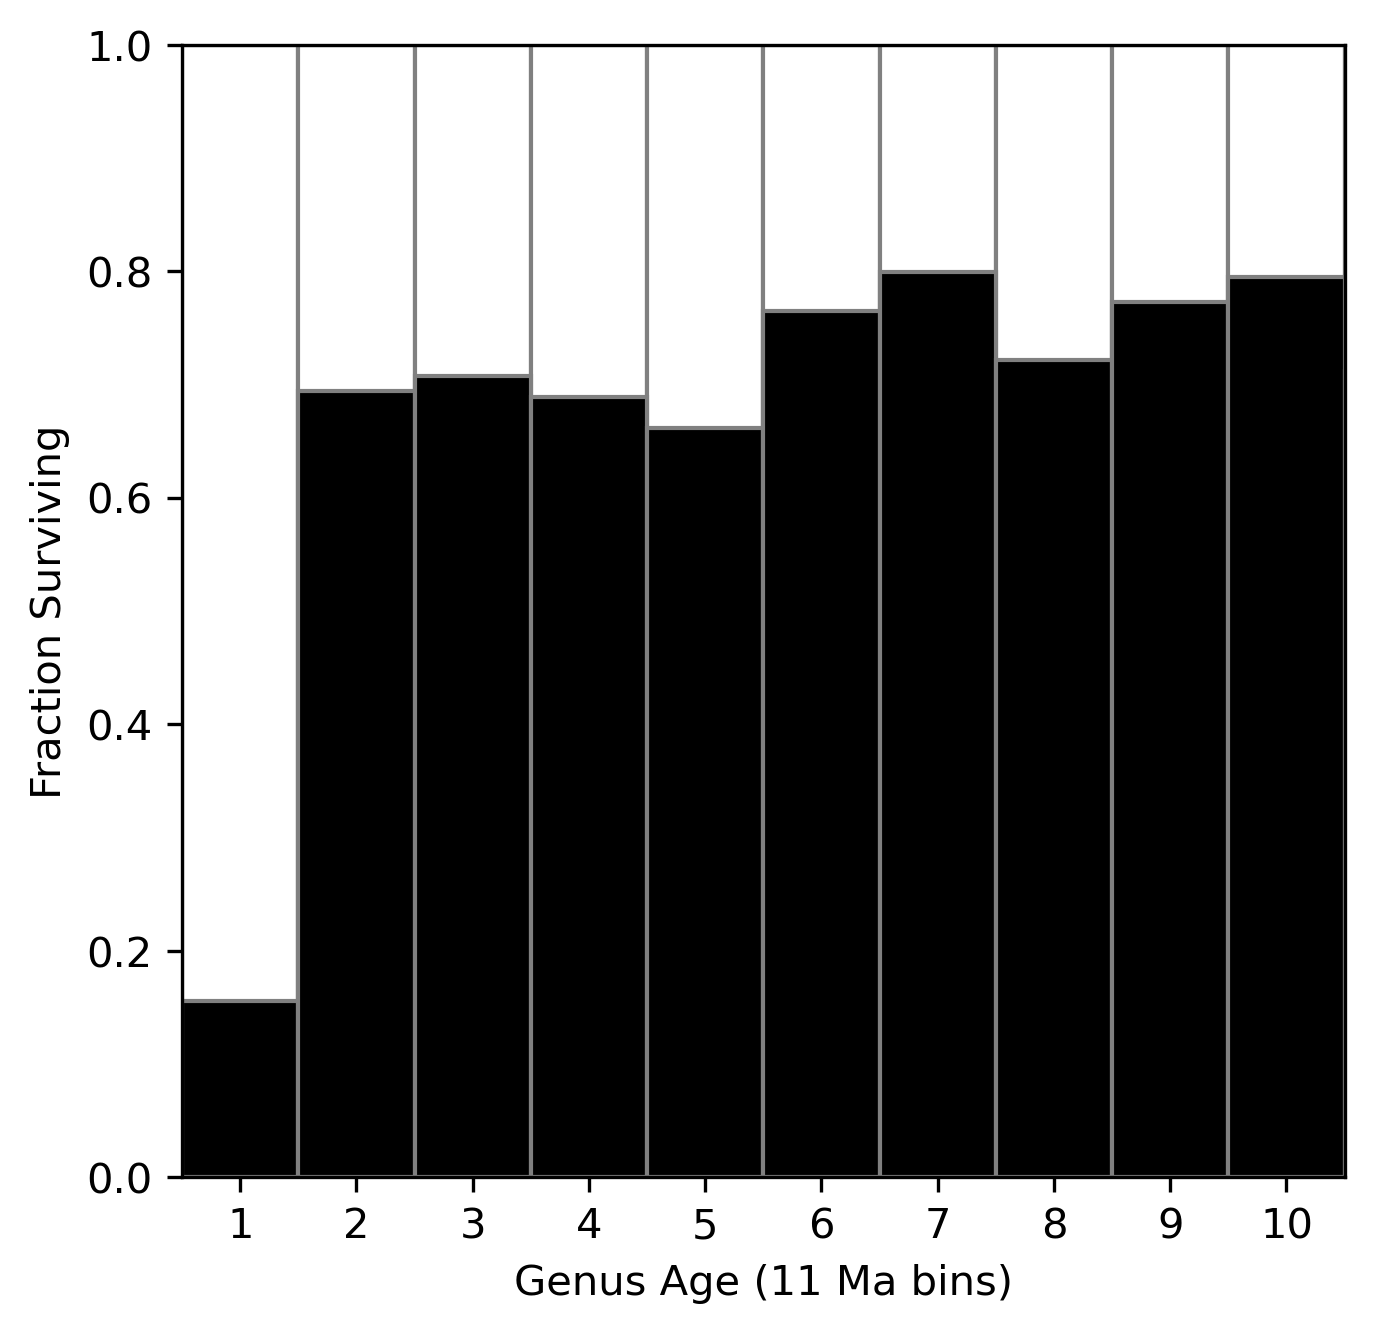

In [95]:
subcladeDictArthTerr = getSubcladeOccurences("Arthropoda", resolution=subclade_resolution, 
                                         environment_only="terr")
permissiveDurationMatrixArthTerr = getDurationMatrix(subcladeDictArthTerr, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixArthTerr, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

Local save of requested search found.

1593 unique subclades (genus) found
1127 subclades with multiple occurences
680 subclades with at least 5 occurences


<BarContainer object of 20 artists>

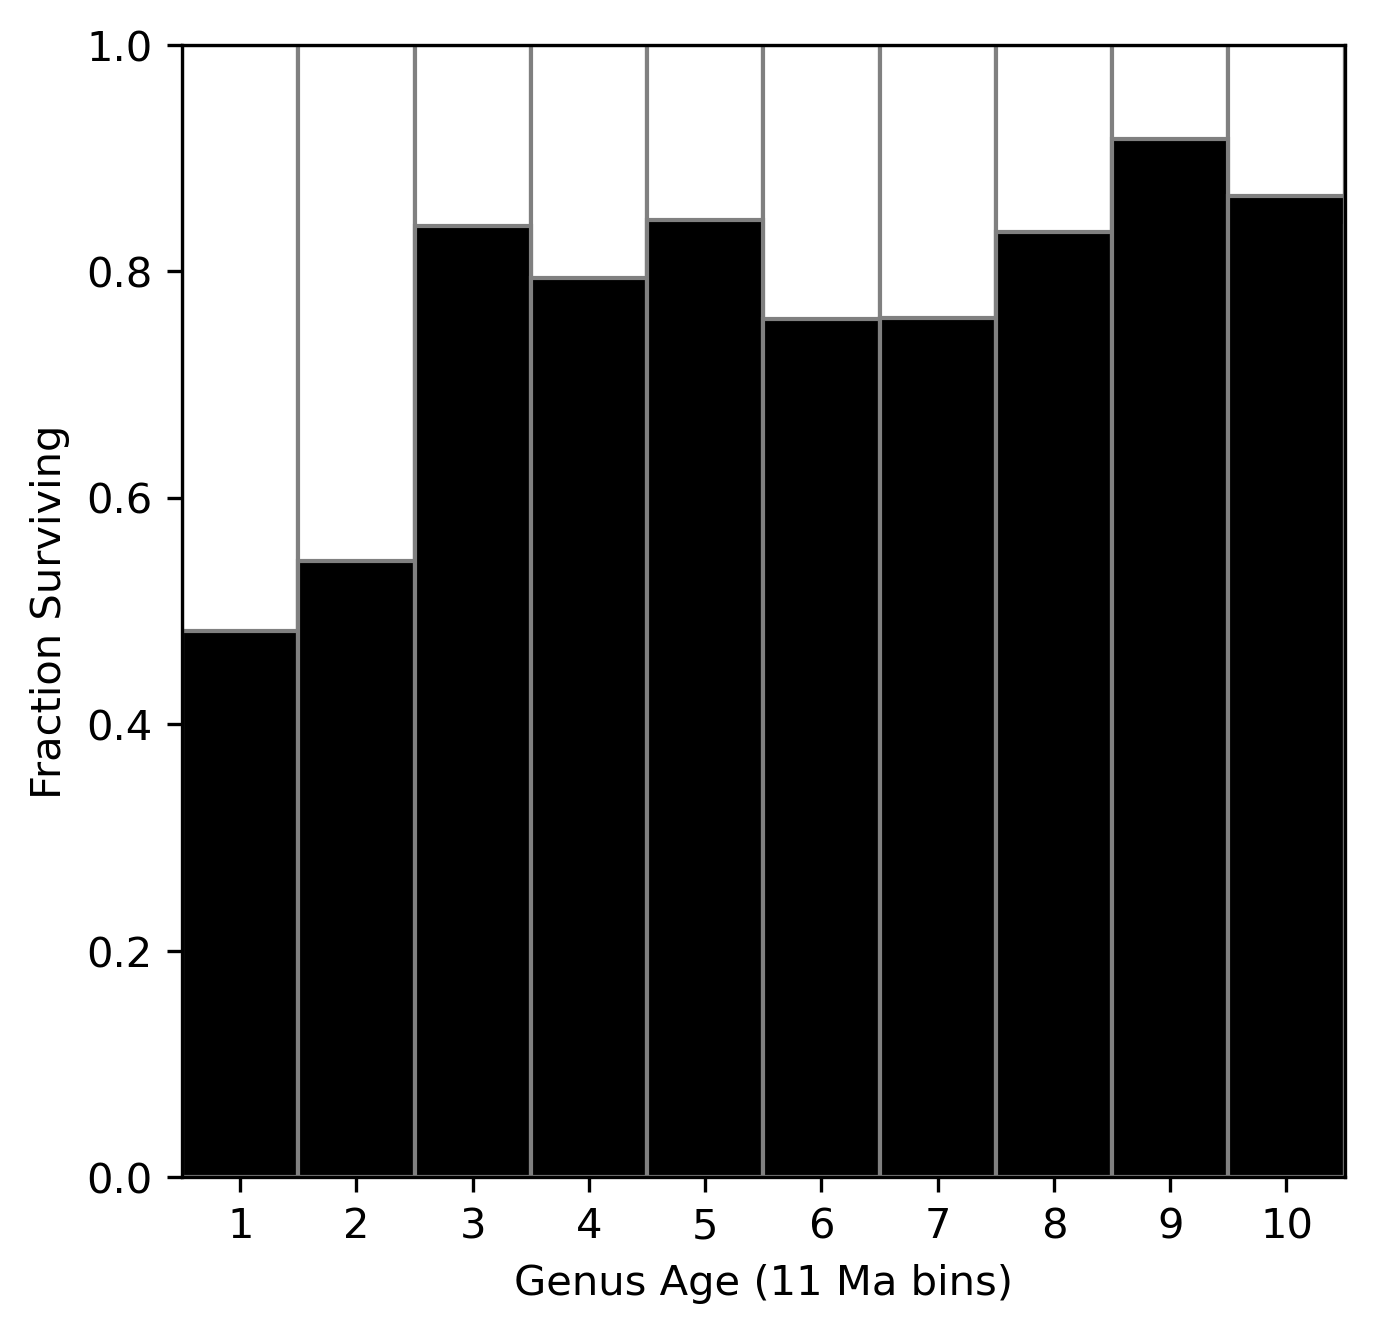

In [96]:
subcladeDictPor = getSubcladeOccurences("Porifera", resolution=subclade_resolution)
permissiveDurationMatrixPor = getDurationMatrix(subcladeDictPor, n_bins=50, t_0=t_0, 
                                                    max_duration=t_0, min_occurrences=1)
overallSurvival = list(getSurvivalsByAge(permissiveDurationMatrixPor, max_age=20).values())
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=20, integer=True))
fig.set_size_inches(5, 5)
ax.set_xlabel("Genus Age (11 Ma bins)")
ax.set_ylabel("Fraction Surviving")
ax.set_ylim(0,1)
ax.set_xlim(0.5, 10 + 0.5)
ax.bar(range(1, 20 + 1), [1]*20,color='white', edgecolor='gray', width=1)
ax.bar(range(1, 20 + 1), overallSurvival, color='black', edgecolor='gray', width=1)

In [ ]:
#print(logOdds)
tots = durationMatrixMetazoa.sum(axis=0)
counts = (durationMatrixMetazoa!=0).sum(axis=0)
counts[counts == 0] = 1
mean_age = np.true_divide(tots, counts)

tots = durationMatrixHighRes.sum(axis=0)
counts = (durationMatrixHighRes!=0).sum(axis=0)
counts[counts == 0] = 1
mean_age_highRes = np.true_divide(tots, counts)

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
bins_to_time = [t_0 - (bin_size * x) for x in range(bins)]
ax.hlines(0, 0, t_0, color="black")
ax.vlines([252, 66], -2, 2, linestyles='--', color="gray")
ax.axvspan(375, 360, alpha=0.2, color='gray')
ax.axvspan(450, 440, alpha=0.2, color='gray')
ax.axvspan(201, 210, alpha=0.2, color='gray')

#ax.plot(bins_to_time,[abs(np.log(x)) for x in logOdds], '--', color="gray")
ax.plot(bins_to_time,[np.log(x) - np.nanmean([np.log(x) for x in logOdds]) for x in logOdds])
#ax.scatter(bins_to_time,[np.log(x) - np.mean([np.log(x) for x in logOdds]) for x in logOdds], s=20)
#ax.scatter(bins_to_time, [1 - x for x in extinctionRates], s=20)
ax.plot(bins_to_time, [(1 - x) - (1 - np.nanmean(extinctionRates)) for x in extinctionRates])
#print(extinctionRatesHighRes)
#ax.plot([t_0 - (bin_size * x) for x in np.linspace(0, bins, num=1000)], mean_age / np.max(mean_age),'--',color="green")

plt.xlabel("Time (Ma)")
plt.ylabel("Age selectivity log-odds (blue)\nSurivorship Rate (orange)\nNormalized Mean Clade Age (green)")
plt.xlim(0,t_0)
plt.ylim(-1, 1)
plt.gca().invert_xaxis()

In [ ]:
#print(populatedLogOdds)
plt.scatter(extinctionRatesHighRes[150:], populatedLogOdds[150:])
plt.xlim(0.02, 0.6)
#print(np.corrcoef([np.log(x) for x in logOdds][3:-1], extinctionRates[3:-1]))

In [32]:
subcladeStartEndsMetazoa = getSubcladeAgeRanges(subcladeDictMetazoa, 
                                                min_occurence_threshold=5, keep_short_lived=True)

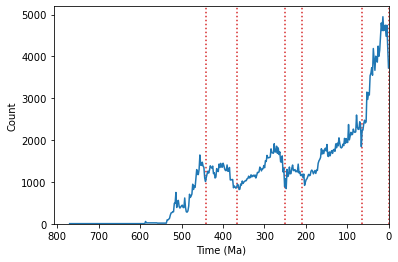

In [34]:
plotSepkoskiBins(subcladeStartEndsMetazoa, event_lines=[440, 365, 250, 210, 65, 0], n_bins=400)

In [5]:
# Some example uses:

In [7]:
# Example 1: Genera of Phacopida (an order of trilobites)

# Returns a dictionary of the midpoints of the age ranges
# of all confirmed Phacopida genus occurences
# (Since I specified no resolution it defaults to genus-level)
# {"genus1":[occurenceTime1, occurenceTime2, ...], "genus2":[occurenceTime1, ...], ...}
subcladeDictPhacopida = getSubcladeOccurences("Phacopida") #colocalized_threshold=10, no_simultaneous=True

Local save of requested search found.

356 unique subclades (genus) found
249 subclades with multiple occurences
114 subclades with at least 5 occurences


In [8]:
subcladeDictPhacopidaColocal = getSubcladeOccurences("Phacopida", colocalized_threshold=None, no_simultaneous=True)

Local save of requested search found.

356 unique subclades (genus) found
256 subclades with multiple occurences
122 subclades with at least 5 occurences


In [11]:
subcladeDictPhacopida = getSubcladeOccurences("Phacopida", colocalized_threshold=10, no_simultaneous=False)

Local save of requested search found.

356 unique subclades (genus) found
282 subclades with multiple occurences
166 subclades with at least 5 occurences


In [26]:
subcladeDictPhacopida = getSubcladeOccurences("Phacopida", colocalized_threshold=10000, no_simultaneous=False)

Local save of requested search found.

356 unique subclades (genus) found
282 subclades with multiple occurences
166 subclades with at least 5 occurences


In [13]:
subcladeDictPhacopida = getSubcladeOccurences("Phacopida", colocalized_threshold=None, no_simultaneous=False)

Local save of requested search found.

356 unique subclades (genus) found
301 subclades with multiple occurences
215 subclades with at least 5 occurences


In [14]:
# Gets the min and max ages of all confirmed occurences
# Stored as {"genus1":(old, young), "genus2":(old, young), ...}
subcladeStartEndsPhacopida = getSubcladeAgeRanges(subcladeDictPhacopida, 
                                                  min_occurence_threshold=5, keep_short_lived=True)



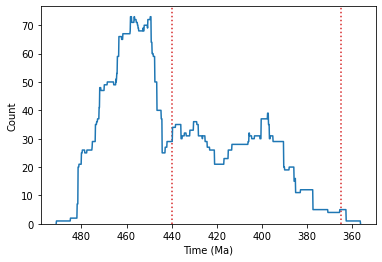

In [18]:
plotSepkoski(subcladeStartEndsPhacopida, event_lines=[440, 365], n_bins=1000)

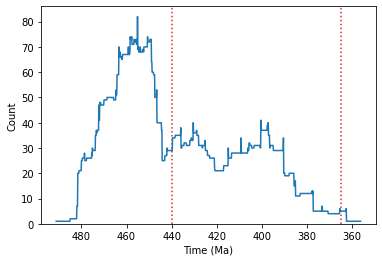

In [19]:
plotSepkoskiBins(subcladeStartEndsPhacopida, event_lines=[440, 365], n_bins=1000)

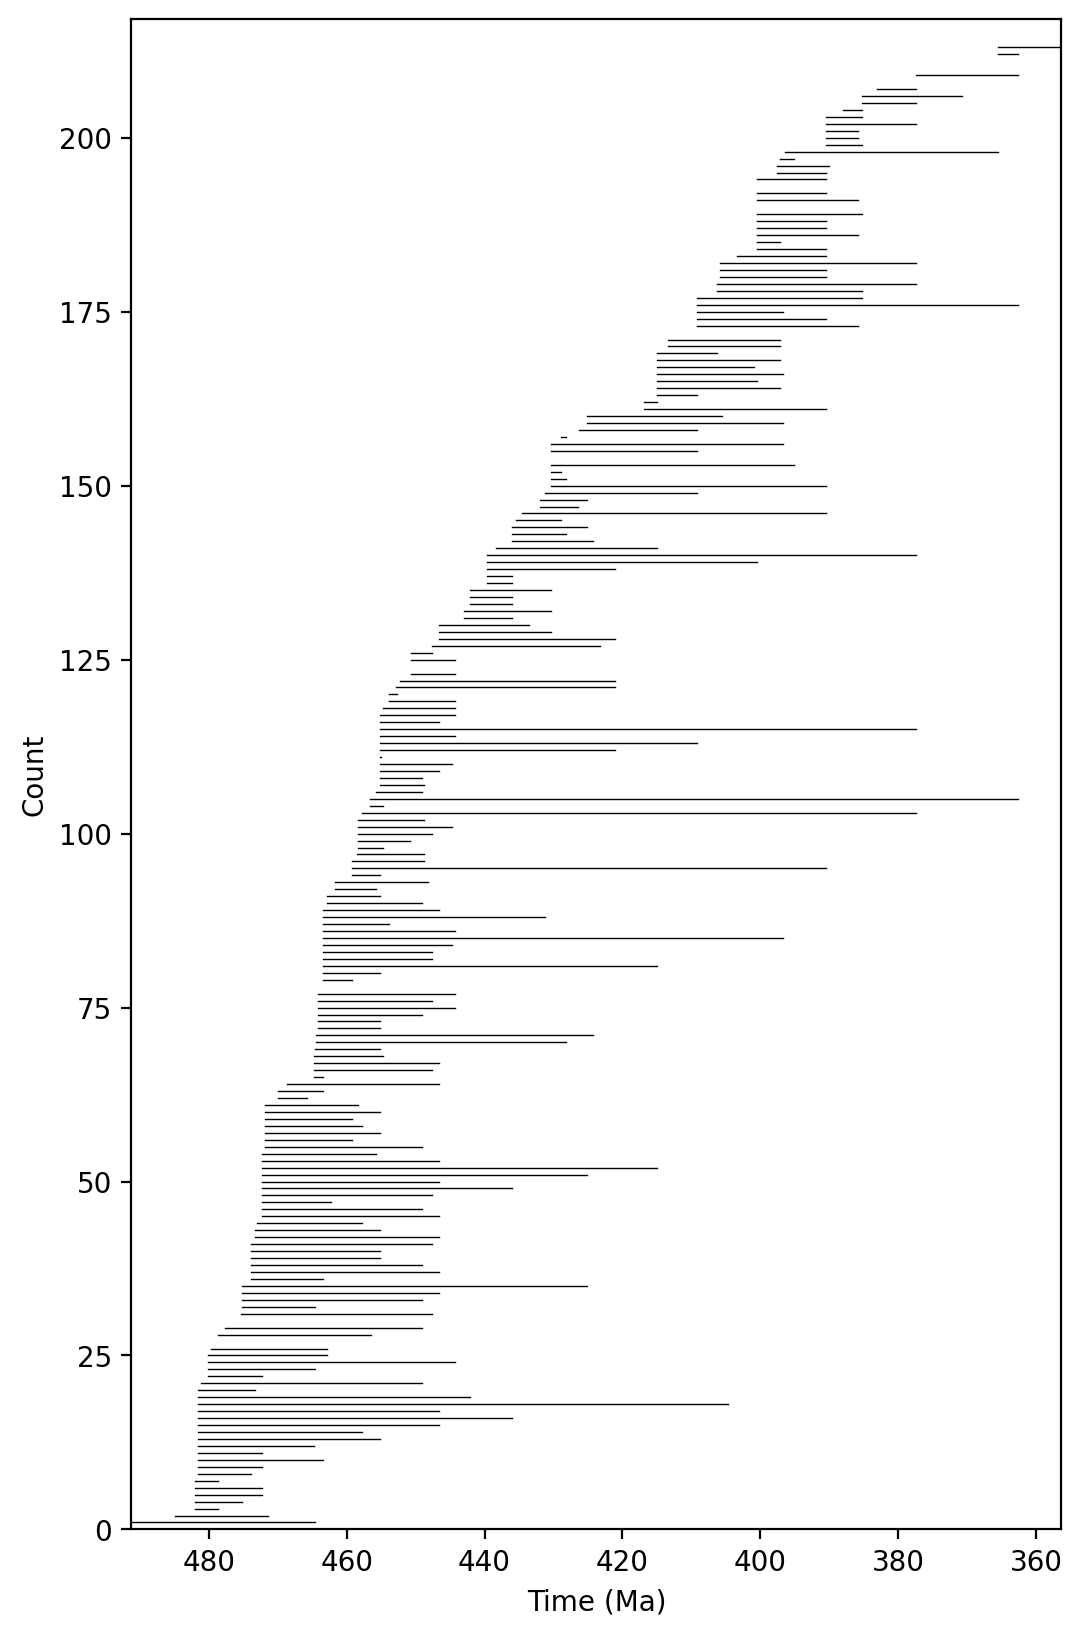

In [10]:
plotStackedBars(subcladeStartEndsPhacopida)

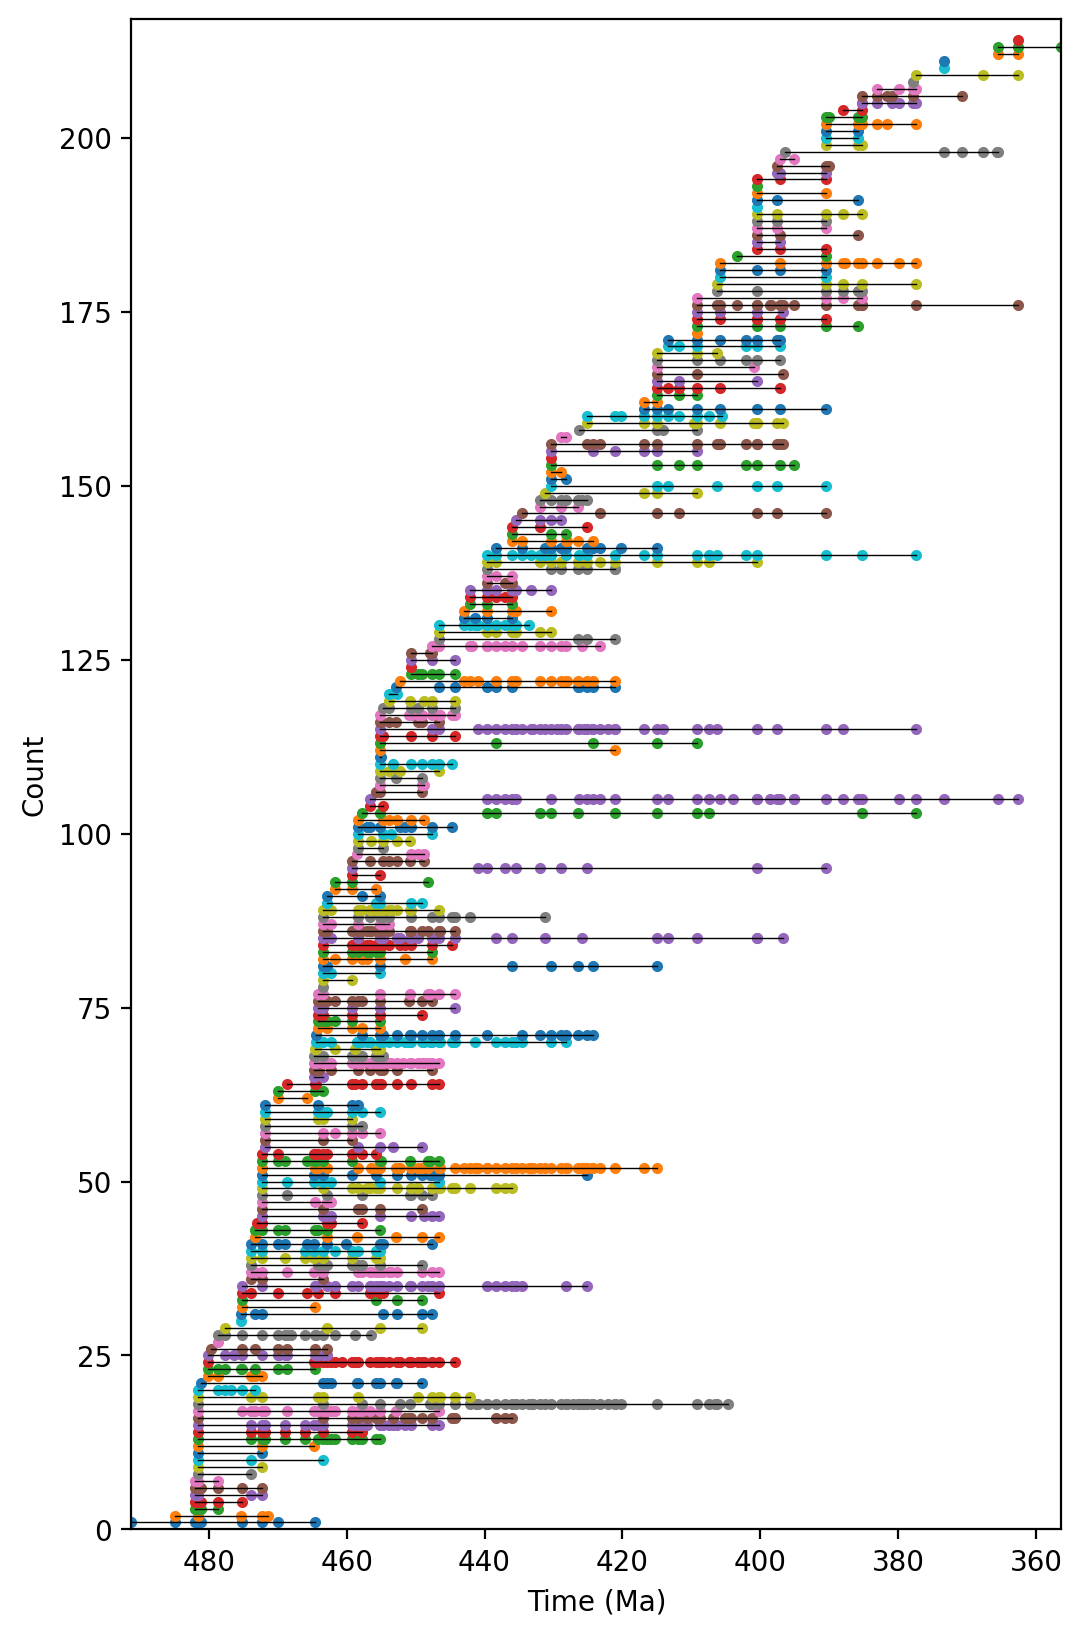

In [11]:
plotStackedBarsWithDots(subcladeDictPhacopida)

Top ten most persistent subclades:
1. Phacops: 93.9 Ma
2. Homalonotus: 80.3 Ma
3. Dalmanites: 77.8 Ma
4. Calymene: 76.9 Ma
5. Phacopidella: 68.7 Ma
6. Gravicalymene: 66.7 Ma
7. Trimerus: 62.2 Ma
8. Encrinurus: 57.3 Ma
9. Encrinuroides: 50.0 Ma
10. Sthenarocalymene: 48.4 Ma


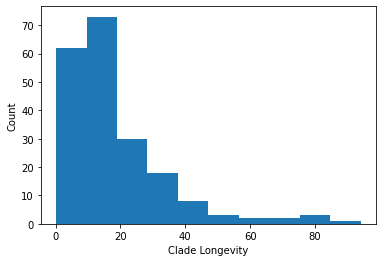

In [10]:
plotAgeHistogram(subcladeStartEndsPhacopida, n_bins=10)

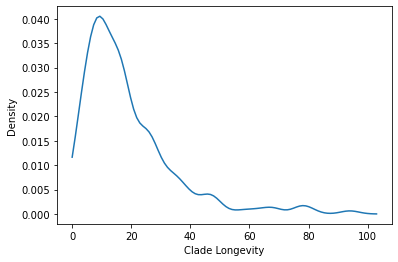

In [11]:
plotAgeDensityDist(subcladeStartEndsPhacopida, cov_factor=0.2)

0.049999999999954525

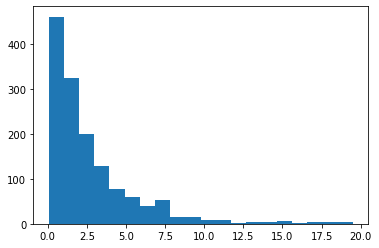

In [16]:
intervalsPhacopida = getOccurenceSpacings(subcladeDictPhacopida)
plt.hist([x for x in intervalsPhacopida if x < 20], bins=20)
min(intervalsPhacopida)

No local save of requested search found. Downloading from PBDB.
Search results saved to /home/parsonsc/persistence/Ammonoidea_marine.csv

3143 unique subclades (['genus']) found
2732 subclades with multiple occurences
1913 subclades with multiple unique occurences
2092 subclades with at least 5 occurences


<ipython-input-25-76b0b2457abf>:162: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


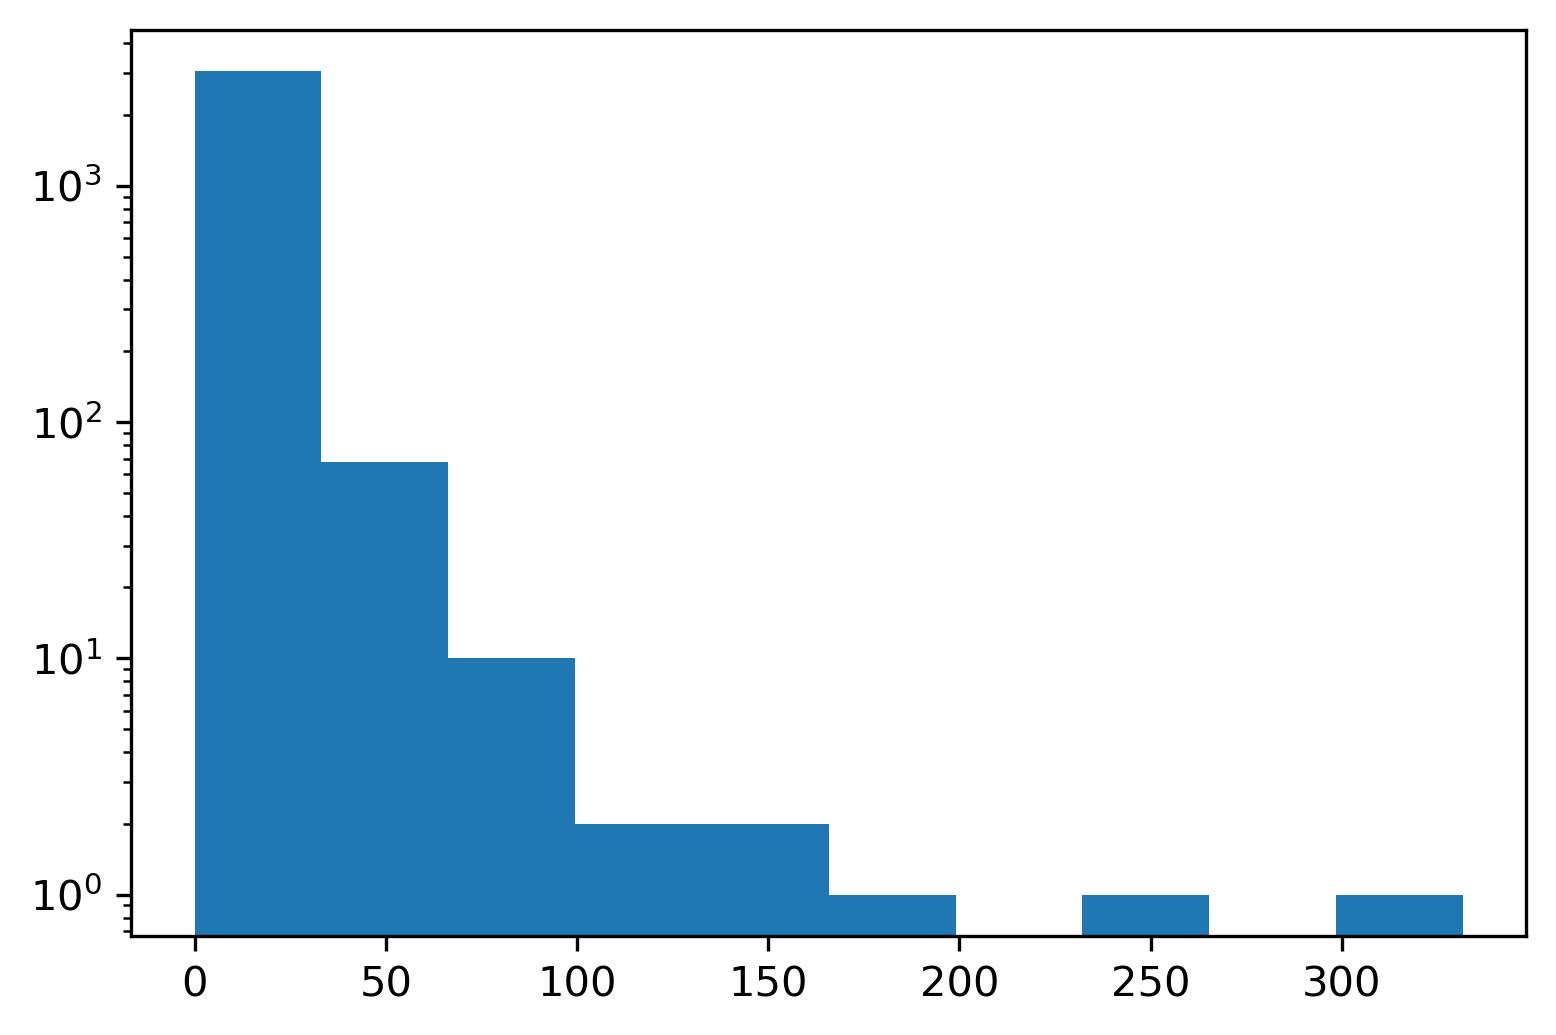

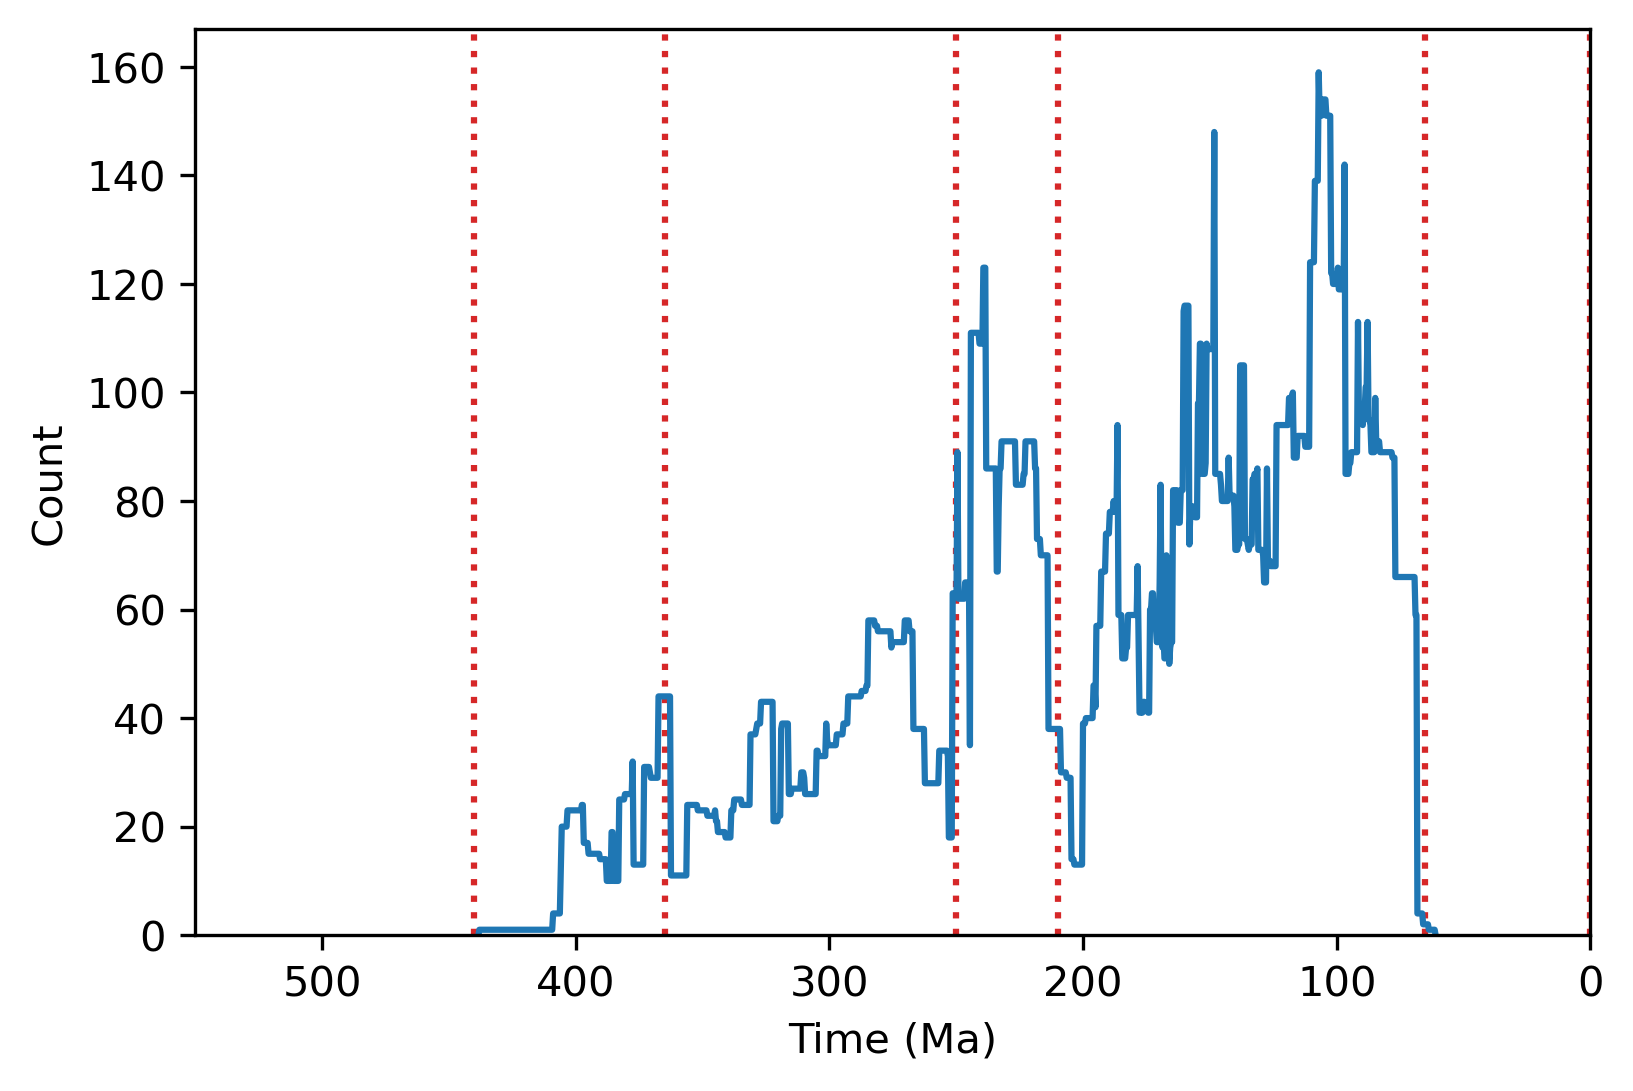

In [25]:
%run "~/persistence/sepkoskiMakerV6.ipynb"
subcladeDictBrachFamilies = getSubcladeOccurences("Ammonoidea", resolution="genus", environment_only="marine")["genus"]
subcladeStartEndsBrachFamilies = getSubcladeAgeRanges(subcladeDictBrachFamilies, 
                                                          min_occurence_threshold=1)
#print(subcladeDictBrachFamilies)
plotSepkoski(subcladeStartEndsBrachFamilies, event_lines=[440, 365, 250, 210, 65, 0], n_bins=1000)
plt.xlim(0, 550)
plt.gca().invert_xaxis()

In [13]:
# Example 2: All families of trilobites

# Returns a dictionary of the midpoints of the age ranges
# of all confirmed Triblobite family occurences
# (This time I specified the resolution to the family-level)
# {"family1":[occurenceTime1, occurenceTime2, ...], "family2":[occurenceTime1, ...], ...}

subcladeDictTrilobiteFamilies = getSubcladeOccurences("Trilobita", resolution="family")

Local save of requested search found.

185 unique subclades (family) found
177 subclades with multiple occurences
172 subclades with at least 5 occurences


In [14]:
subcladeStartEndsTrilobiteFamilies = getSubcladeAgeRanges(subcladeDictTrilobiteFamilies, 
                                                          min_occurence_threshold=5)

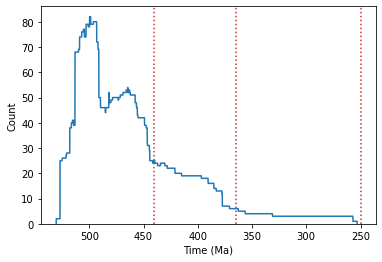

In [15]:
plotSepkoski(subcladeStartEndsTrilobiteFamilies, event_lines=[440, 365, 250], n_bins=10000)

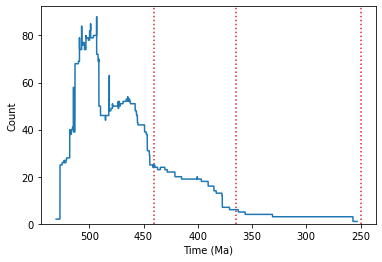

In [16]:
plotSepkoskiBins(subcladeStartEndsTrilobiteFamilies, event_lines=[440, 365, 250], n_bins=10000)

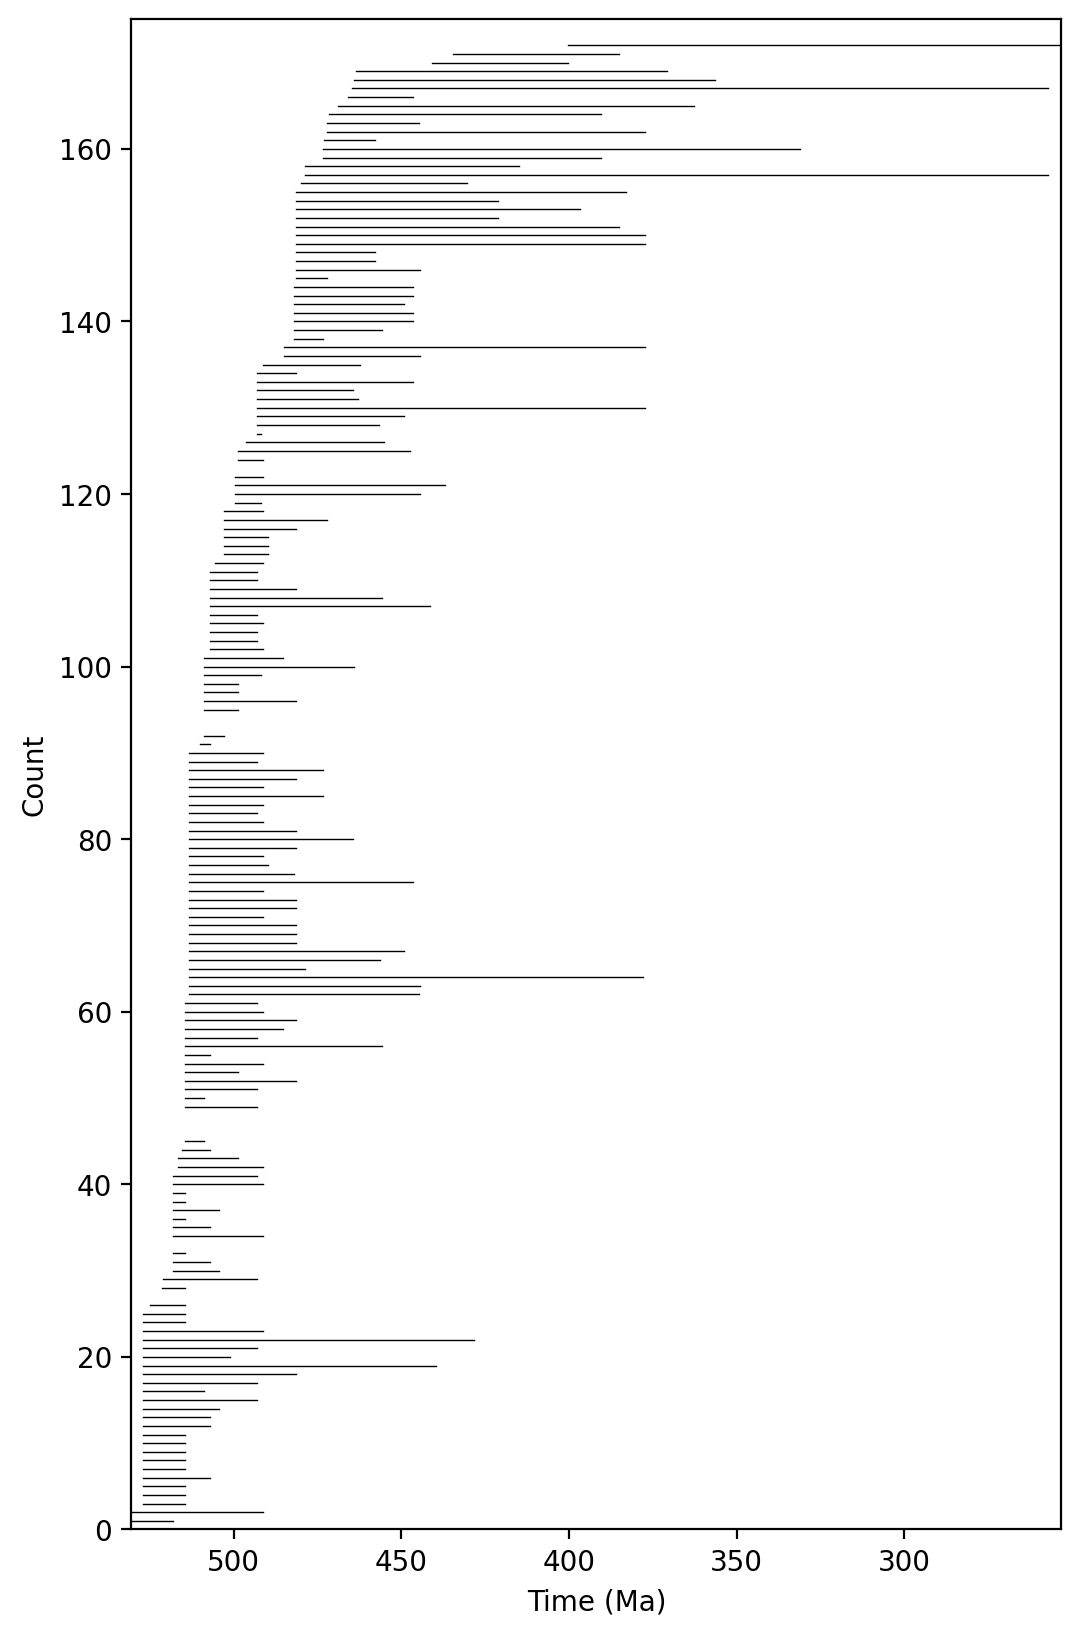

In [17]:
plotStackedBars(subcladeStartEndsTrilobiteFamilies)

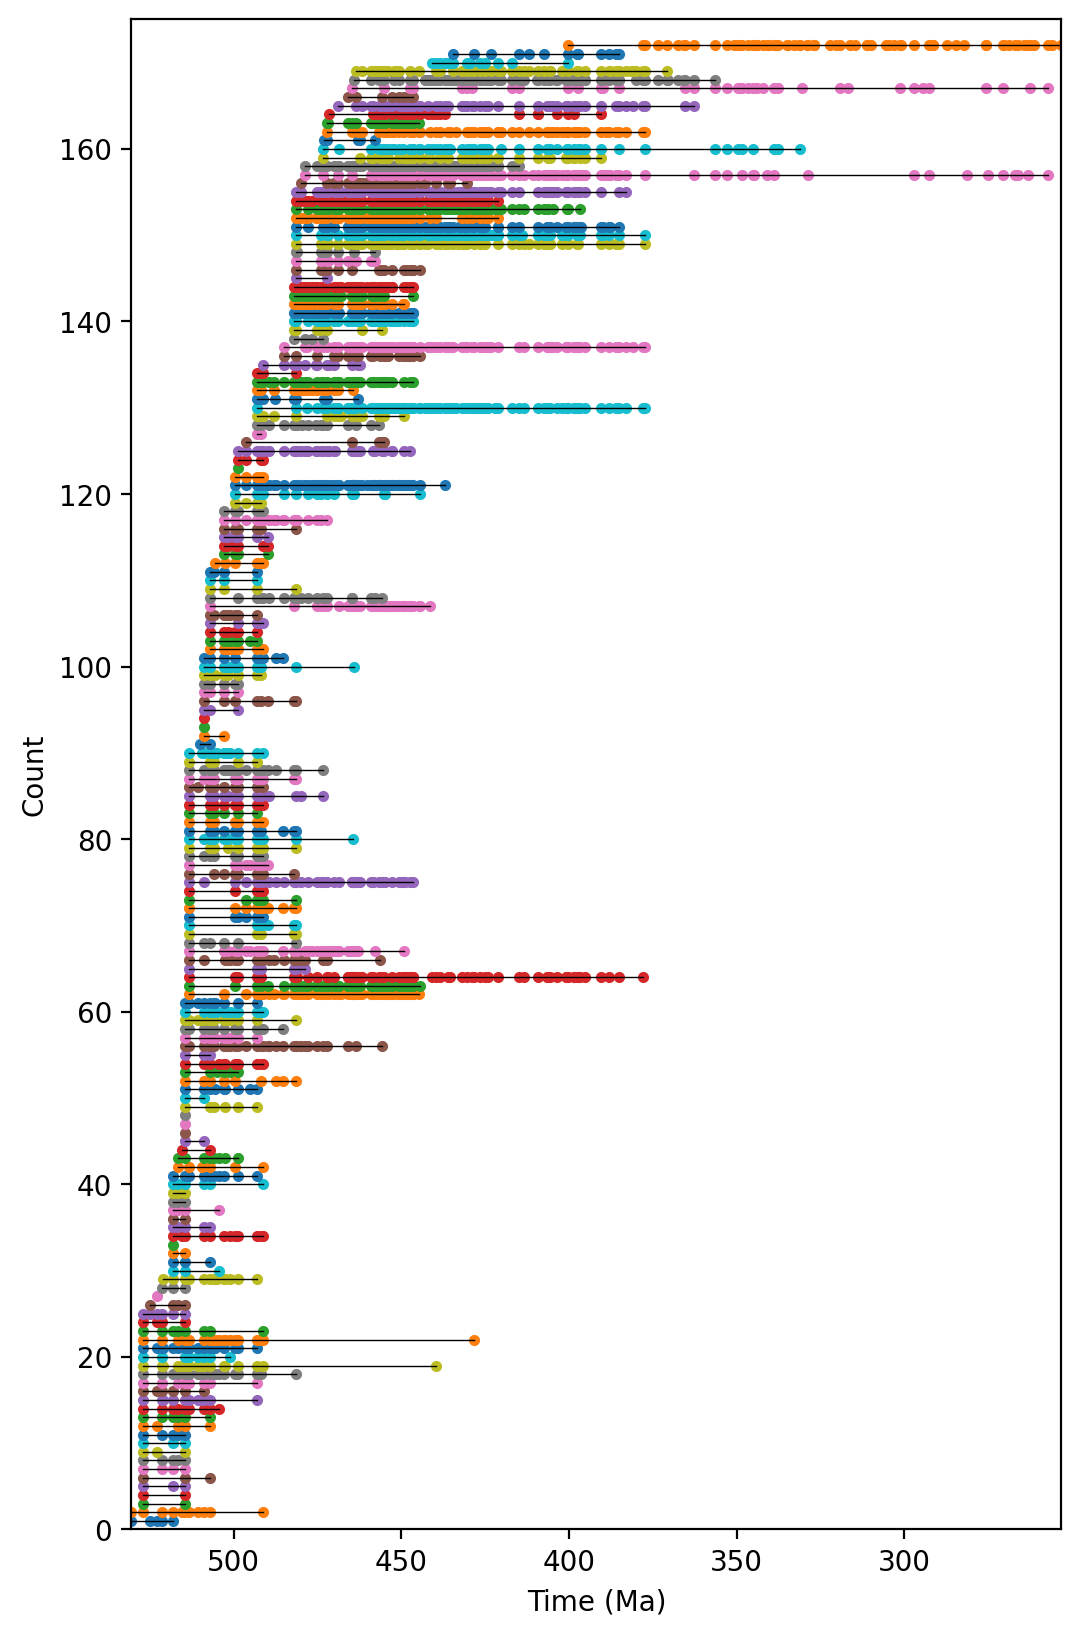

In [18]:
plotStackedBarsWithDots(subcladeDictTrilobiteFamilies)

Top ten most persistent subclades:
1. Proetidae: 221.6 Ma
2. Brachymetopidae: 207.6 Ma
3. Phillipsiidae: 147.3 Ma
4. Aulacopleuridae: 142.2 Ma
5. Harpetidae: 135.4 Ma
6. Odontopleuridae: 115.8 Ma
7. Phacopidae: 107.8 Ma
8. Styginidae: 107.5 Ma
9. Tropidocoryphidae: 106.2 Ma
10. Homalonotidae: 104.1 Ma


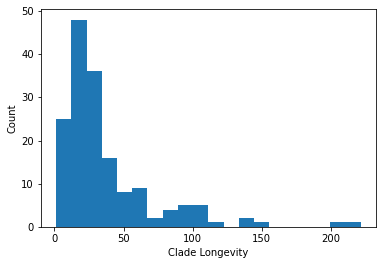

In [17]:
plotAgeHistogram(subcladeStartEndsTrilobiteFamilies, n_bins=20)

In [7]:
clade_of_interest = "Metazoa"
subclade_resolution = "phylum"

subcladeDictMetazoa = getSubcladeOccurences(clade_of_interest, resolution=subclade_resolution, 
                                            environment_only="marine")

Local save of requested search found.

30 unique subclades (phylum) found
29 subclades with multiple occurences
24 subclades with at least 5 occurences


In [10]:
subcladeStartEndsMetazoanPhyla = getSubcladeAgeRanges(subcladeDictMetazoa, 
                                                      min_occurence_threshold=5,
                                                      keep_short_lived=True)
print(subcladeStartEndsMetazoanPhyla)

{'Arthropoda': (588.0, 0.00585), 'Brachiopoda': (535.5, 0.00585), 'Echinodermata': (527.0, 0.00585), 'Porifera': (925.0, 0.00585), 'Chordata': (535.5, 0.00585), 'Mollusca': (588.0, 0.00585), 'Bryozoa': (527.0, 0.00585), 'Hyolitha': (588.0, 253.17), 'Cnidaria': (770.5, 0.00585), 'Problematica': (770.5, 2.197), 'Priapulida': (527.0, 309.2), 'Hemichordata': (518.0, 193.05), 'Annelida': (588.0, 0.00585), 'Lophotrochozoa': (588.0, 153.25), 'Phoronida': (518.0, 148.55), 'Onychophora': (528.5, 309.2), 'Chaetognatha': (535.5, 309.2), 'Bilateralomorpha': (588.0, 588.0), 'Calcispongea': (431.95, 25.565), 'Sipuncula': (440.95, 147.9), 'Ctenophora': (527.0, 405.8), 'Vetulicolia': (527.0, 507.0), 'Entoprocta': (518.0, 514.5), 'Nematoda': (322.25, 193.05)}


[('Arthropoda', 101219), ('Brachiopoda', 176420), ('Echinodermata', 31288), ('Porifera', 22731), ('Chordata', 100256), ('Mollusca', 465345), ('Bryozoa', 29224), ('Hyolitha', 2053), ('Cnidaria', 67353), ('Problematica', 2978), ('Priapulida', 176), ('Hemichordata', 7601), ('Annelida', 3634), ('Lophotrochozoa', 2194), ('Phoronida', 19), ('Onychophora', 129), ('Chaetognatha', 255), ('Bilateralomorpha', 16), ('Petalonamae', 3), ('Calcispongea', 17), ('Sipuncula', 7), ('Ctenophora', 17), ('Vetulicolia', 46), ('Entoprocta', 7), ('Nematoda', 6), ('Tardigrada', 2), ('Ectoprocta', 2), ('Nemertea', 4), ('Pogonophora', 3), ('Rotifera', 1)]


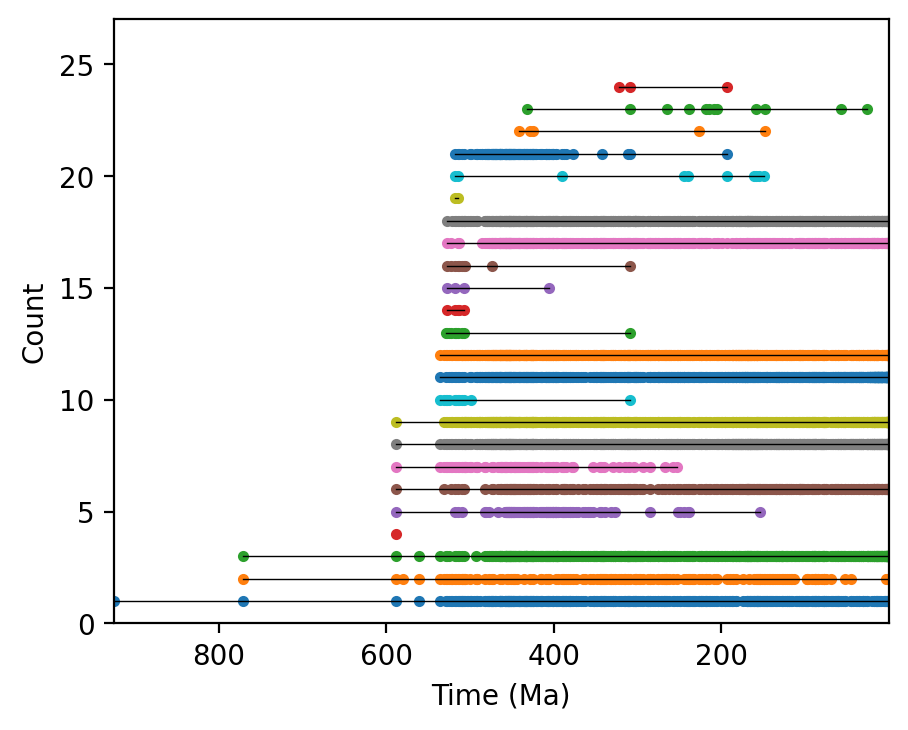

In [15]:
print([(x, len(subcladeDictMetazoa[x])) for x in subcladeDictMetazoa])
plotStackedBarsWithDots(subcladeDictMetazoa)

In [19]:
# Example 3: All trilobite genera

# Returns a dictionary of the midpoints of the age ranges
# of all confirmed Triblobite family occurences
# (This time I specified the resolution to the family-level)
# {"family1":[occurenceTime1, occurenceTime2, ...], "family2":[occurenceTime1, ...], ...}

subcladeDictTrilobiteGenera = getSubcladeOccurences("Trilobita", resolution="genus")

Local save of requested search found.

2873 unique subclades (genus) found
2355 subclades with multiple occurences
1615 subclades with at least 5 occurences


In [20]:
subcladeStartEndsTrilobiteGenera = getSubcladeAgeRanges(subcladeDictTrilobiteGenera, 
                                                          min_occurence_threshold=5,
                                                            keep_short_lived=True)

print([x for x in subcladeStartEndsTrilobiteGenera if subcladeStartEndsTrilobiteGenera[x][0] == subcladeStartEndsTrilobiteGenera[x][1]])

['Bythicheilus', 'Spencia', 'Morosa', 'Sigmocheilus', 'Kyphocephalus', 'Calocephalites', 'Drabia', 'Arcticalymene', 'Parkesolithus', 'Cybeloides (Paracybeloides)', 'Dianops', 'Chaunoproetus', 'Hemibarrandia', 'Holubaspis', 'Benesovella', 'Amiaspis', 'Tungtzuella', 'Apatokephalops', 'Neopsilocephalina', 'Hysterolenus', 'Neoblairella', 'Deckera', 'Tholifrons', 'Quebecaspis', 'Parahousia', 'Pelicephalus', 'Deltacare', 'Ursinella', 'Olenellus (Olenellus)', 'Proerbia', 'Abakania', 'Shivelicus', 'Acanthopyge (Acanthopyge)', 'Palmettaspis', 'Yuknessaspis', 'Microryctocara', 'Mummaspis', 'Proetina (Hamiroproetus)', 'Denemarkia', 'Cerauromeros', 'Tarimella', 'Whittakerites', 'Aayemenaytcheia', 'Ormistonia', 'Eskoharpes', 'Rudybole', 'Acuticryphops', 'Francovichia', 'Deltacephalaspis', 'Paraglobusia', 'Pedinocoryphe', 'Weyeraspis', 'Helioproetus', 'Typhloproetus (Silesiops)', 'Chaunoproetus (Chaunoproetus)', 'Haasproetus', 'Liobolina (Guilinaspis)', 'Cyrtoproetus (Sinocyrtoproetus)', 'Phillibolo

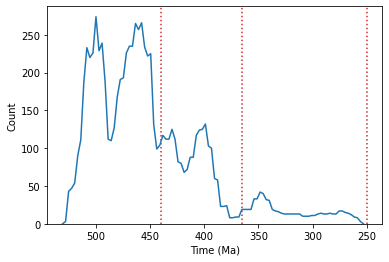

In [21]:
plotSepkoski(subcladeStartEndsTrilobiteGenera, event_lines=[440, 365, 250])

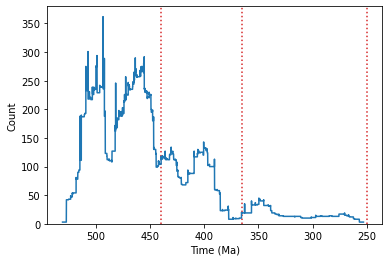

In [22]:
plotSepkoskiBins(subcladeStartEndsTrilobiteGenera, event_lines=[440, 365, 250], n_bins=10000)

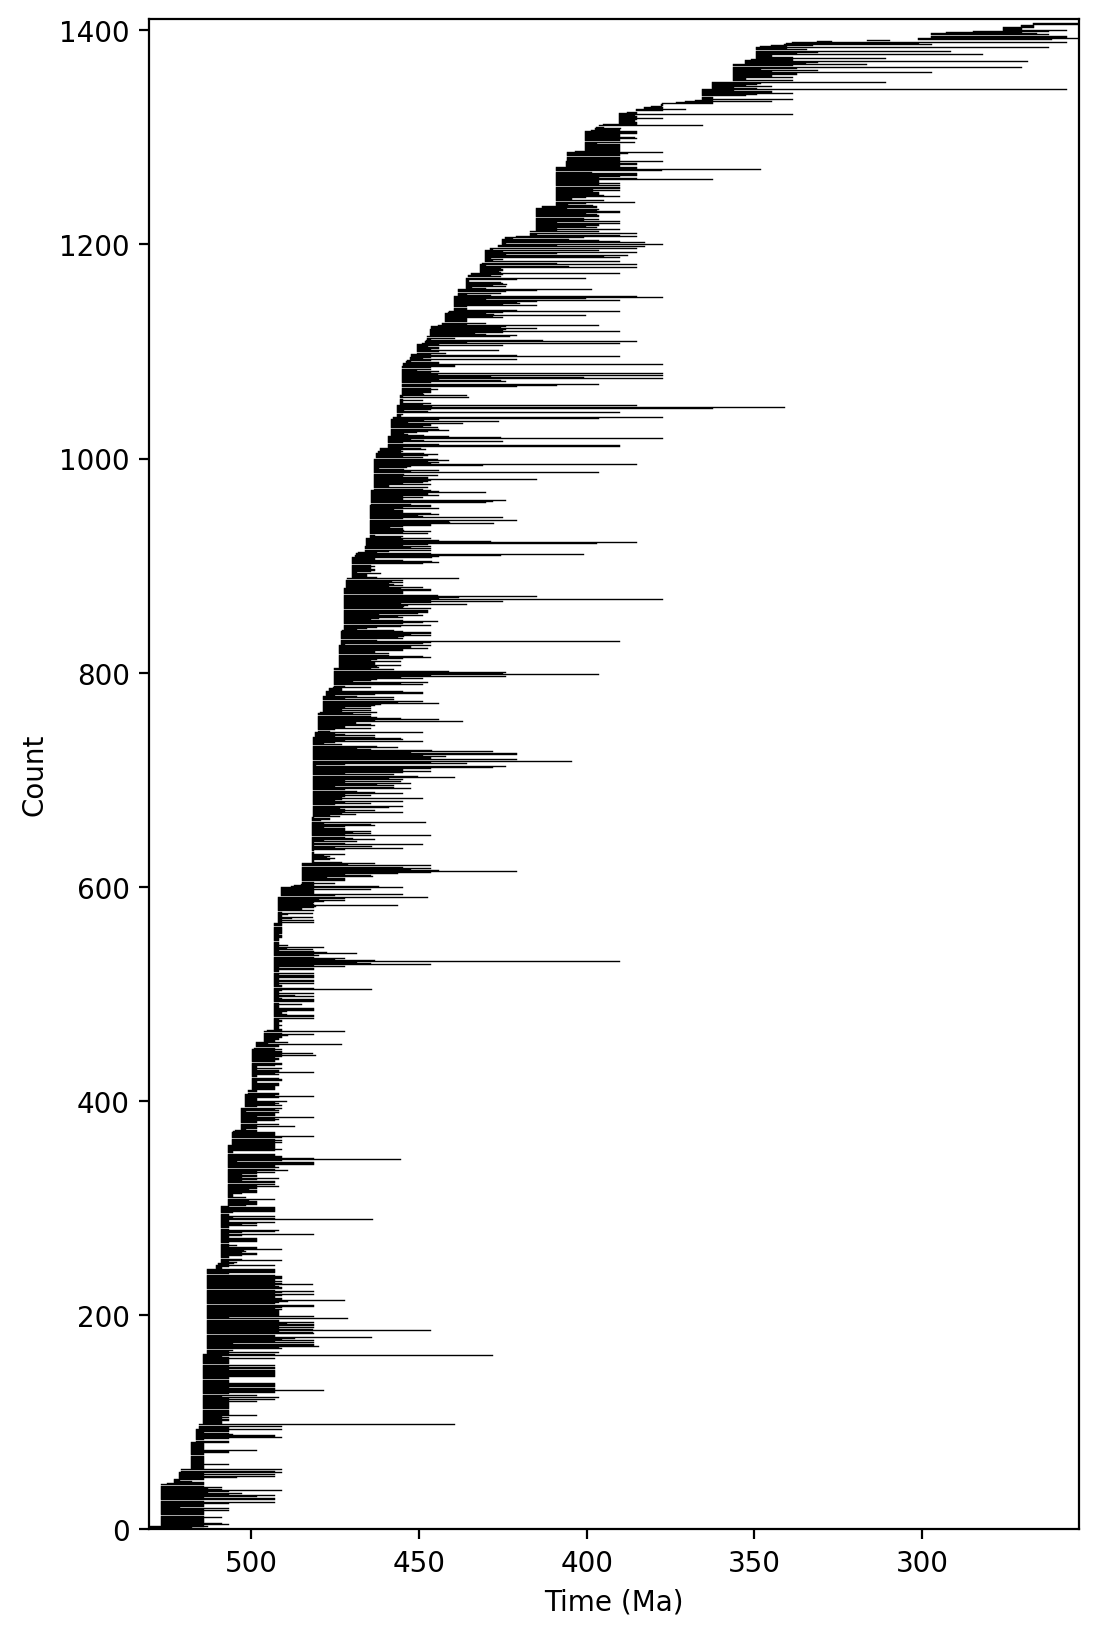

In [21]:
# I think the gaps here are a resolution/rounding issue?
# I'll try to find a workaround
plotStackedBars(subcladeStartEndsTrilobiteGenera)

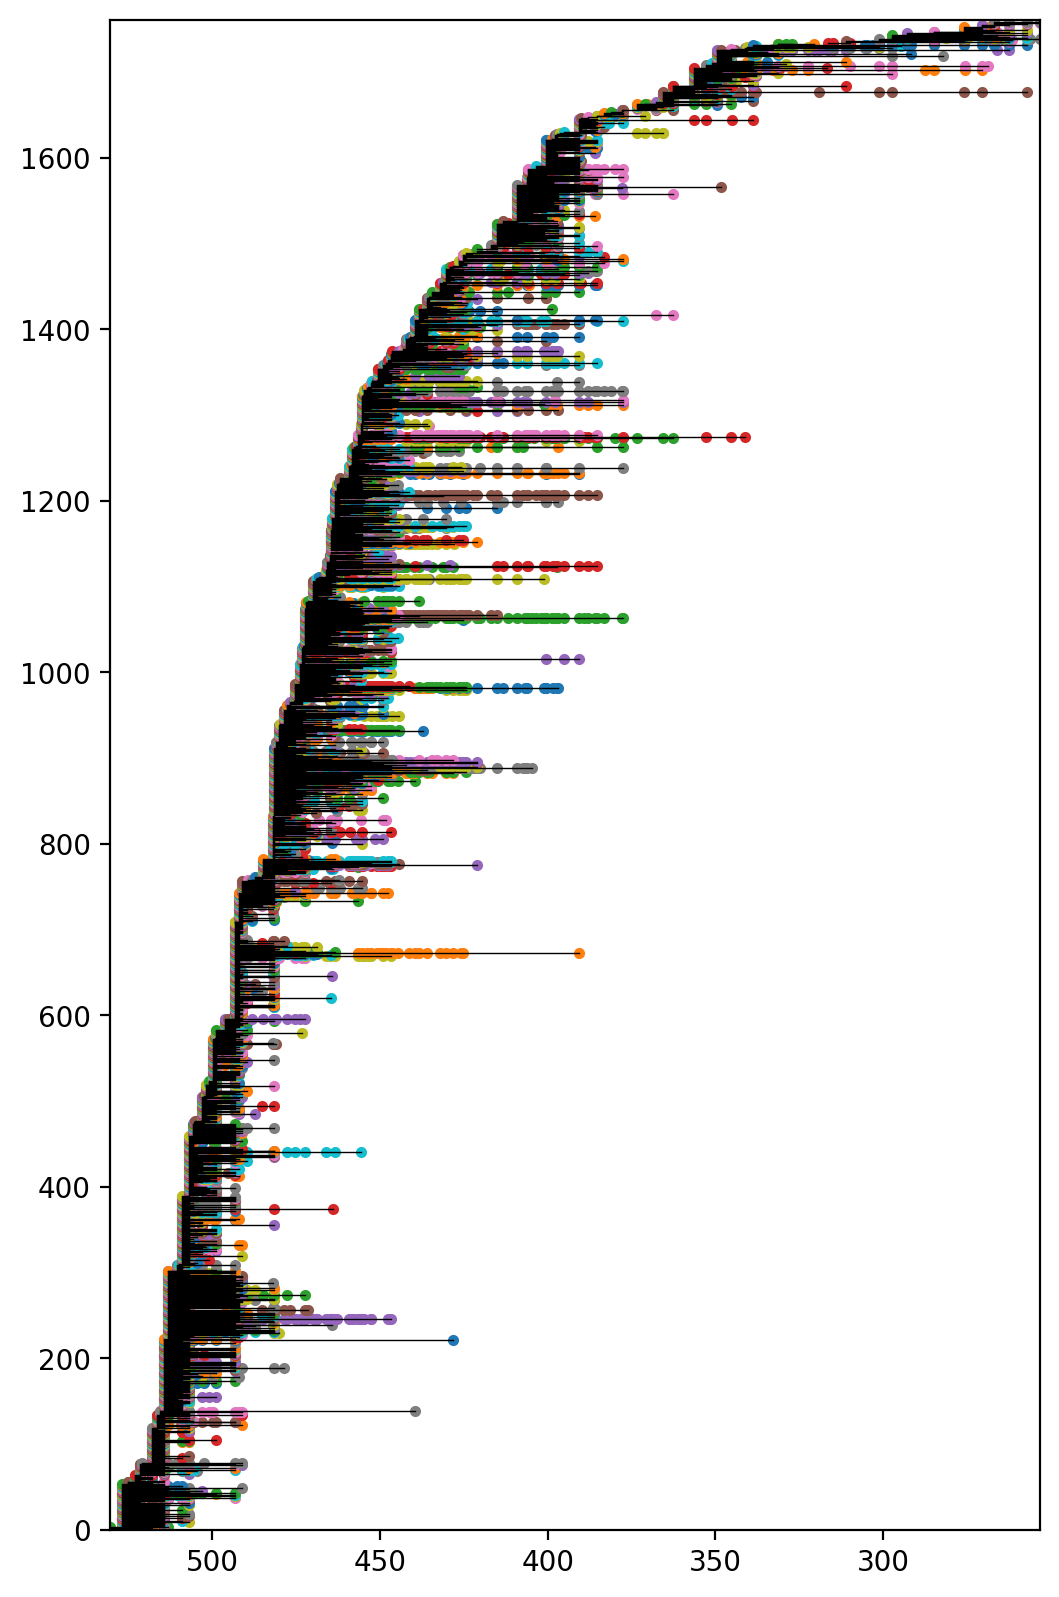

In [22]:
plotStackedBarsWithDots(subcladeDictTrilobiteGenera)

Top ten most persistent subclades:
1. Proetus: 115.6 Ma
2. Brachymetopus: 108.5 Ma
3. Acidaspis: 102.7 Ma
4. Otarion: 94.9 Ma
5. Phacops: 93.9 Ma
6. Paladin: 87.1 Ma
7. Solenopleura: 86.3 Ma
8. Phillipsia: 85.8 Ma
9. Griffithides: 84.1 Ma
10. Aulacopleura (Paraaulacopleura): 82.9 Ma


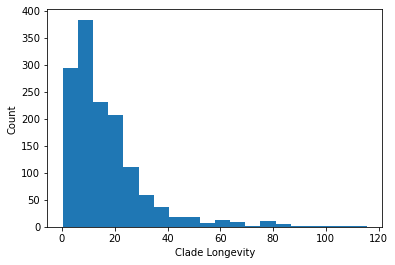

In [23]:
plotAgeHistogram(subcladeStartEndsTrilobiteGenera, n_bins=20)

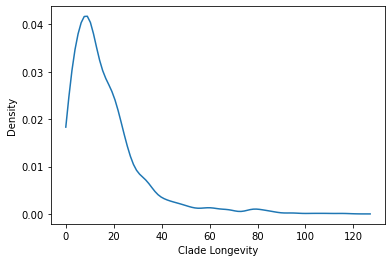

In [24]:
plotAgeDensityDist(subcladeStartEndsTrilobiteGenera, cov_factor=0.2)

In [23]:
# Example 4: All families of molluscs that died off before 50 Ma

# This is a big ol' search so it takes a while to run without a local version
subcladeDictMolluscaFamilies = getSubcladeOccurences("Mollusca", resolution="family", recency_cutoff=50)

Local save of requested search found.



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (17,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Excluding 329 subclades with occurences after 50 Ma

931 unique subclades (family) found
862 subclades with multiple occurences
764 subclades with at least 5 occurences


In [24]:
subcladeStartEndsMolluscaFamilies = getSubcladeAgeRanges(subcladeDictMolluscaFamilies, 
                                                          min_occurence_threshold=5)

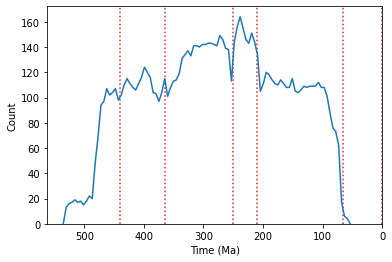

In [25]:
# Emphasis on the "PSEUDO"-sepkoski in this figure, as it's 
# not actually representative of mollusca
plotSepkoski(subcladeStartEndsMolluscaFamilies, event_lines=[440, 365, 250, 210, 65, 0])

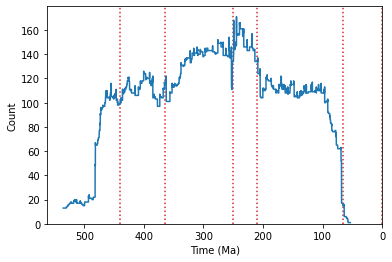

In [26]:
plotSepkoskiBins(subcladeStartEndsMolluscaFamilies, event_lines=[440, 365, 250, 210, 65, 0], n_bins=10000)

Local save of requested search found.



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (17,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


1392 unique subclades (family) found
1295 subclades with multiple occurences
1159 subclades with at least 5 occurences


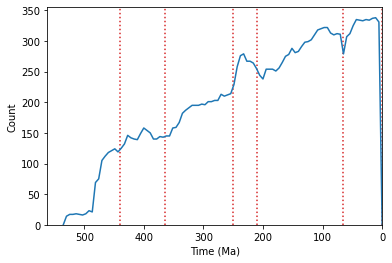

In [28]:
# Here's what mollusca looks like when we don't exclude 
# clades that persisted past 50 Ma.
# The dip at 0 Ma is probably due to the nature of the database
plotSepkoski(getSubcladeAgeRanges(getSubcladeOccurences("Mollusca", resolution="family"), 
                                  min_occurence_threshold=5), 
             event_lines=[440, 365, 250, 210, 65, 0])

Local save of requested search found.



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (17,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


1392 unique subclades (family) found
1295 subclades with multiple occurences
1159 subclades with at least 5 occurences


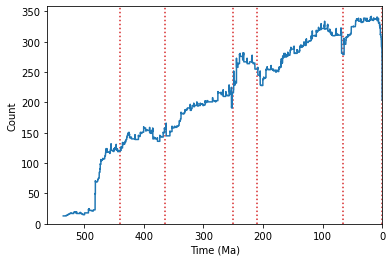

In [27]:
plotSepkoskiBins(getSubcladeAgeRanges(getSubcladeOccurences("Mollusca", resolution="family"), 
                                  min_occurence_threshold=5),
                 event_lines=[440, 365, 250, 210, 65, 0], n_bins=10000)

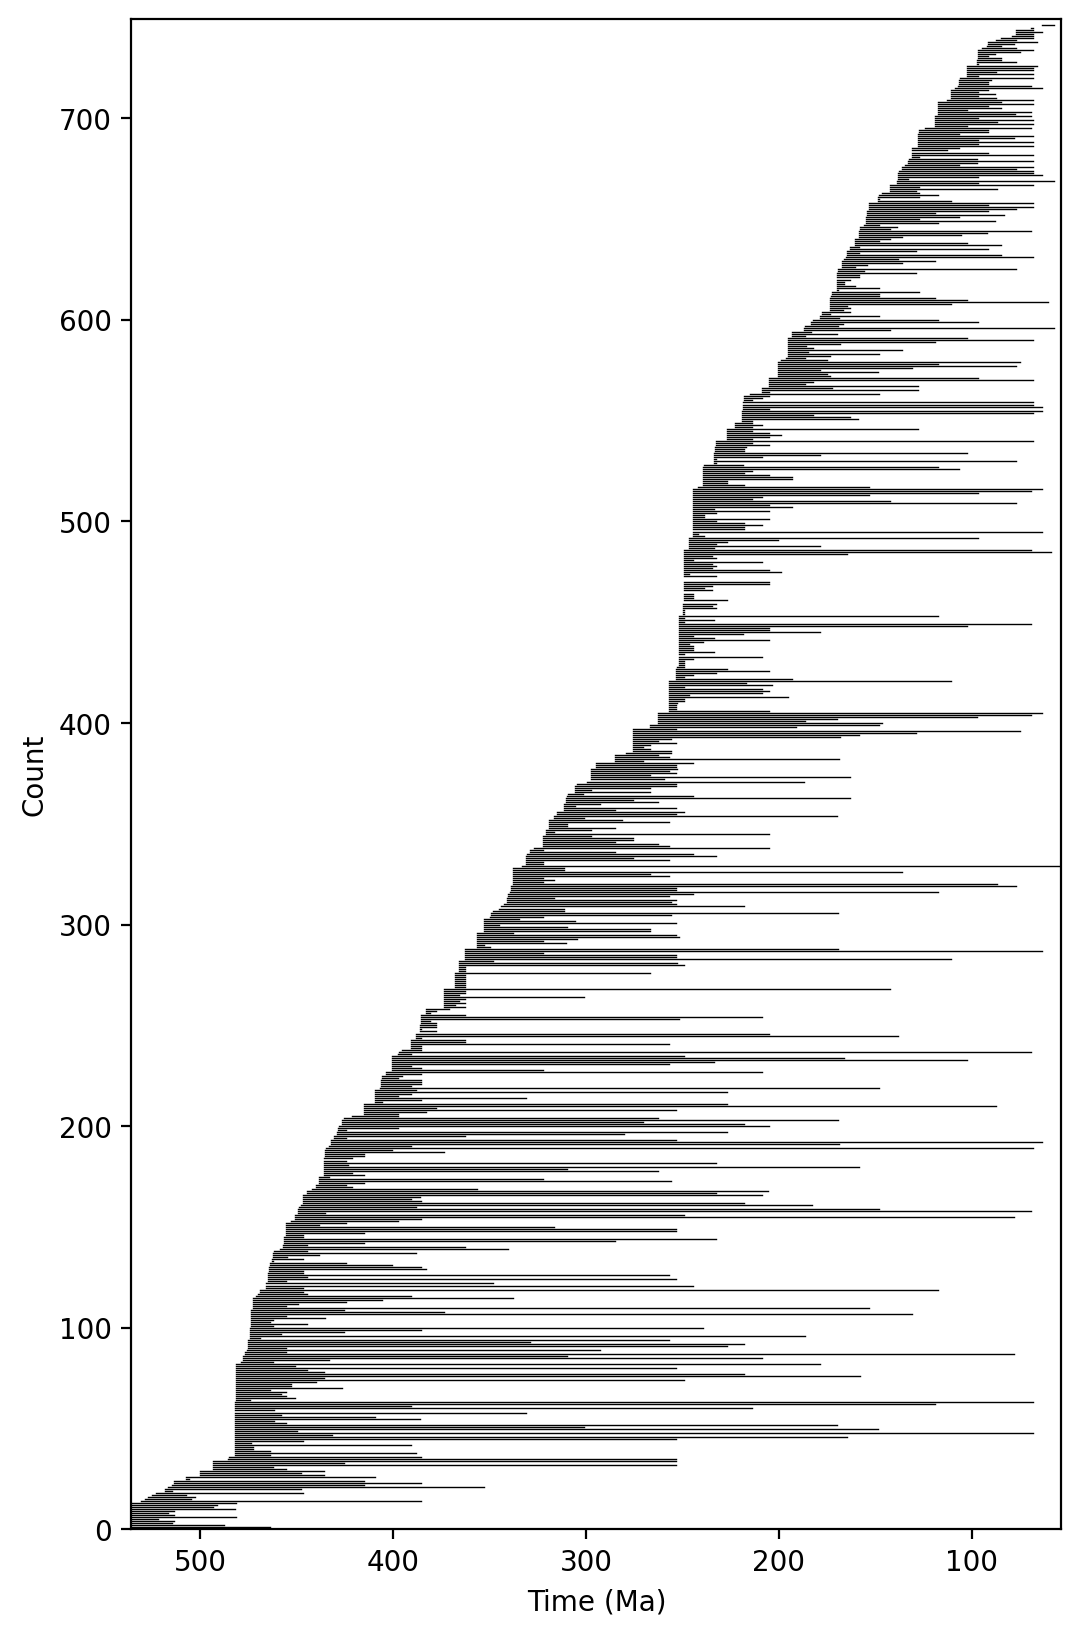

In [29]:
plotStackedBars(subcladeStartEndsMolluscaFamilies)

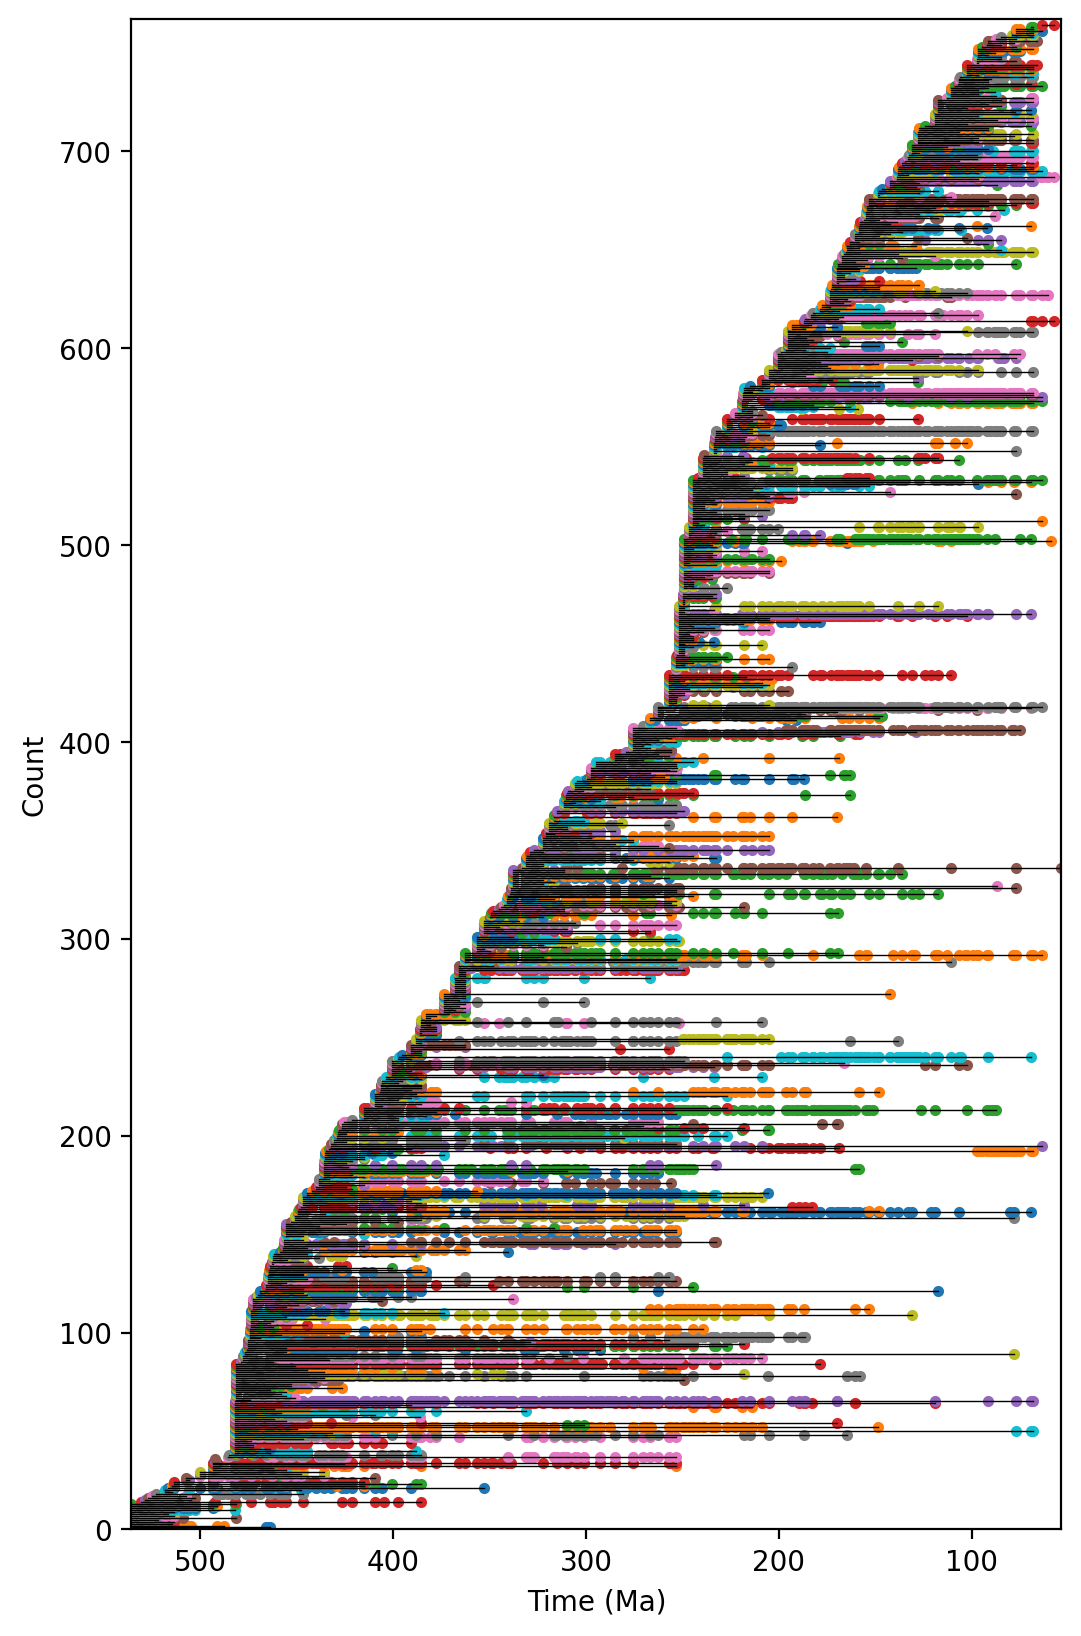

In [28]:
plotStackedBarsWithDots(subcladeDictMolluscaFamilies)

Top ten most persistent subclades:
1. Cardiolariidae: 413.7 Ma
2. Euomphalidae: 413.7 Ma
3. Gotlandochitonidae: 398.9 Ma
4. Kalenteridae: 380.1 Ma
5. Elasmonematidae: 372.9 Ma
6. Porcelliidae: 368.1 Ma
7. Hippuritidae: 366.2 Ma
8. Lophospiridae: 363.0 Ma
9. Geisonoceratidae: 351.7 Ma
10. Murchisoniidae: 342.2 Ma


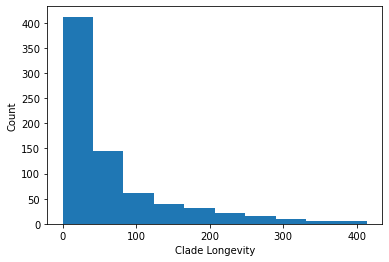

In [31]:
plotAgeHistogram(subcladeStartEndsMolluscaFamilies)

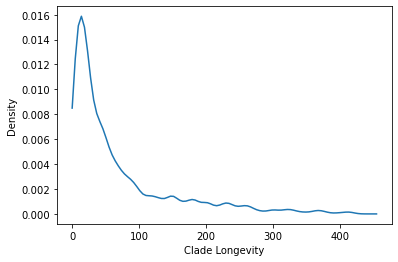

In [32]:
plotAgeDensityDist(subcladeStartEndsMolluscaFamilies, cov_factor=0.1)

In [33]:
# Example 5: All genera of molluscs that die off before 50 Ma

subcladeDictMolluscaGenera = getSubcladeOccurences("Mollusca", resolution="genus", recency_cutoff=50)

Local save of requested search found.



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (17,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Excluding 2285 subclades with occurences after 50 Ma

8227 unique subclades (genus) found
6605 subclades with multiple occurences
4760 subclades with at least 5 occurences


In [34]:
subcladeStartEndsMolluscaGenera = getSubcladeAgeRanges(subcladeDictMolluscaGenera, 
                                                          min_occurence_threshold=5)

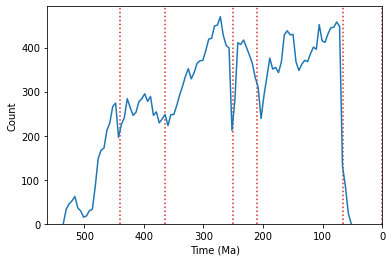

In [35]:
# Once again, not a true Sepkoski curve (see below)
plotSepkoski(subcladeStartEndsMolluscaGenera, event_lines=[440, 365, 250, 210, 65, 0])

Local save of requested search found.



/home/software/anaconda3/2020.11/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (17,23) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


12981 unique subclades (genus) found
10718 subclades with multiple occurences
7896 subclades with at least 5 occurences


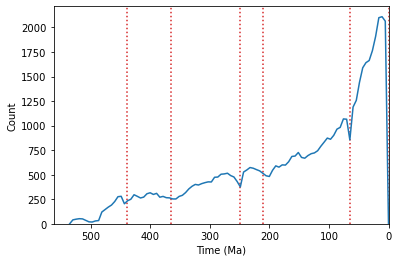

In [36]:
# Actual Sepkoski curve for illustration
plotSepkoski(getSubcladeAgeRanges(getSubcladeOccurences("Mollusca", resolution="genus"), 
                                  min_occurence_threshold=5), 
             event_lines=[440, 365, 250, 210, 65, 0])

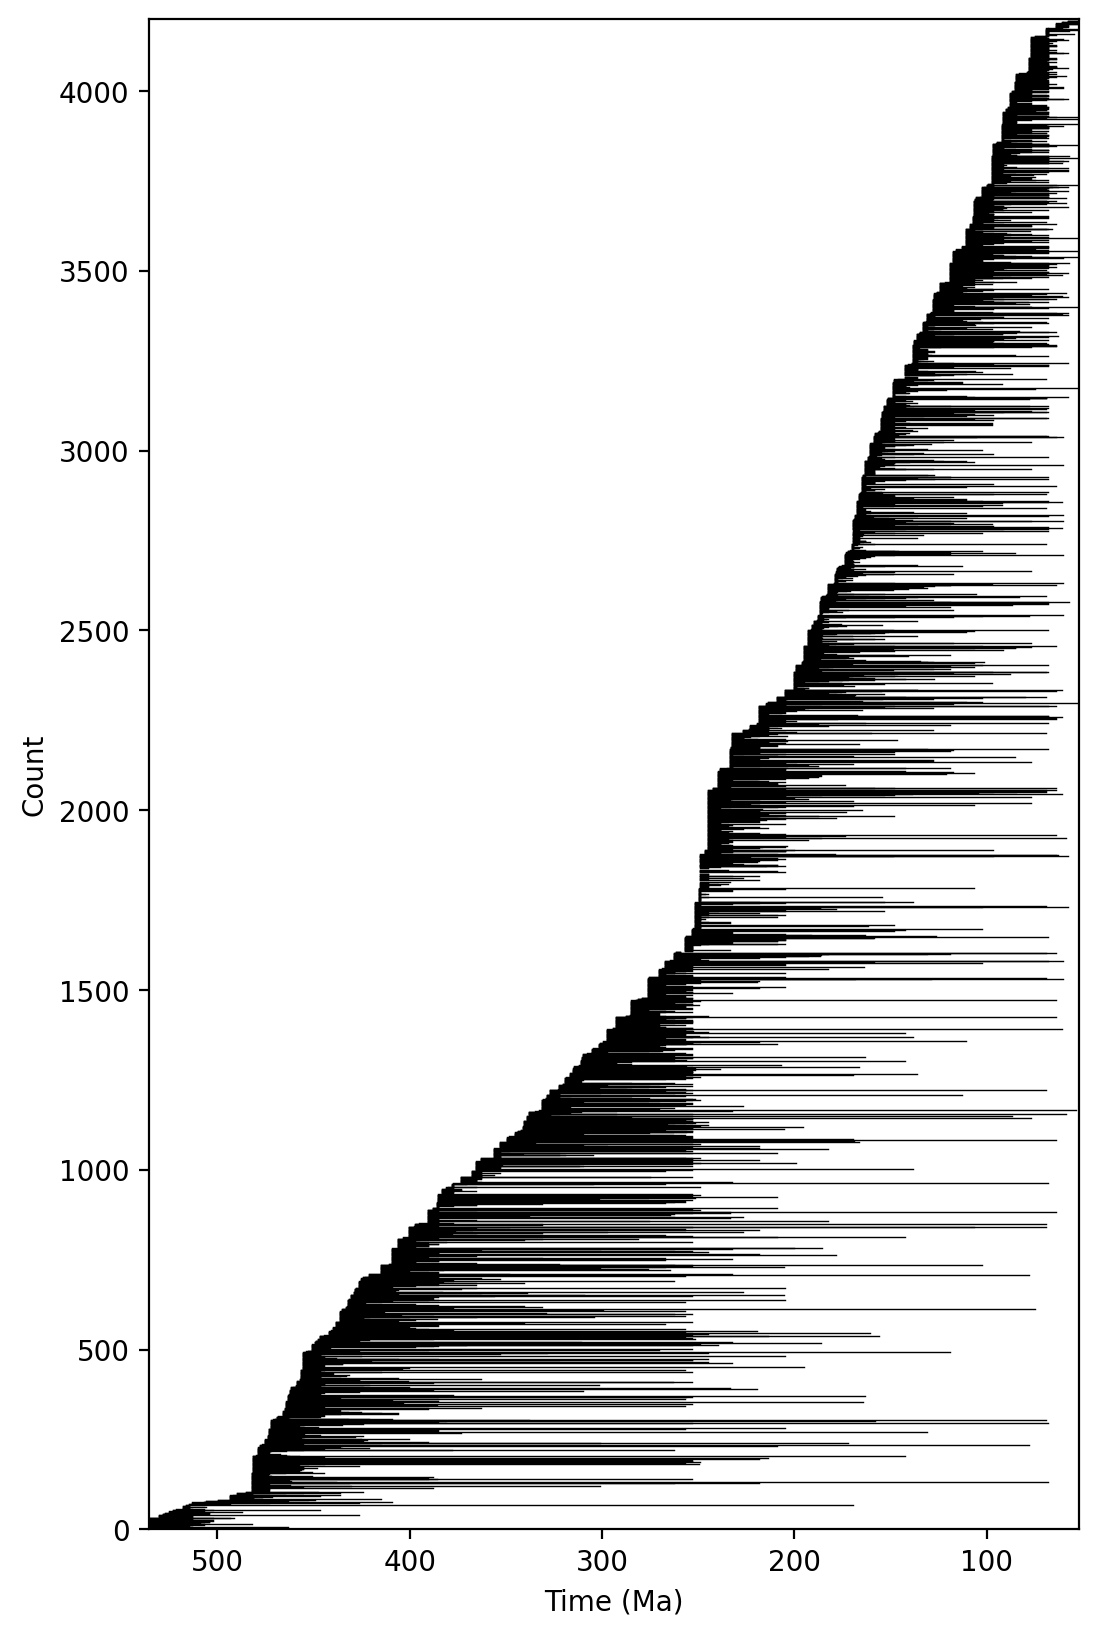

In [37]:
plotStackedBars(subcladeStartEndsMolluscaGenera)

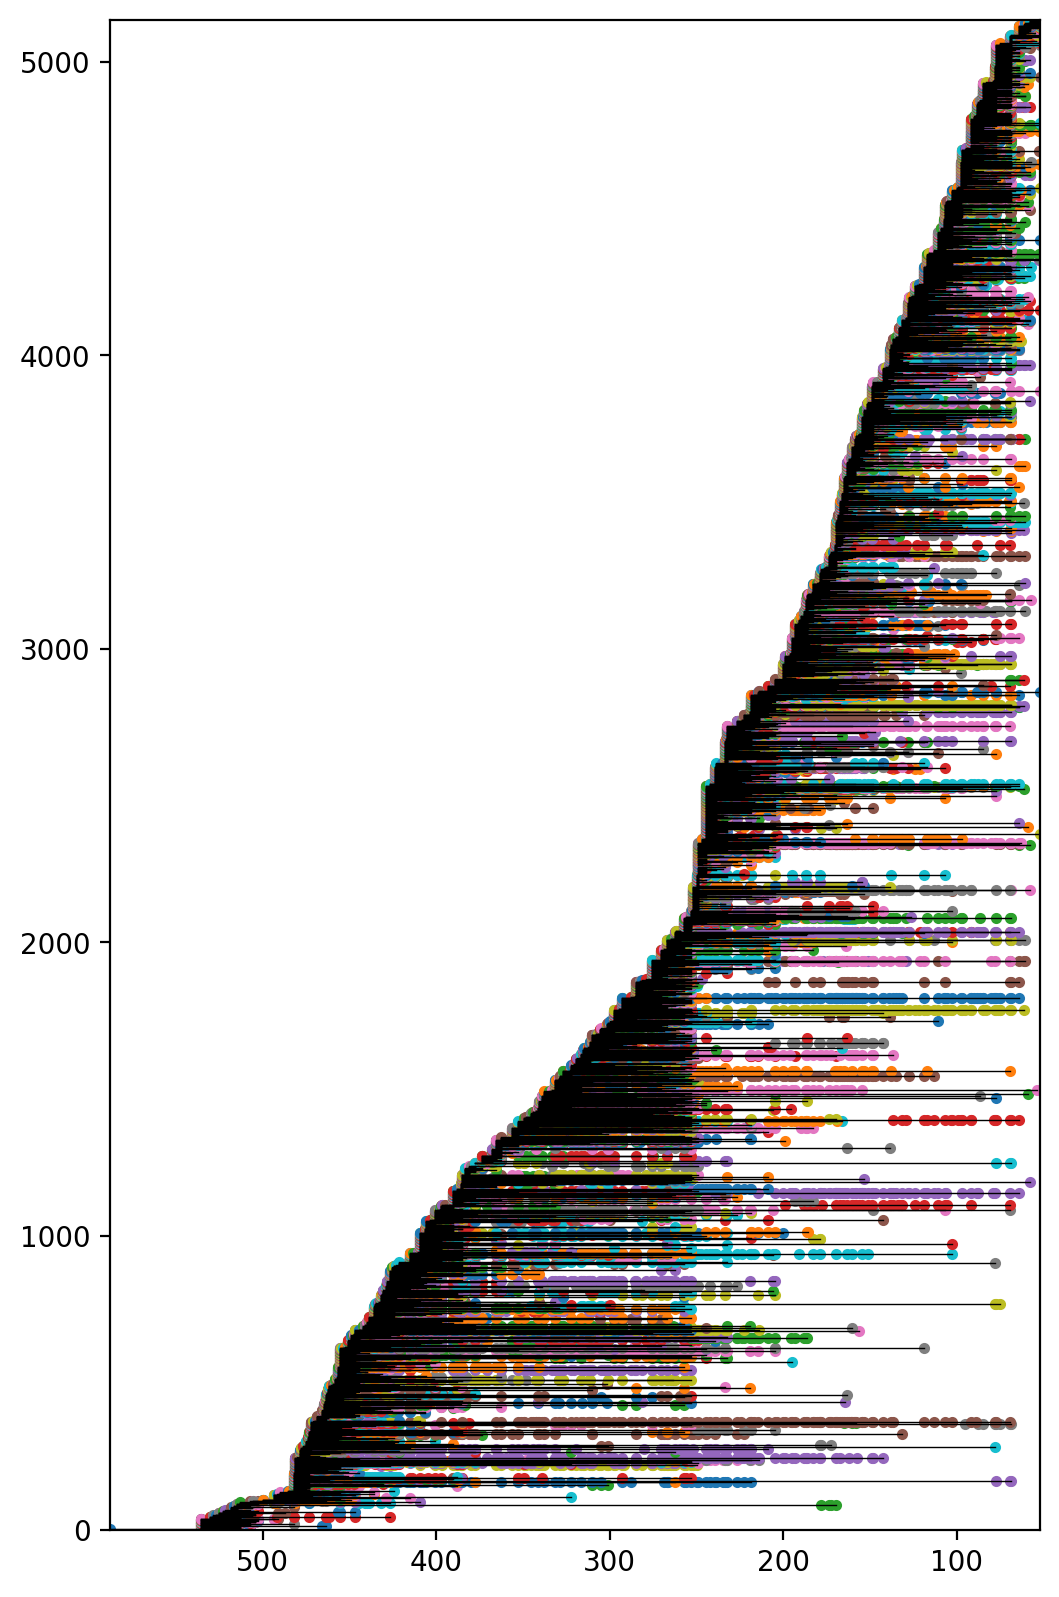

In [38]:
# This is just kind of funny I guess. Way too busy, but it does 
# highlight some of the problem genera
plotStackedBarsWithDots(subcladeDictMolluscaGenera)

Top ten most persistent subclades:
1. Deceptrix: 413.7 Ma
2. Didymoceras: 404.0 Ma
3. Parallelodon: 403.2 Ma
4. Ivoechiton: 398.9 Ma
5. Whitfieldiella: 359.8 Ma
6. Brevibelus: 344.9 Ma
7. Elasmonema: 343.2 Ma
8. Murchisonia: 342.2 Ma
9. Palaeoneilo: 338.9 Ma
10. Straparollus: 336.2 Ma


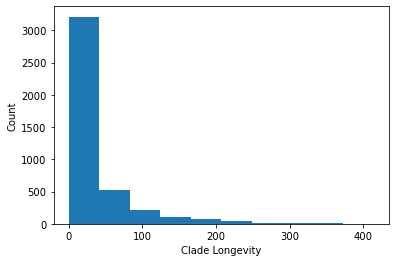

In [39]:
# These particular long-lived folks are problems
plotAgeHistogram(subcladeStartEndsMolluscaGenera)

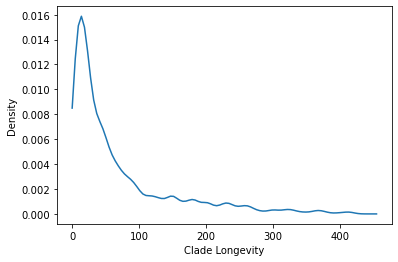

In [40]:
plotAgeDensityDist(subcladeStartEndsMolluscaFamilies, cov_factor=0.1)

Text(0, 0.5, '')

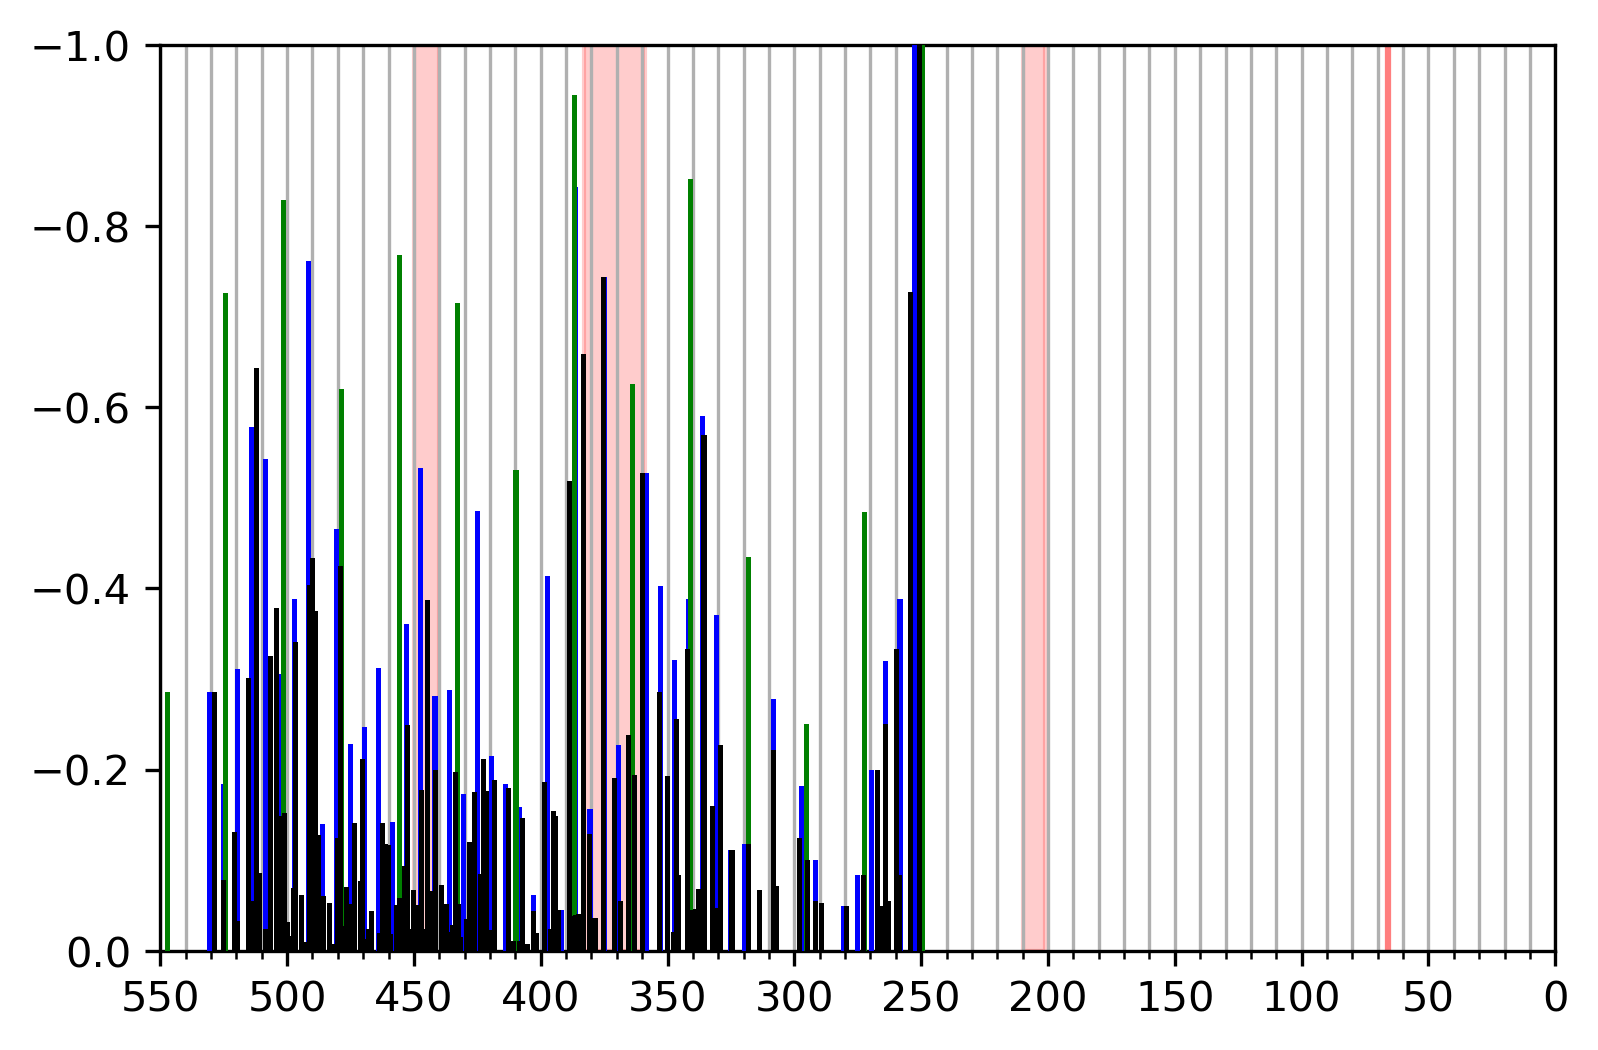

In [8]:
#bins_to_time = [(t_0 - (bin_size * x)) - (1 * bin_size) for x in range(bins)]
ml = ticker.MultipleLocator(10)
plt.axes().xaxis.set_minor_locator(ml)
plt.bar([t_0 - (bin_size * x) - (0.5 * bin_size) for x in np.linspace(0, bins, num=high_res_bins)], 
            [-x if x>0 else 0 for x in extinctionRatesHighRes], width=2, zorder=100,color="black")
plt.bar([t_0 - (bin_size * x) - (0.5 * bin_size) for x in np.linspace(0, bins, num=bins)], 
            [-x if x>0 else 0 for x in extinctionRates], width=2, zorder=99,color="blue")
plt.bar([t_0 - (bin_size * x) - (0.5 * bin_size) for x in np.linspace(0, bins, num=25)], 
            [-x if x>0 else 0 for x in extinctionRatesLowRes], width=2, zorder=99,color="green")


plt.gca().invert_xaxis()
#plt.hlines(0, 0, t_0, color="black")
plt.vlines([252, 66], -1, 0, alpha=0.5, color="red")
plt.axvspan(383, 359, alpha=0.2, color='red')
plt.axvspan(450, 440, alpha=0.2, color='red')
plt.axvspan(201, 210, alpha=0.2, color='red')
plt.ylim(0, -1)
plt.xticks(range(0, 600, 50))
plt.xlim(t_0, 0)
plt.grid(axis="x", which="both", ls="-")
plt.ylabel("")

In [9]:
#logOdds, models = getLogOddsLinear(survivalMatrixMetazoa, max_p=max_p, min_p=min_p)
#print(len(logOdds), len(models))
#num_bins_regressed = False

#logOdds_youngSuper, models_youngSuper = getLogOddsLinear(survivalMatrices[0], max_p=max_p, min_p=min_p, limit_ages=num_bins_regressed)
#logOdds_midSuper, models_midSuper = getLogOddsLinear(survivalMatrices[1], max_p=max_p, min_p=min_p, limit_ages=num_bins_regressed)
#logOdds_oldSuper, models_oldSuper = getLogOddsLinear(survivalMatrices[2], max_p=max_p, min_p=min_p, limit_ages=num_bins_regressed)

#logOdds_youngSuperduper, models_youngSuperduper = getLogOddsLinear(survivalMatricesSuperduper[0], max_p=max_p, min_p=min_p)
#logOdds_midSuperduper, models_midSuperduper = getLogOddsLinear(survivalMatricesSuperduper[1], max_p=max_p, min_p=min_p)
#logOdds_oldSuperduper, models_oldSuperduper = getLogOddsLinear(survivalMatricesSuperduper[2], max_p=max_p, min_p=min_p)

#logOdds_youngMega, models_youngMega = getLogOddsLinear(survivalMatricesMega[0], max_p=max_p, min_p=min_p)
#logOdds_midMega, models_midMega = getLogOddsLinear(survivalMatricesMega[1], max_p=max_p, min_p=min_p)
#logOdds_oldMega, models_oldMega = getLogOddsLinear(survivalMatricesMega[2], max_p=max_p, min_p=min_p)

In [10]:
#%run "~/persistence/sepkoskiMakerV6.ipynb"
#print(survivalMatrixMetazoa.T)
#exp_parameters = getExponentialFits(survivalMatrixMetazoa)
#print(ageByBinMetazoa)